In [544]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Importing The Data

In [546]:
cust_demographics=pd.read_excel("CustomerDemographics.xlsx",sheet_name="CustomerDemographics")
cust_behaviour_data=pd.read_excel("CustomerBehaviorData.xlsx",sheet_name="Train")
credit_consumption_data=pd.read_excel("CreditConsumptionData.xlsx",sheet_name="Train")

In [547]:
cust_demographics.head()

ID account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0  19427      current      M   63  MEDIUM              30.1                10   
1  16150      current      M   36  MEDIUM              14.4                10   
2  11749      current      F   28  MEDIUM               4.8                10   
3  11635      current      M   32  MEDIUM               9.6                 2   
4   8908      current      M   32    HIGH              12.0                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  
0        628.0                1                           5.0  
1        656.0                0                          12.0  
2        314.0                1                          13.0  
3        614.0                1                          19.0  
4        750.0                1                          18.0

In [548]:
cust_behaviour_data.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  \
0       6693.0          19.0            10             2  ...   
1       6117.0           4.0            60             1  ...   
2       2638.0           2.0            83            47  ...   
3       3711.0          12.0             2            16  ...   
4       1065.0          15.0            13            61  ...   

   credit_count_may  debit_count_may  max_credit_amount_may  debit_amount_jun  \
0                 1              108                97916.0          45253.64   
1                 1                4                25125.0          12912.33   
2                70               11                38546.0          93567.51   
3                43                1               180315.0         176394.48   
4                 2               14                13480.0           3167.00   

   credit_amount_jun  credit_count_jun  debit_count_jun  \
0           47635.00                 2               18   
1           18369.00                 3               49   
2           26713.00                47               49   
3           35062.74                 3               37   
4           19056.00                 2               15   

   max_credit_amount_jun  loan_enq  emi_active  
0                19947.0         Y     3448.84  
1                20585.0         Y     3812.69  
2                13950.0         Y     9432.90  
3                37018.0         Y      144.61  
4                24274.0         Y     1887.89  

[5 rows x 39 columns]

In [549]:
credit_consumption_data.head()

ID  cc_cons
0  12554  20014.0
1  17645  10173.0
2   7604  16095.0
3   1590   7707.0
4  16556  96408.0

## Merging the Data

In [551]:
customer_df=pd.merge(cust_behaviour_data,credit_consumption_data,on=["ID"],how="inner")
customer_df=pd.merge(customer_df,cust_demographics,on=["ID"],how="inner")

## Exploratory Data Analysis

Shape of Data: 

In [553]:
customer_df.shape

(20000, 49)

Column Names & Data Types:

In [555]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons_apr                   20000 non-null  float64
 2   dc_cons_apr                   20000 non-null  float64
 3   cc_cons_may                   19999 non-null  float64
 4   dc_cons_may                   20000 non-null  float64
 5   cc_cons_jun                   20000 non-null  float64
 6   dc_cons_jun                   19999 non-null  float64
 7   cc_count_apr                  19999 non-null  float64
 8   cc_count_may                  20000 non-null  int64  
 9   cc_count_jun                  20000 non-null  int64  
 10  dc_count_apr                  20000 non-null  int64  
 11  dc_count_may                  20000 non-null  int64  
 12  dc_count_jun                  20000 non-null  int64  
 13  c

* Missing Values

In [557]:
customer_df.isna().sum()

ID                                 0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        1
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        1
cc_count_apr                       1
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               1
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       2
investment_4                       0
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    1
credit_count_apr                   0
max_credit_amount_apr              0
d

For 5000 values we have to make predictions, we will create a new dataframe containing all the data of customers for which we have to predict. Apart from that, there are 17 missing data points which we can simply drop as the numbers are very less .

Some customers are having missing values for credit consumption. You need to build
the model using customer’s data where credit consumption is non- missing’s. You need to
predict the credit consumption for next three months for the customers having missing
values.

In [560]:
null_cc_cons=pd.isnull(customer_df["cc_cons"])
pred_customer_df=customer_df[null_cc_cons].reset_index(drop=True)

In [561]:
customer_df=customer_df[customer_df["cc_cons"].notnull()].reset_index(drop=True)

Treating Missing Values in pred_customer_df

In [563]:
def missing_treat(x):
    if ((x.dtype == 'float') or (x.dtype == 'int')) :
        x = x.fillna(x.median())
    elif ((x.dtype == 'object') or (x.dtype == 'O')):
        x = x.fillna(x.mode()[0])
    else:
        x = x
    return x
customer_df=customer_df.apply(missing_treat)
pred_customer_df=pred_customer_df.apply(missing_treat)

In [564]:
customer_df.isna().sum()

ID                              0
cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     0
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     0
cc_count_apr                    0
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
personal_loan_active            0
vehicle_loan_active             0
personal_loan_closed            0
vehicle_loan_closed             0
investment_1                    0
investment_2                    0
investment_3                    0
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 0
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_m

In [565]:
pred_customer_df.isna().sum()

ID                                 0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        0
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        0
cc_count_apr                       0
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               0
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       0
investment_4                       0
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    0
credit_count_apr                   0
max_credit_amount_apr              0
d

In [566]:
customer_df.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  cc_cons  \
0       6693.0          19.0            10             2  ...  13434.0   
1       6117.0           4.0            60             1  ...    449.0   
2       2638.0           2.0            83            47  ...  11968.0   
3       3711.0          12.0             2            16  ...  32029.0   
4       1065.0          15.0            13            61  ...  16394.0   

   account_type  gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0       current       M   30  MEDIUM               7.0                 5   
1       current       M   37     LOW              10.2                 8   
2       current       M   33  MEDIUM               3.9                 3   
3       current       M   63     LOW              25.8                 6   
4        saving       M   33  MEDIUM               6.5                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  
0        956.0                1                          20.0  
1        966.0                1                           5.0  
2        505.0                1                          15.0  
3        631.0                0                          15.0  
4        698.0                0                           9.0  

[5 rows x 49 columns]

In [567]:
pred_customer_df.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17591      2795.45       1290.0      6141.05       676.50      9146.10   
1  13541     29405.13       1640.0      1670.00      2463.92     10947.50   
2  13431      5985.20       6189.0      2696.09       766.00       716.00   
3   8687      2105.93      18225.0     34763.56       167.00      4260.27   
4  14727      3269.00       3532.0      3158.40      2699.77      3373.48   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  cc_cons  \
0     15479.00           4.0            10             4  ...      NaN   
1       956.00           3.0            10             4  ...      NaN   
2      4133.22           7.0            30             5  ...      NaN   
3     20185.00           1.0            99            71  ...      NaN   
4      5120.00           2.0            10            47  ...      NaN   

   account_type  gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0       current       M   37  MEDIUM              11.9                 4   
1       current       M   33  MEDIUM               7.8                 6   
2       current       M   53     LOW              33.0                10   
3       current       M   33  MEDIUM               7.8                 5   
4       current       M   62     LOW              12.6                 9   

   region_code  NetBanking_Flag  Avg_days_between_transaction  
0        575.0                1                          16.0  
1        394.0                0                          19.0  
2        324.0                1                          15.0  
3        370.0                1                           7.0  
4        505.0                1                           3.0  

[5 rows x 49 columns]

In [568]:
# Dropping the variables that are not needed
customer_df.drop(columns=["ID"], inplace=True)
pred_customer_df.drop(columns=["cc_cons"], inplace=True)

# Outlier Detection(customer_df)

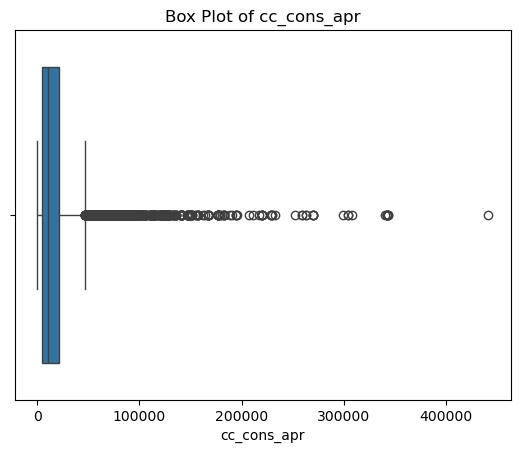

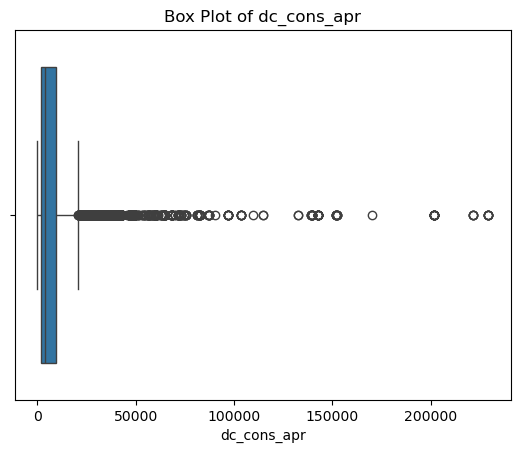

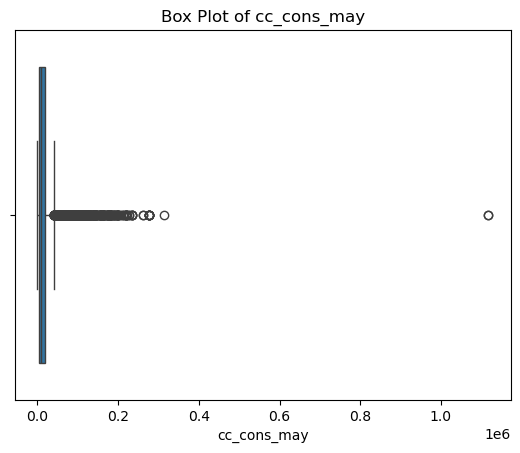

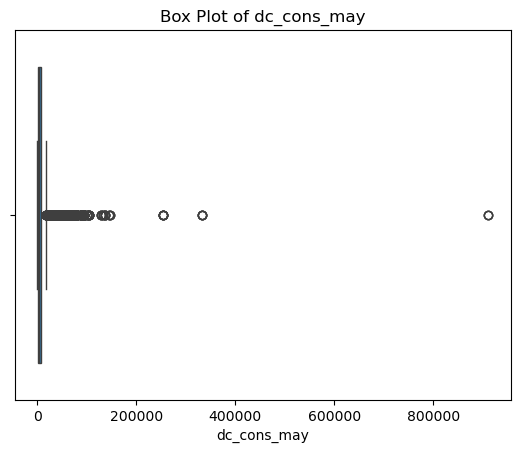

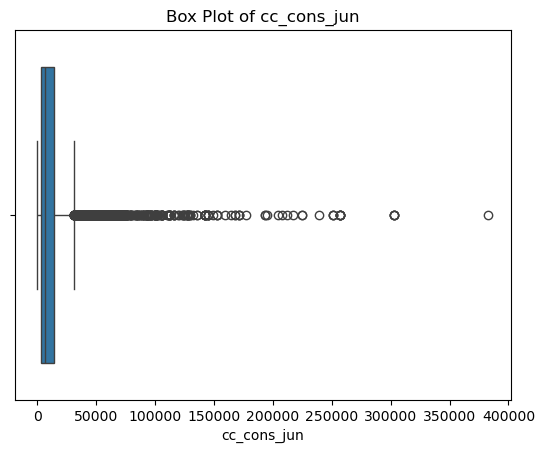

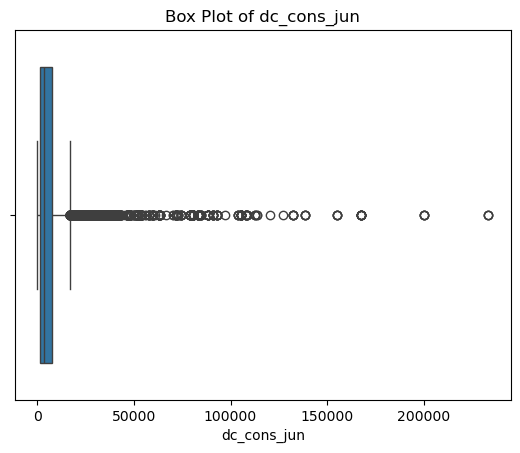

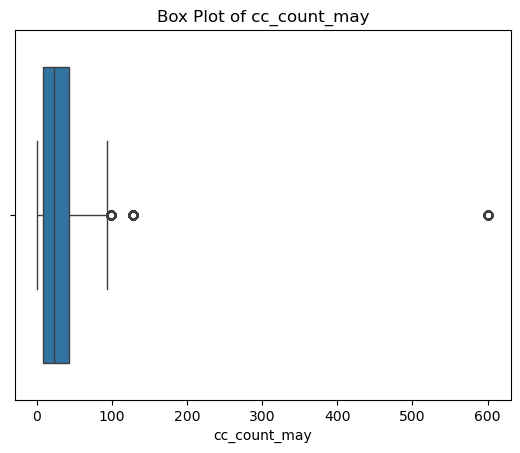

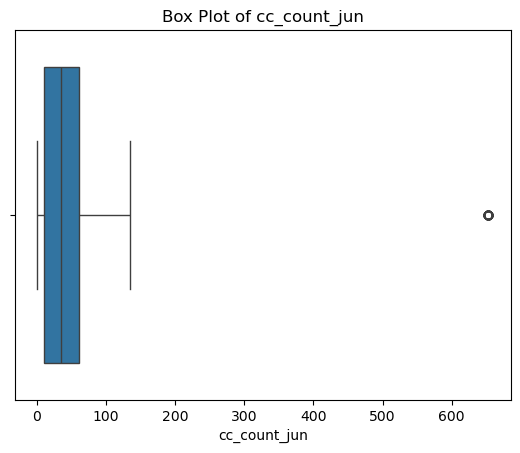

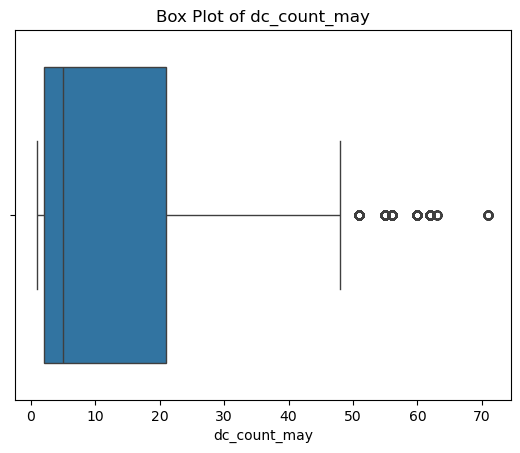

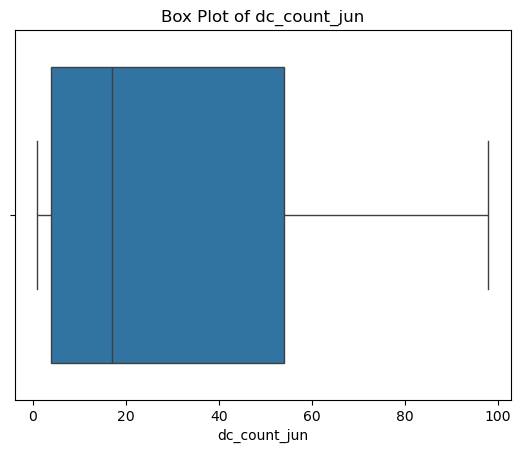

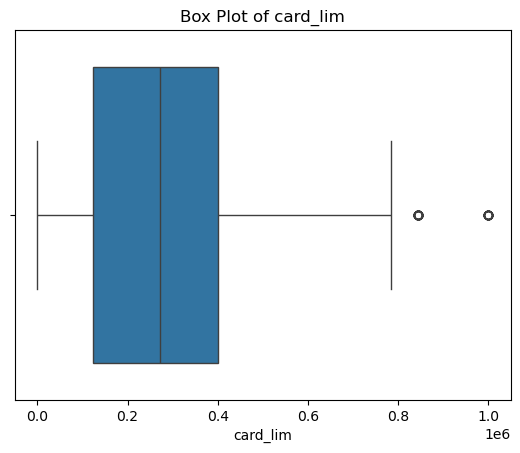

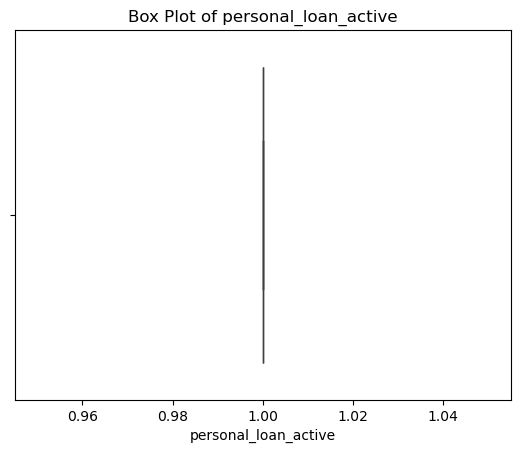

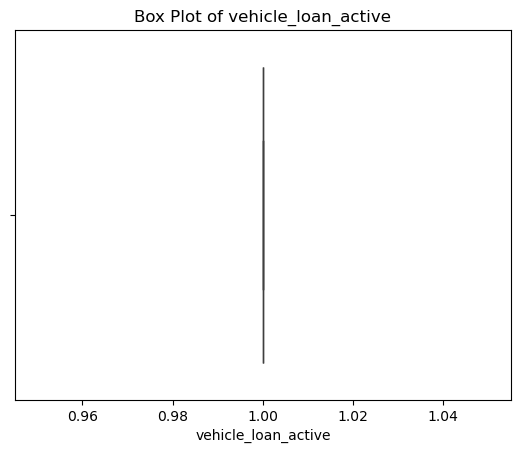

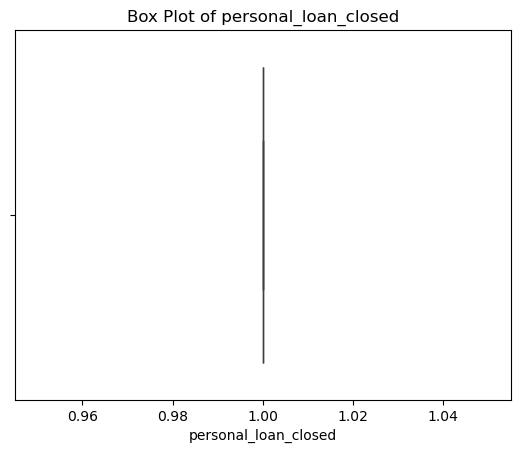

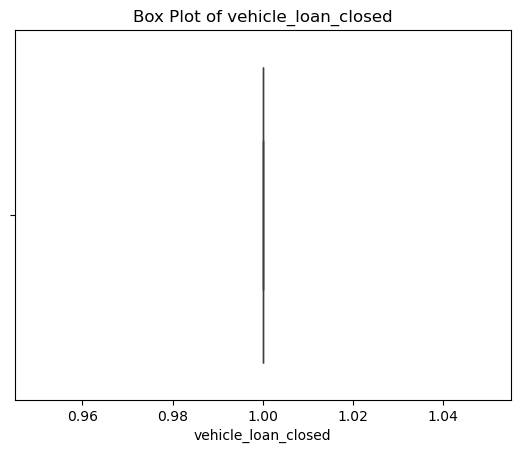

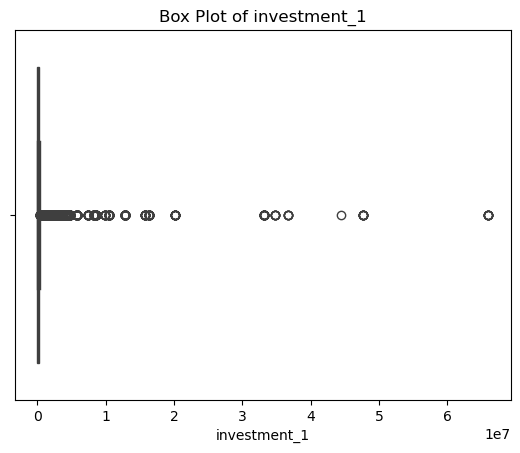

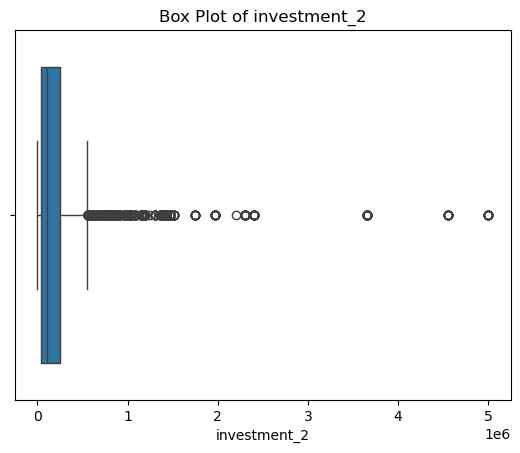

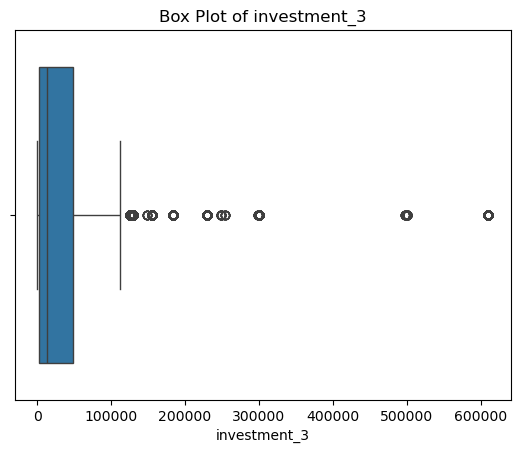

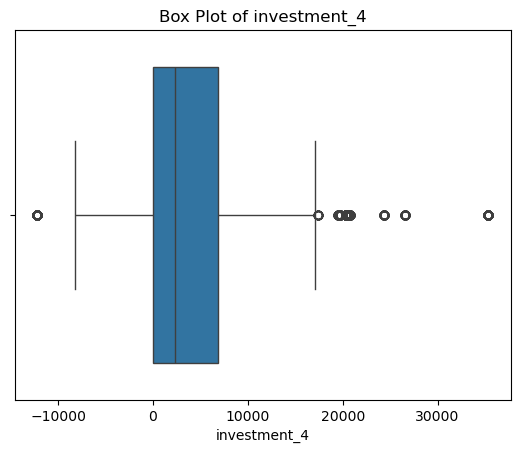

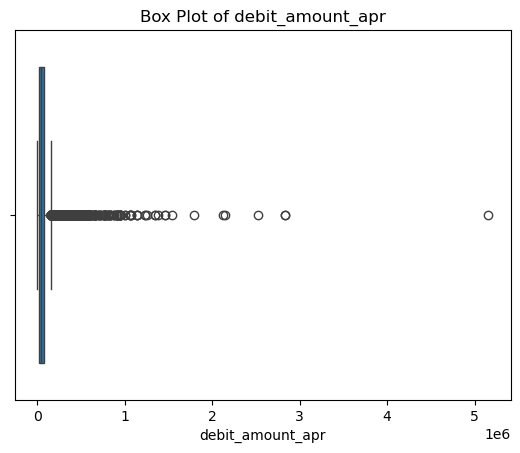

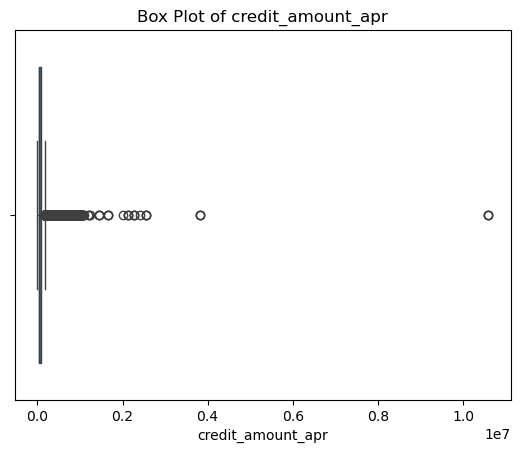

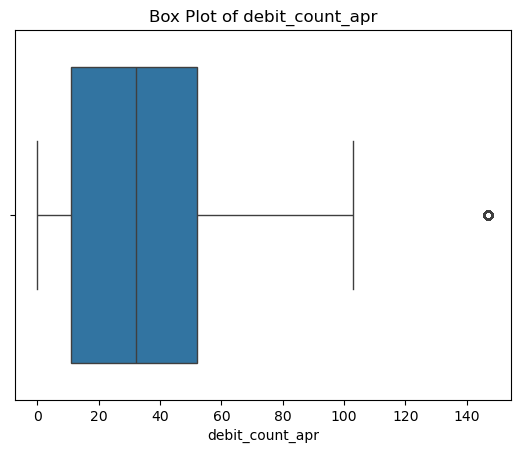

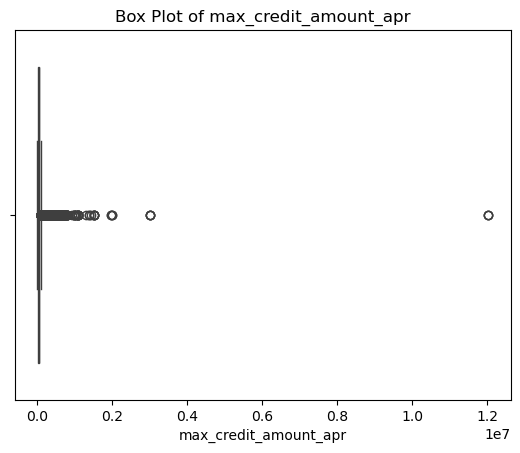

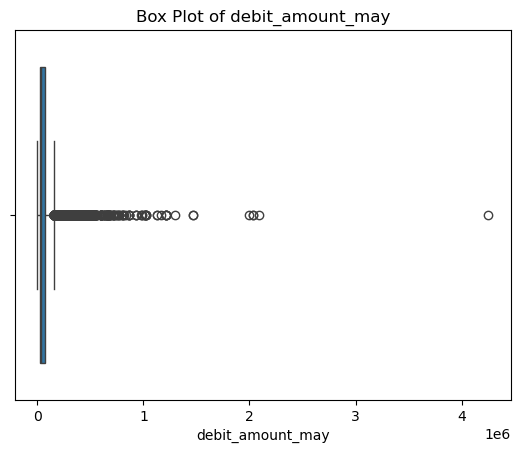

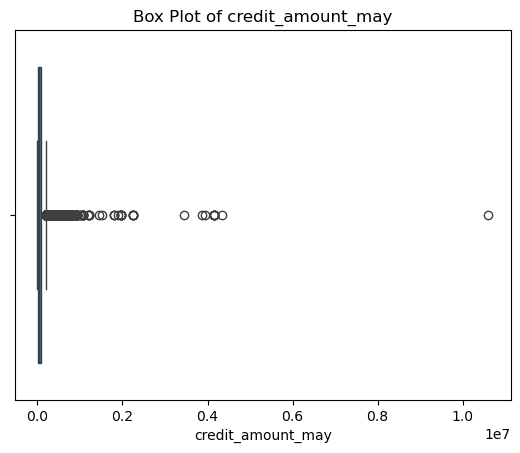

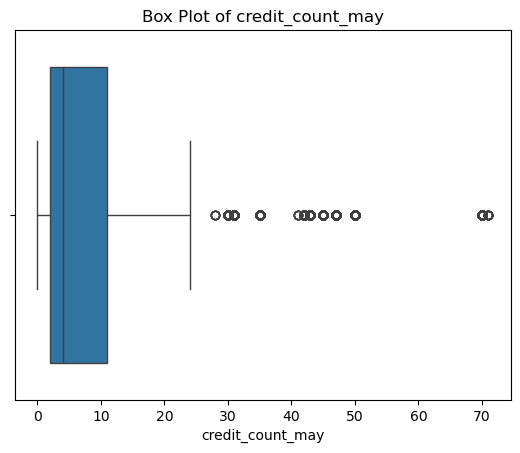

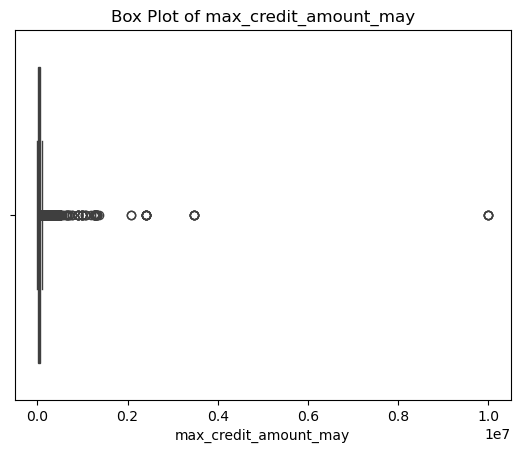

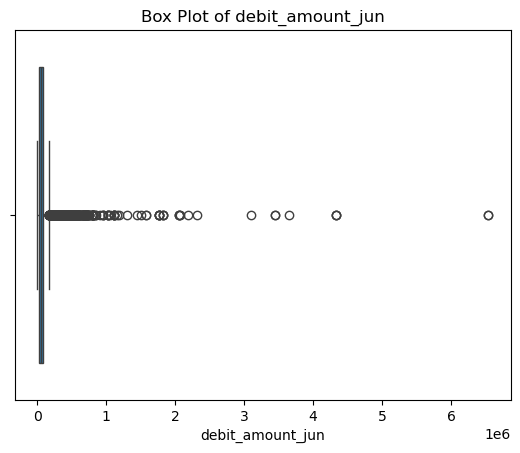

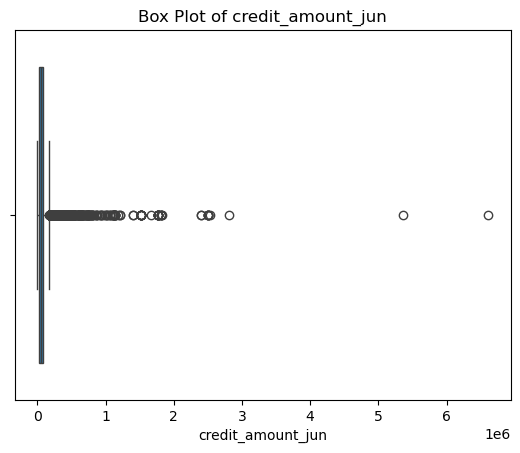

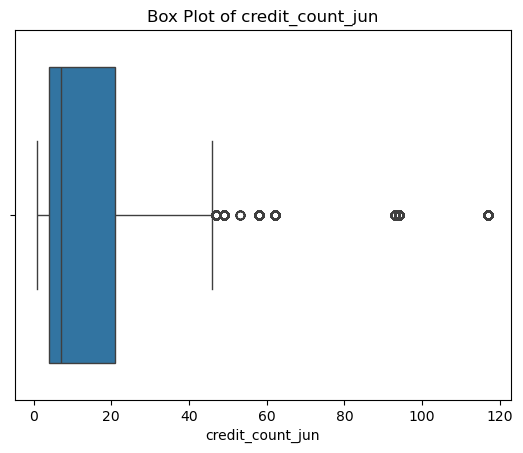

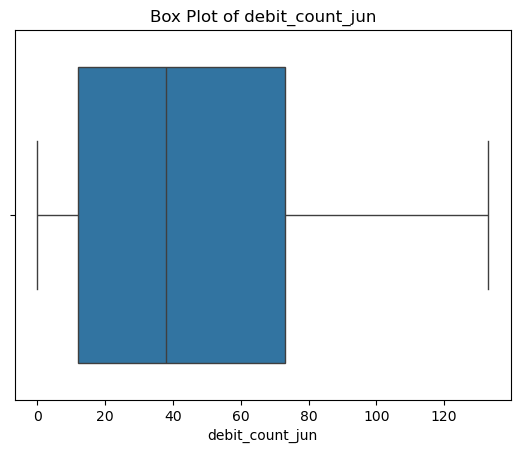

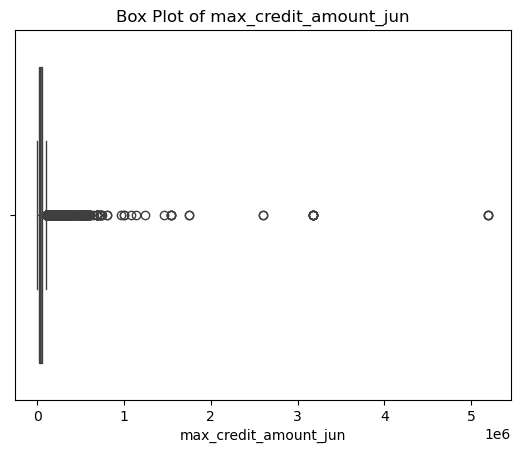

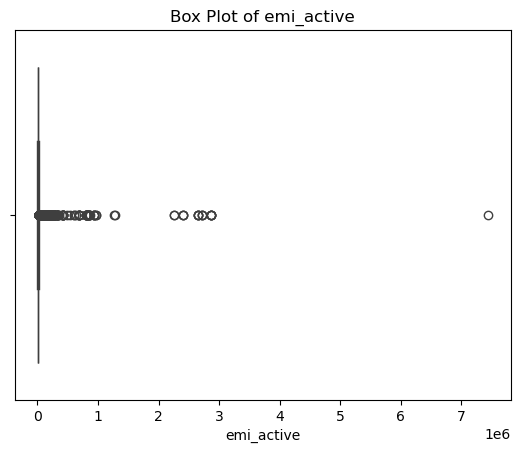

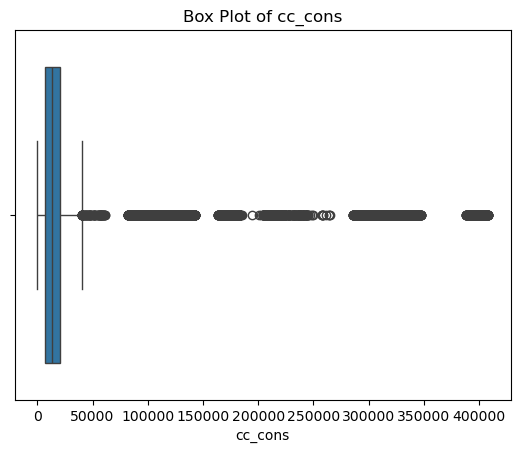

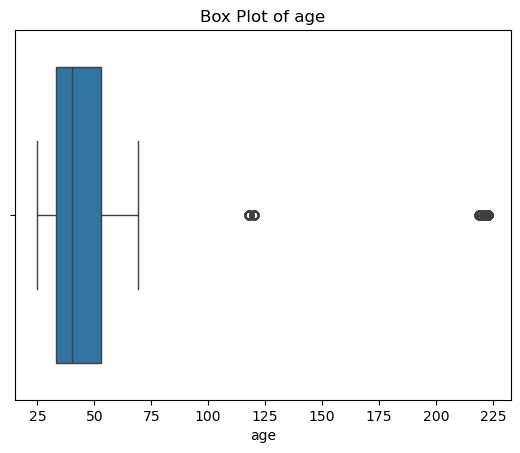

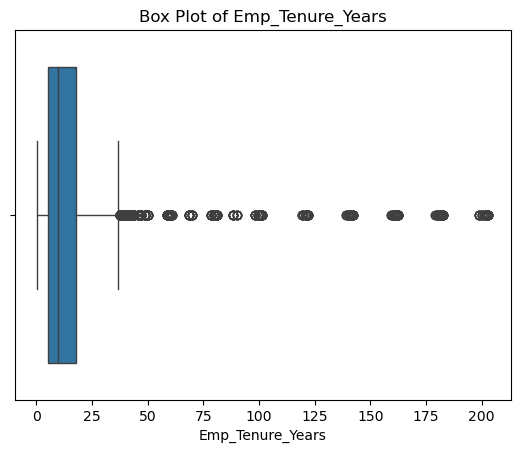

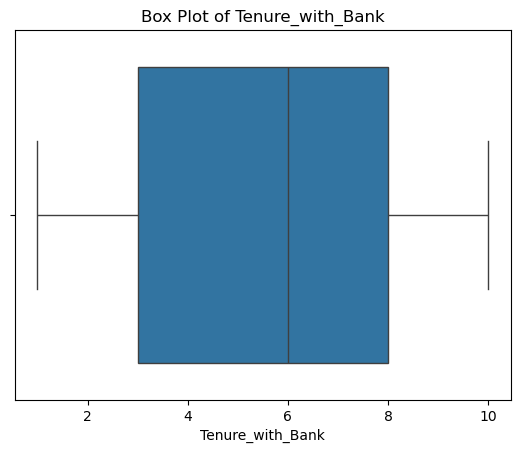

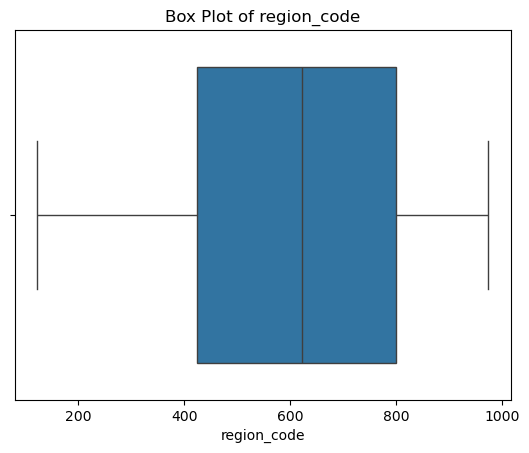

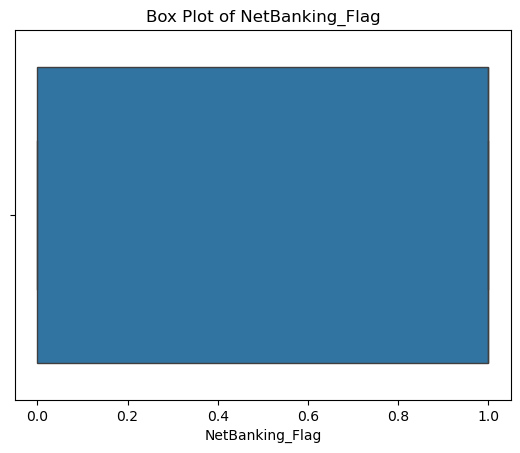

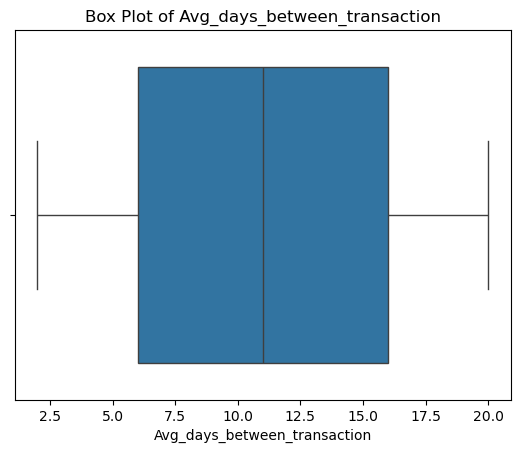

In [570]:
for i in customer_df.select_dtypes(include=["number"]).columns:
    sns.boxplot(x=customer_df[i])  
    plt.title(f"Box Plot of {i}")  
    plt.show()

There are outlier in every column.

# Outlier Detection(pred_customer_df)

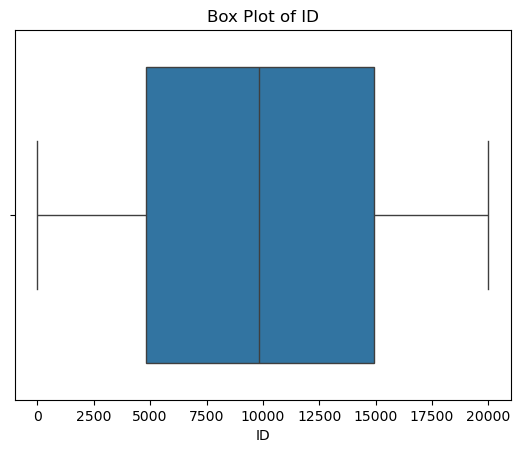

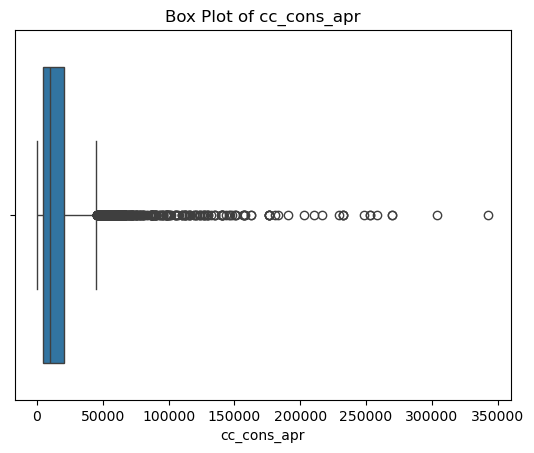

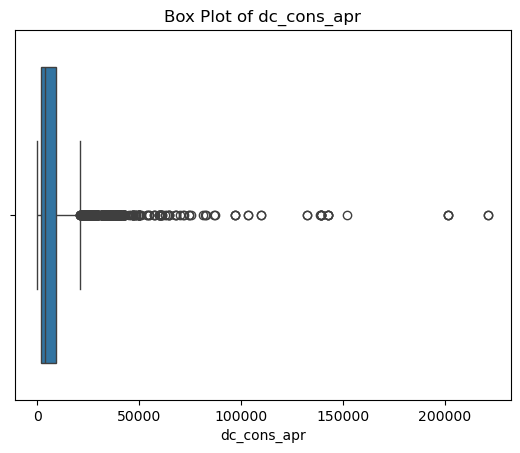

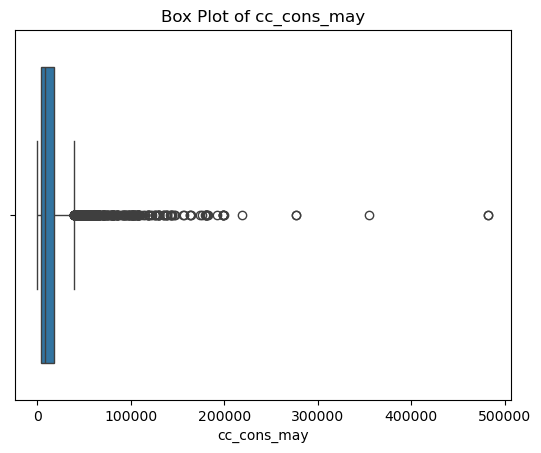

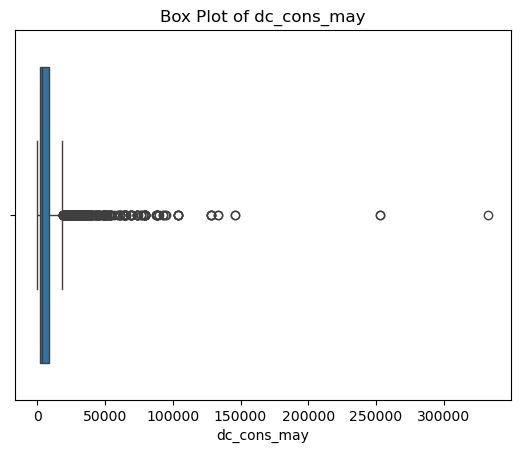

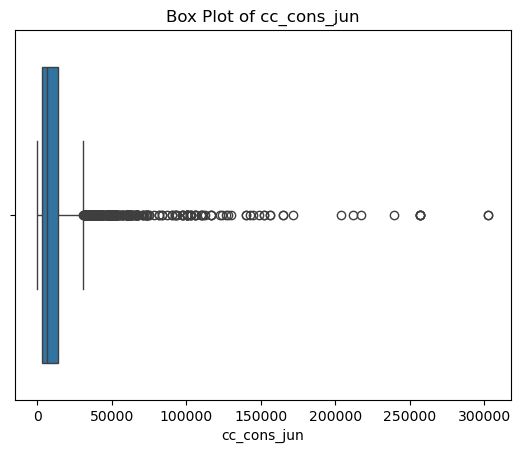

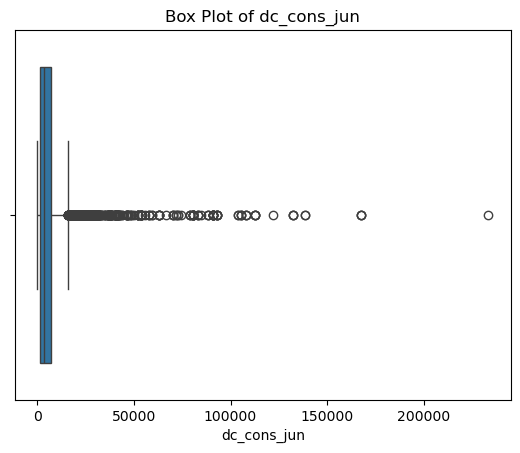

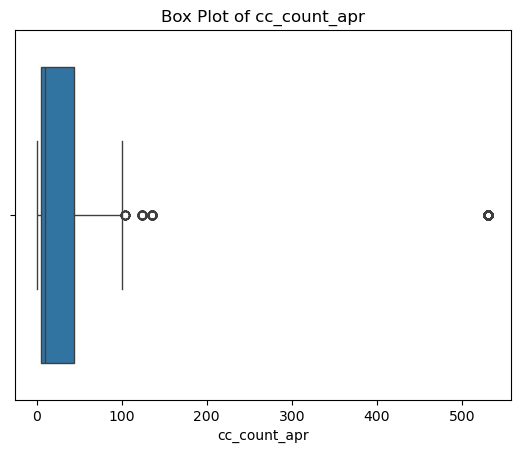

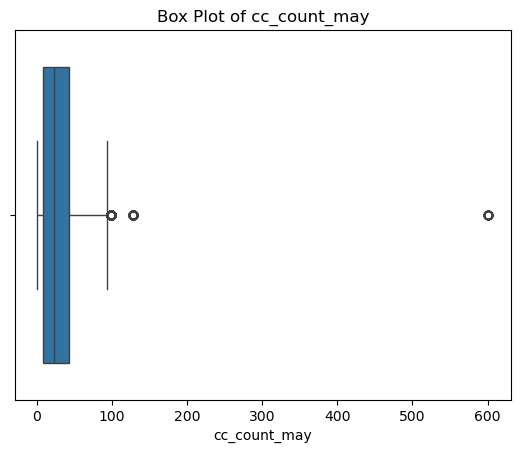

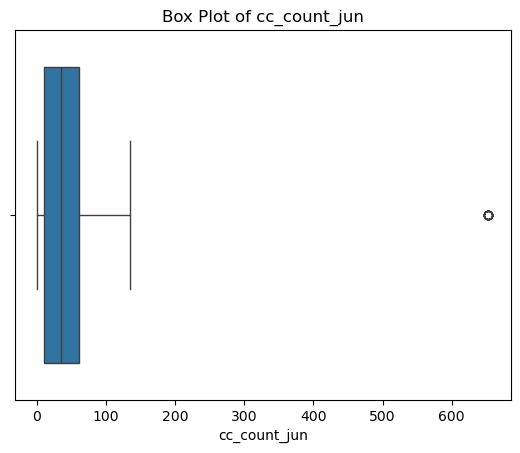

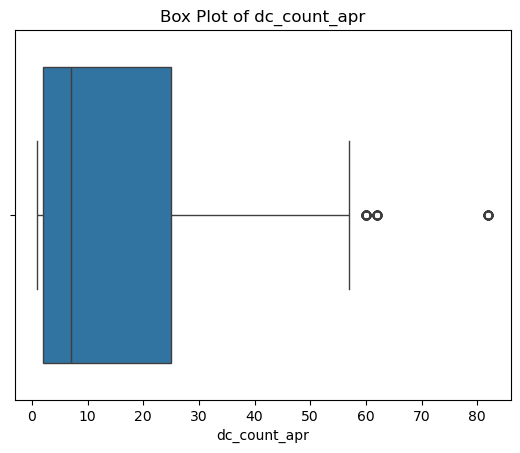

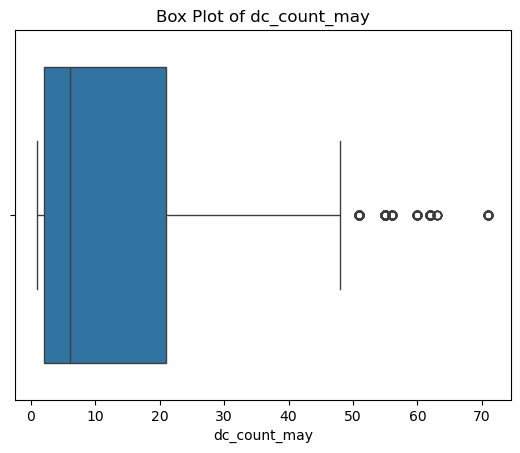

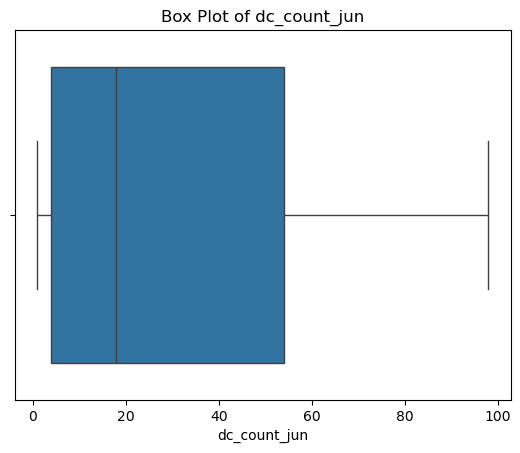

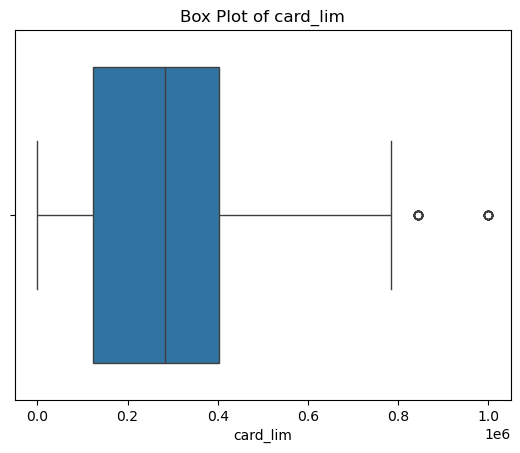

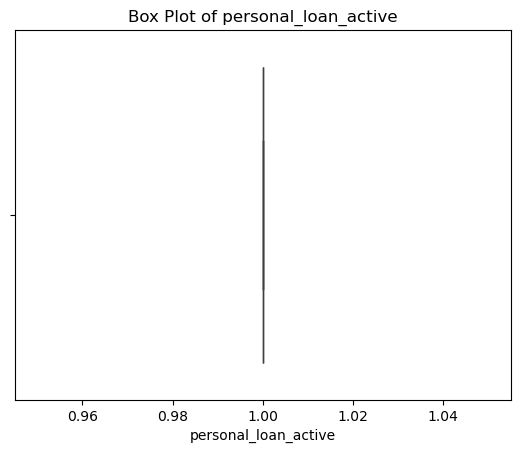

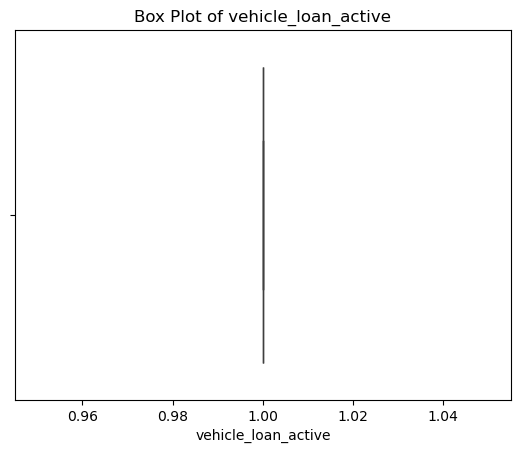

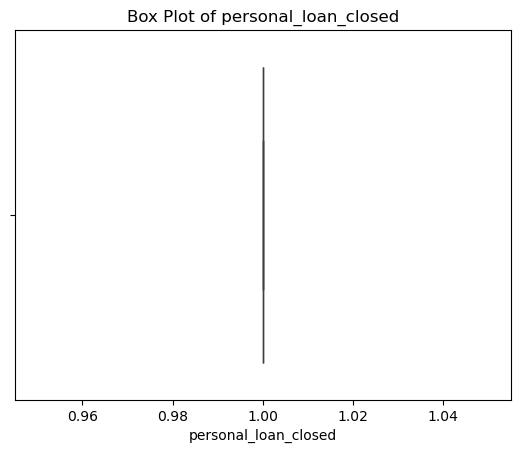

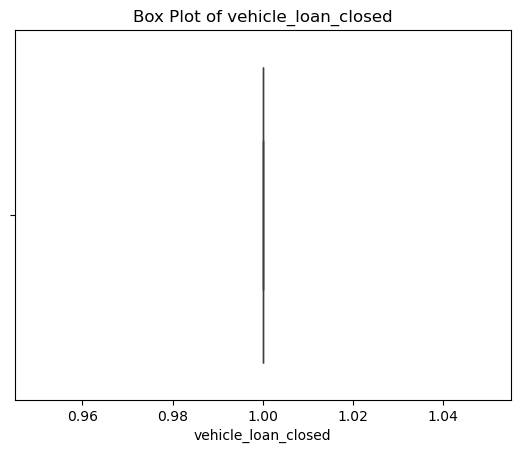

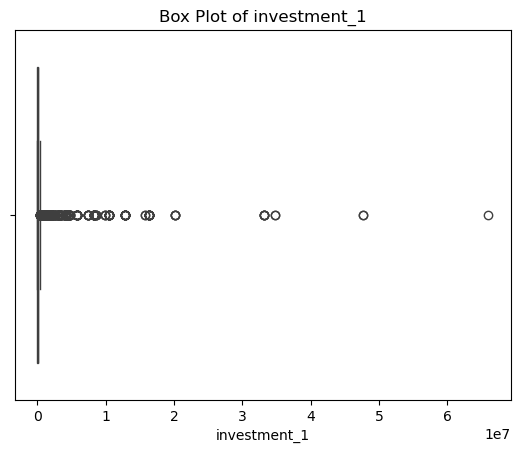

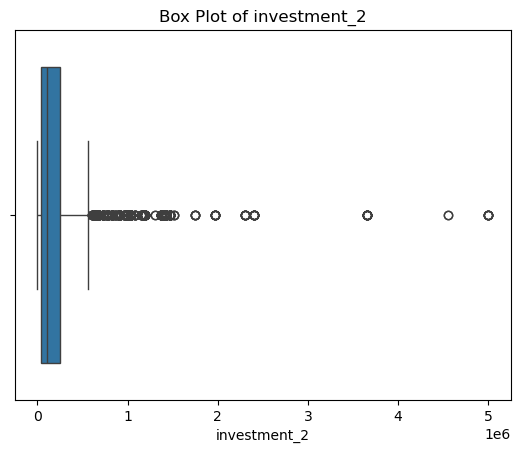

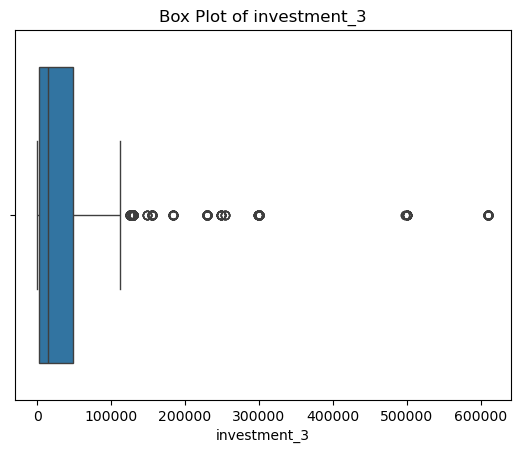

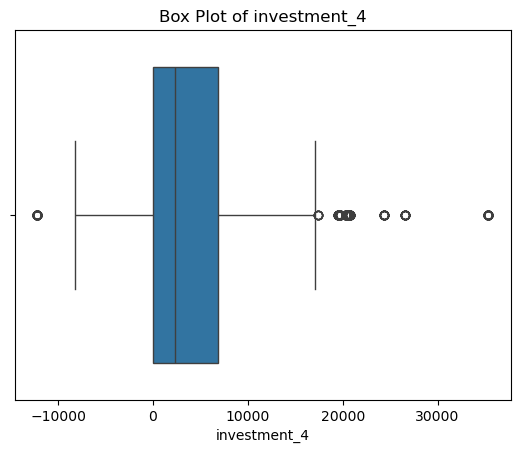

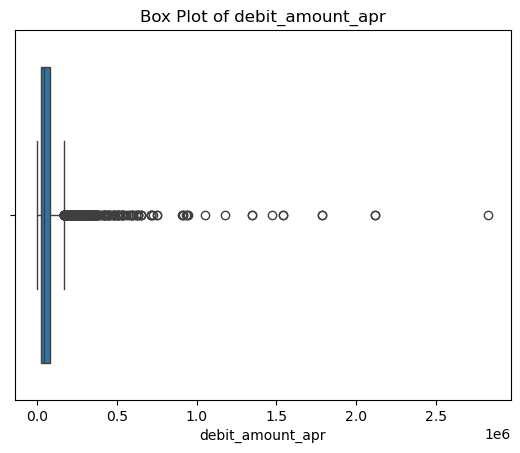

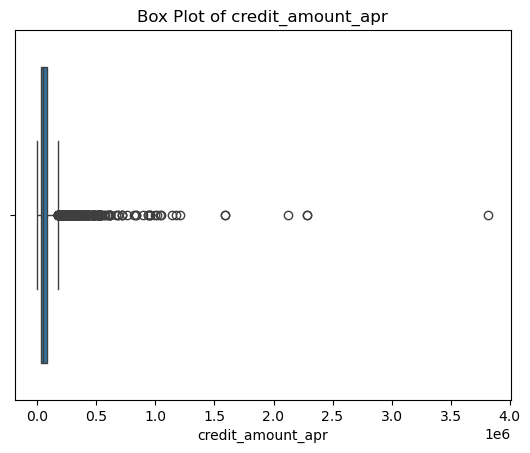

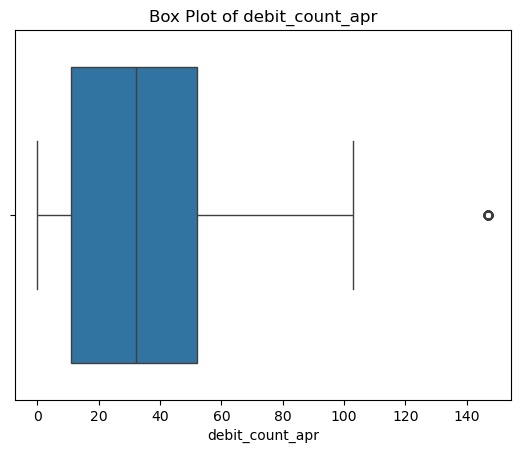

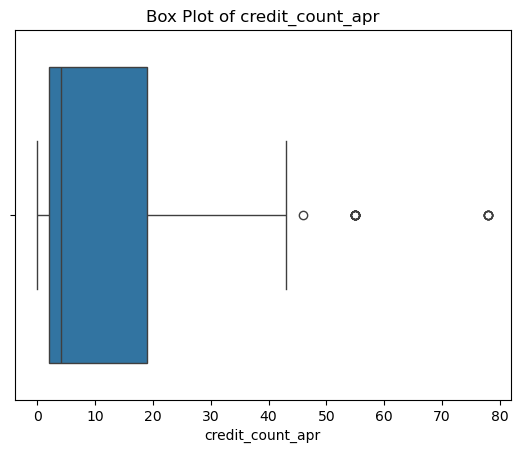

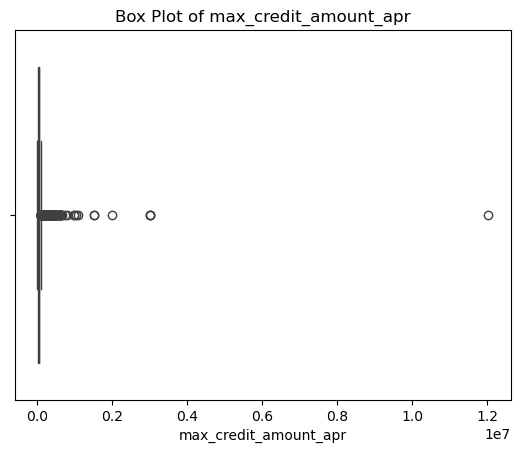

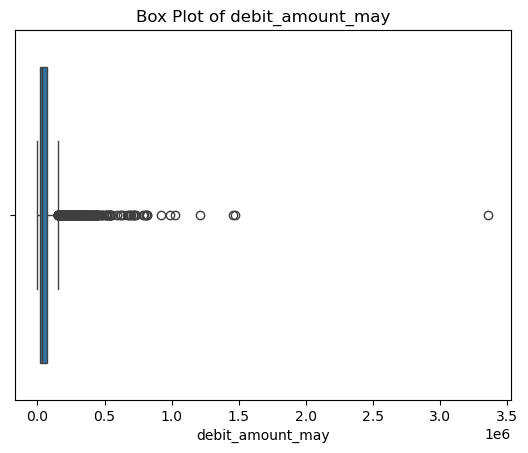

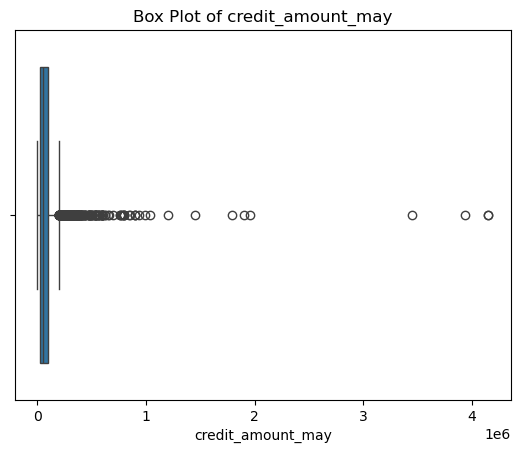

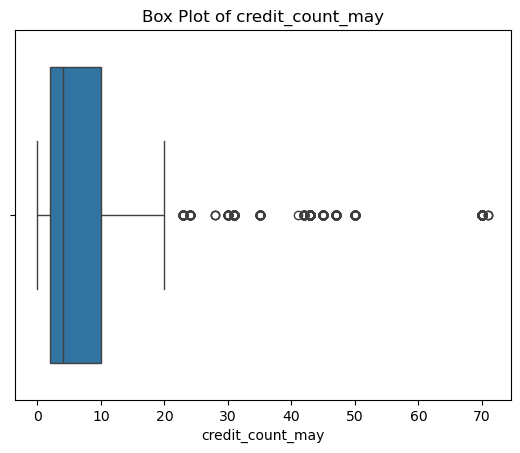

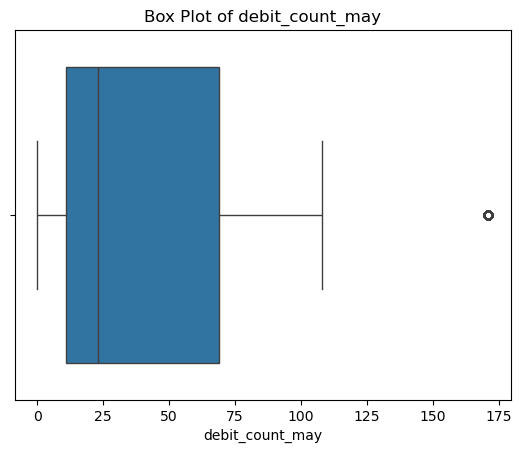

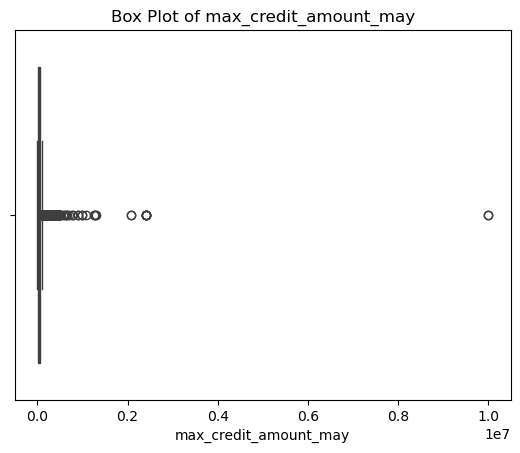

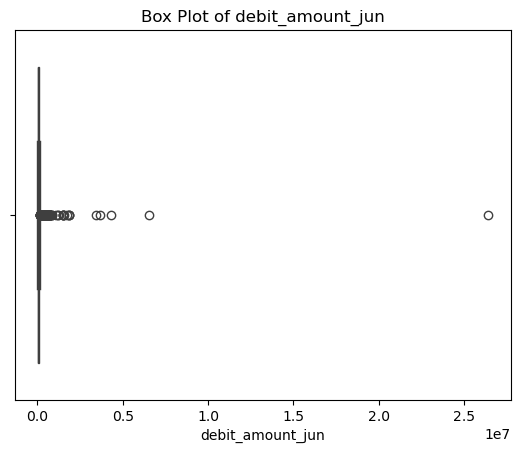

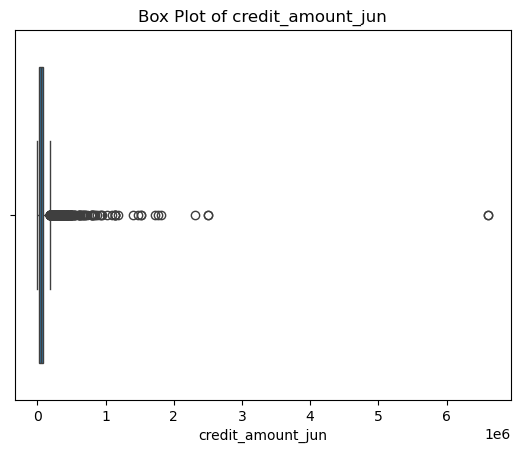

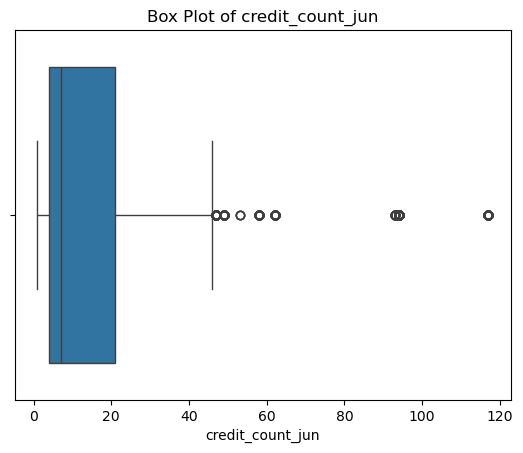

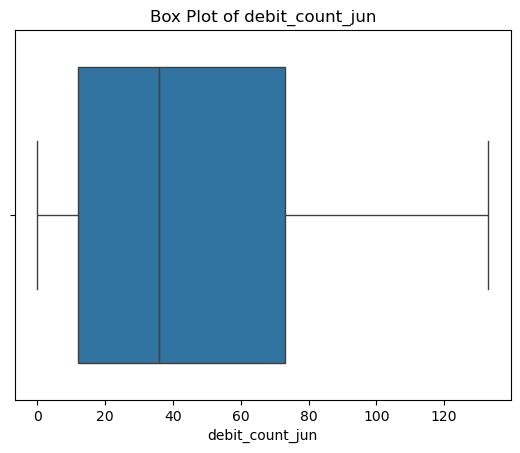

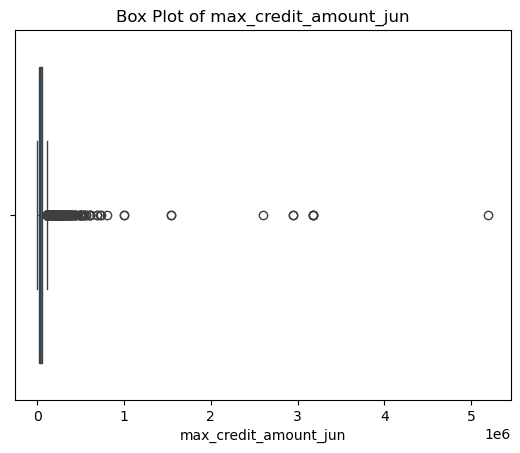

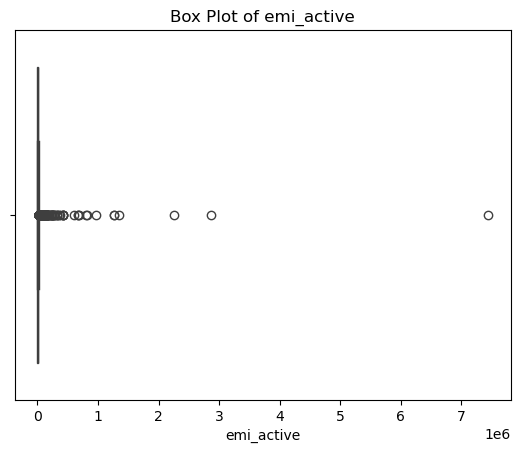

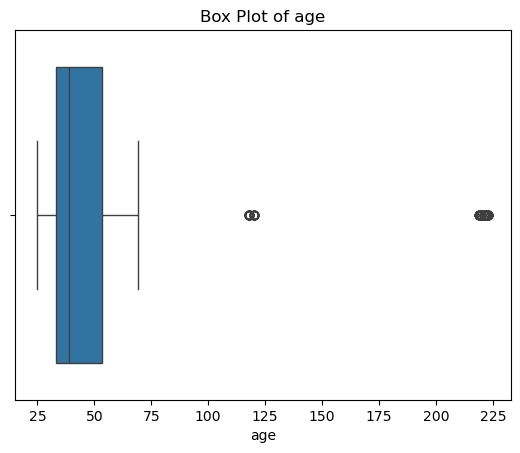

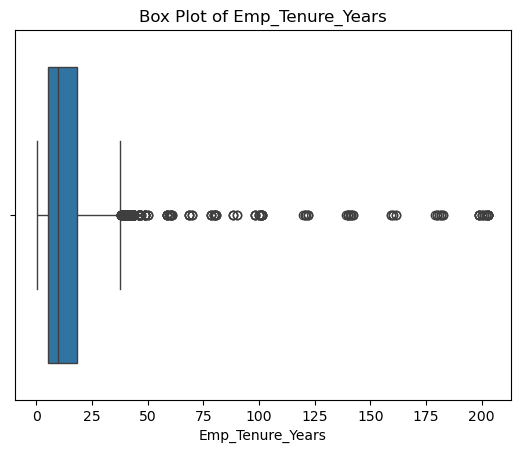

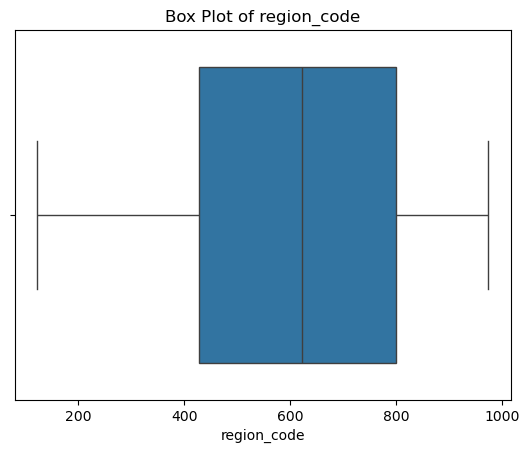

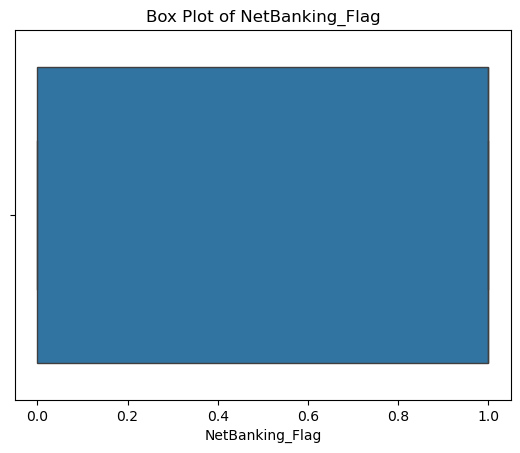

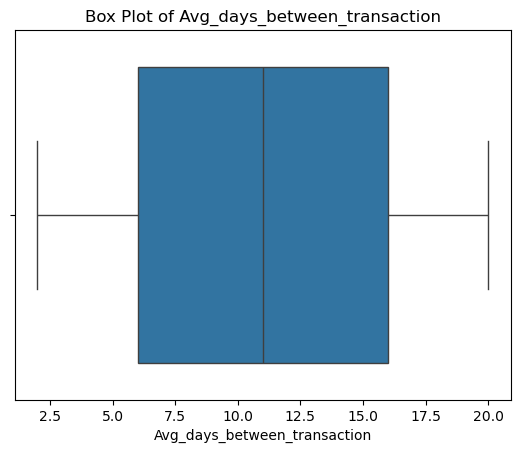

In [573]:
for i in pred_customer_df.select_dtypes(include=["number"]).columns:
    sns.boxplot(x=pred_customer_df[i])  
    plt.title(f"Box Plot of {i}")  
    plt.show()

There are outlier in every column.

# Outlier Capping

In [576]:
def cap_outliers(df):
    df = df.copy()  # To avoid modifying the original DataFrame
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df  
customer_df=cap_outliers(customer_df)
pred_customer_df= cap_outliers(pred_customer_df)

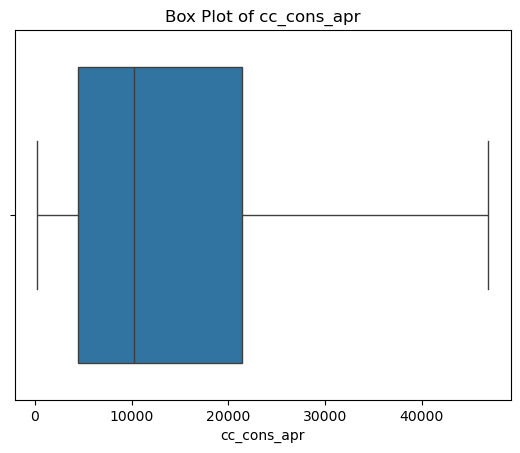

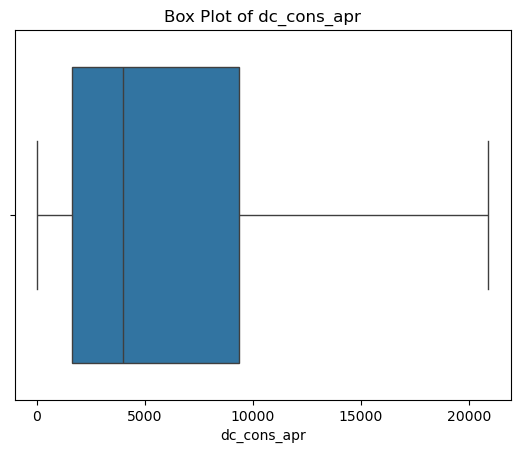

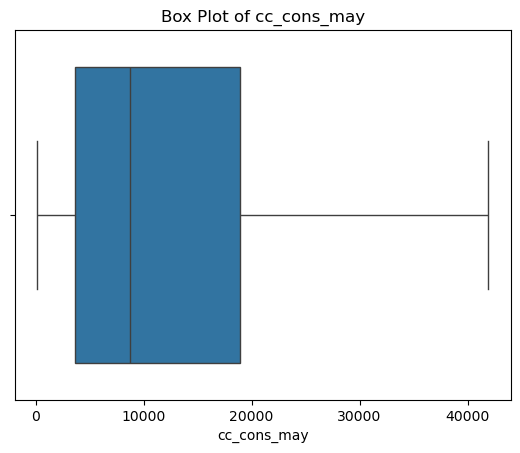

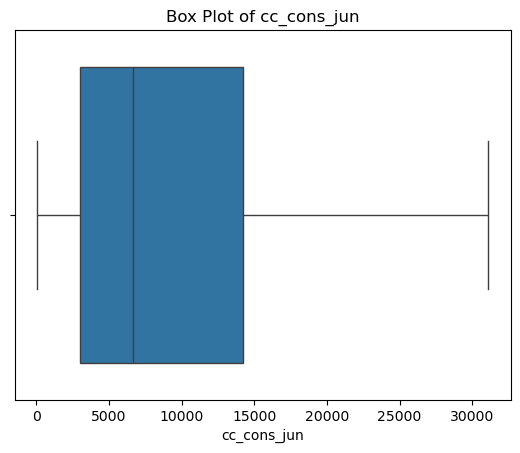

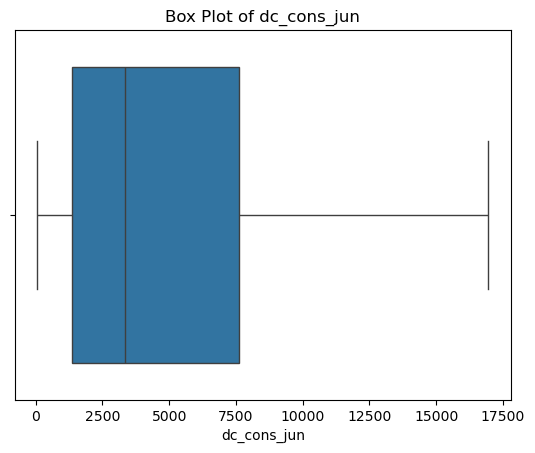

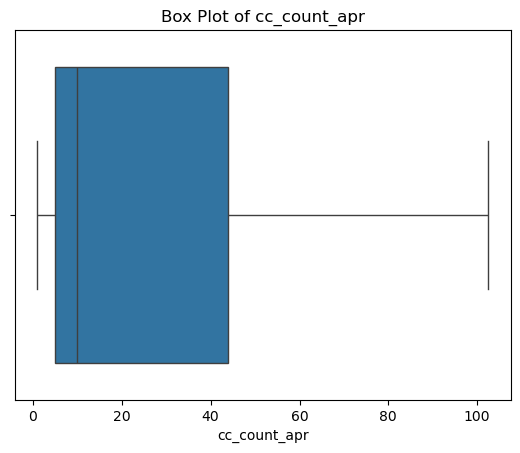

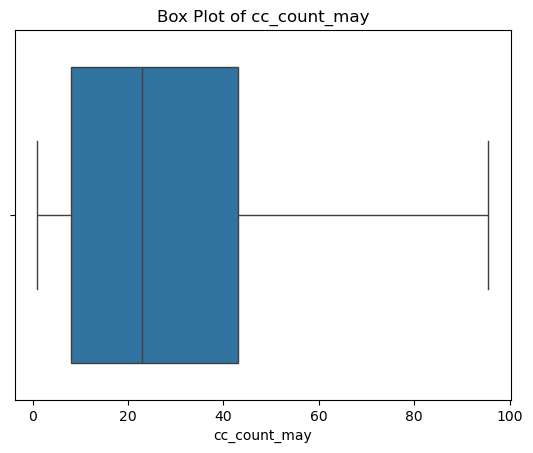

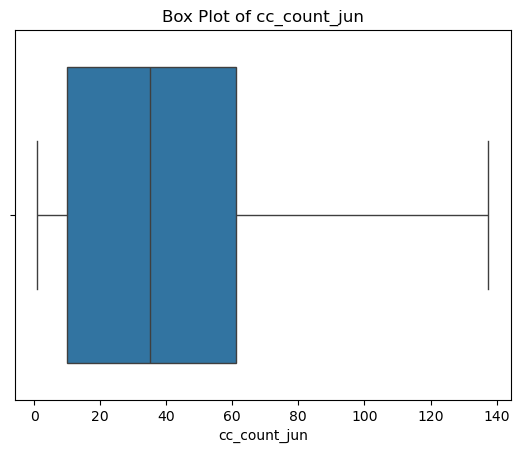

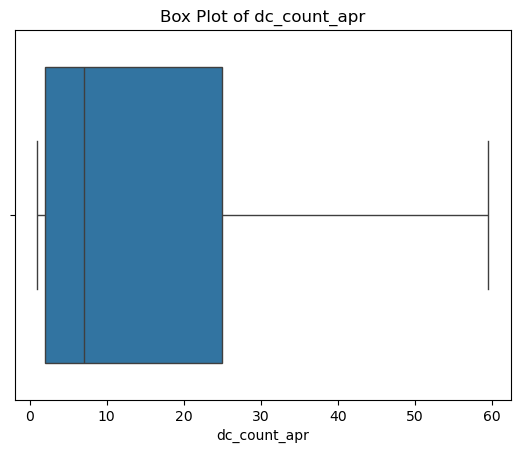

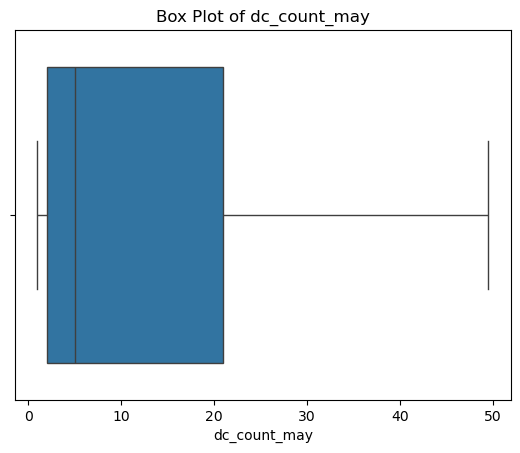

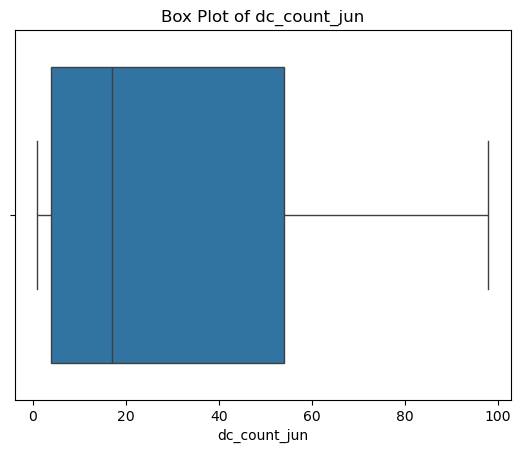

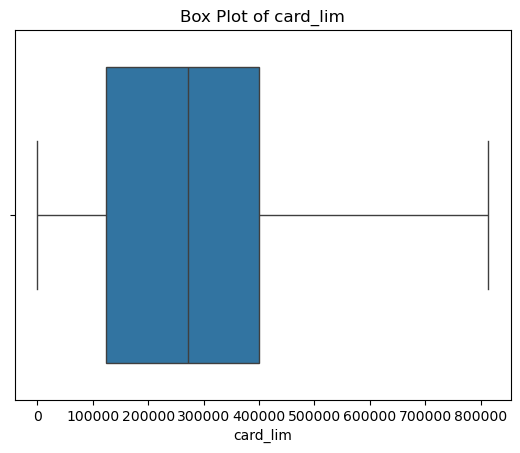

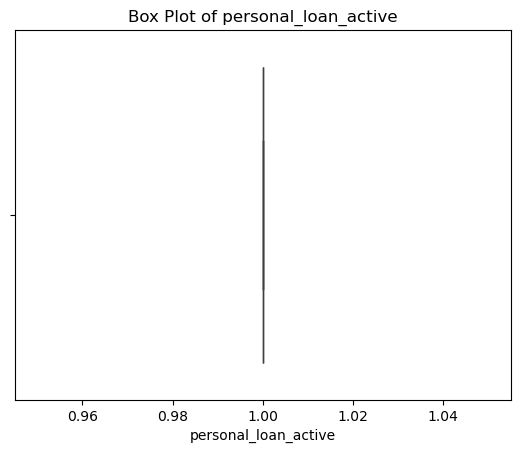

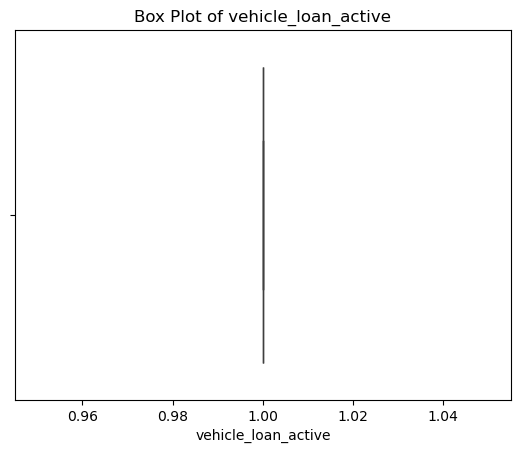

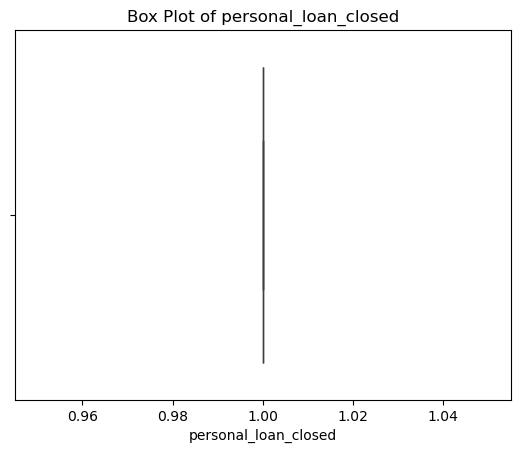

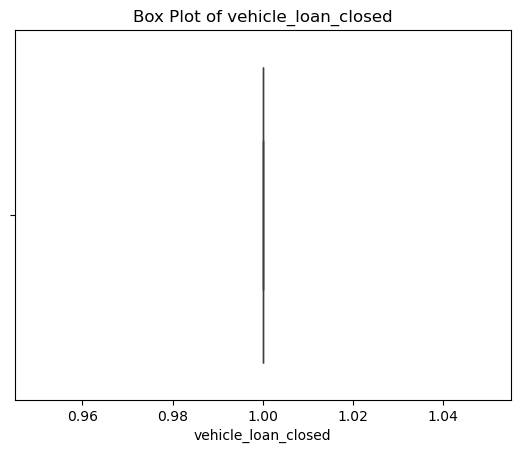

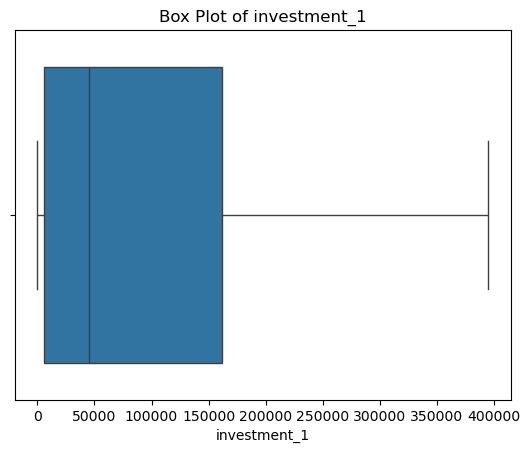

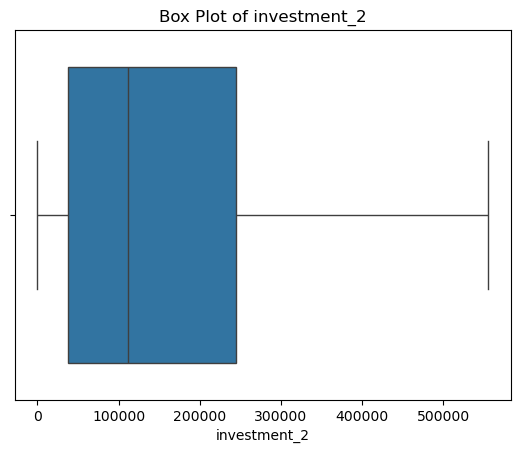

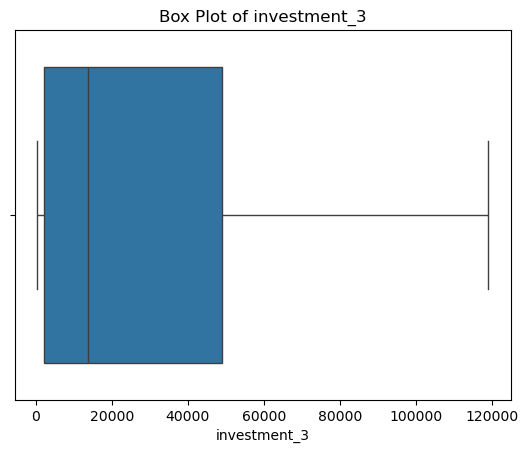

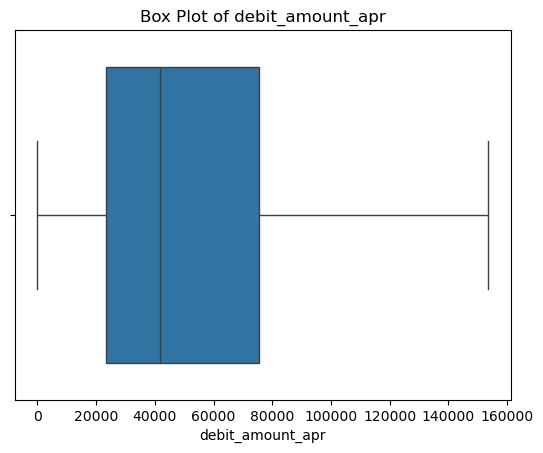

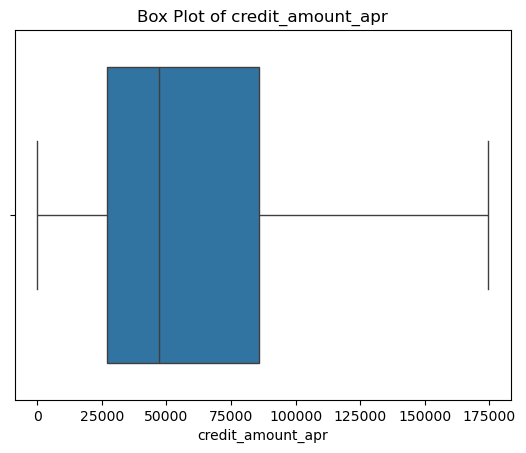

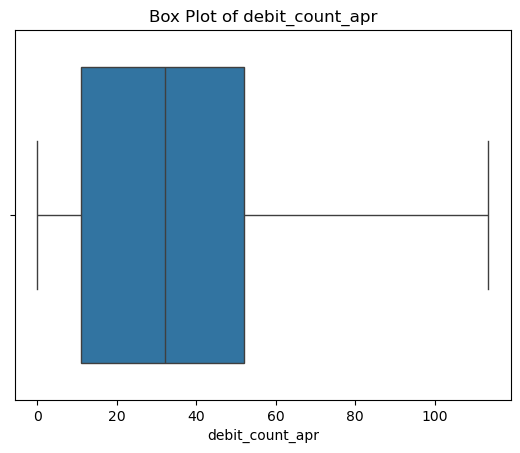

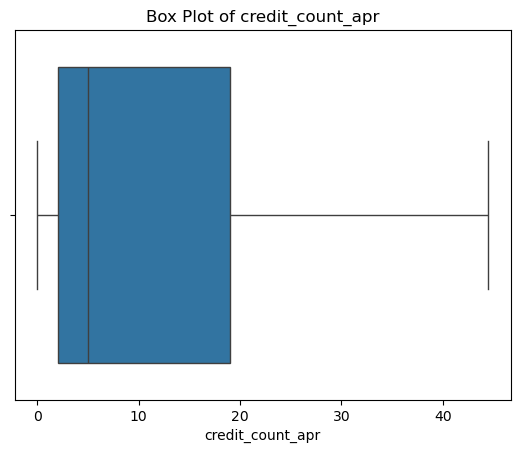

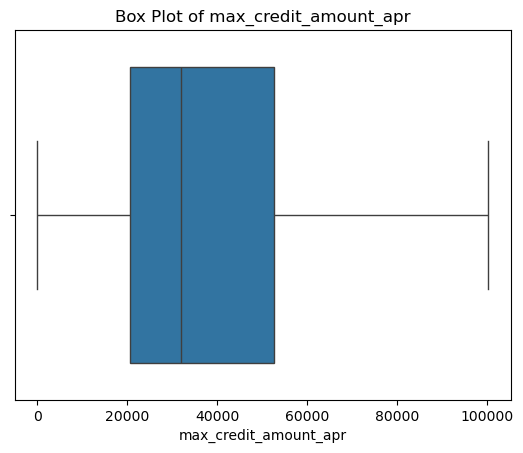

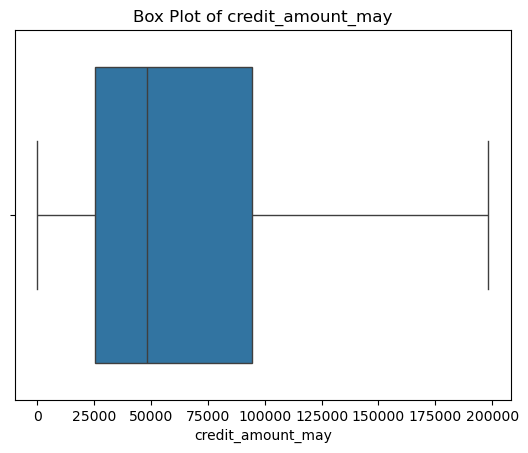

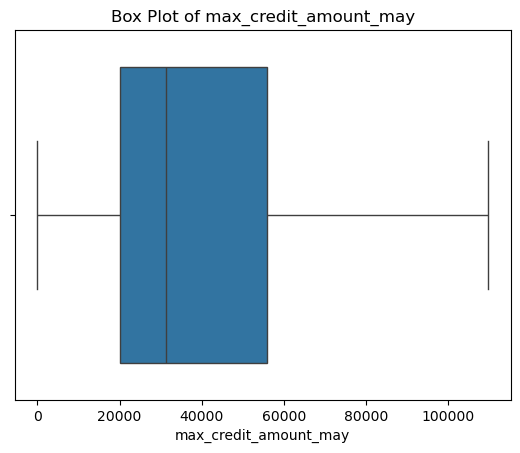

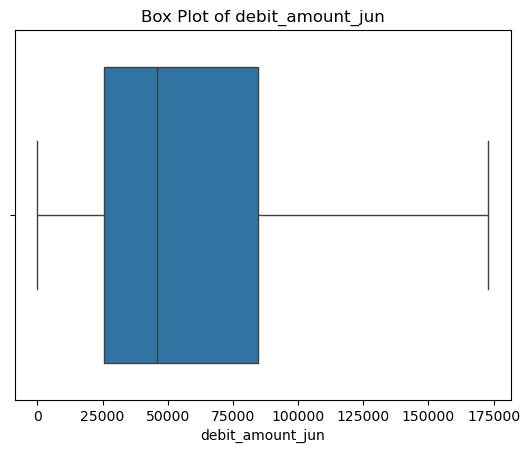

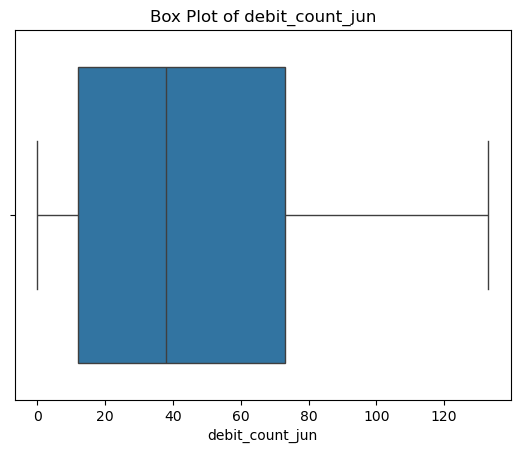

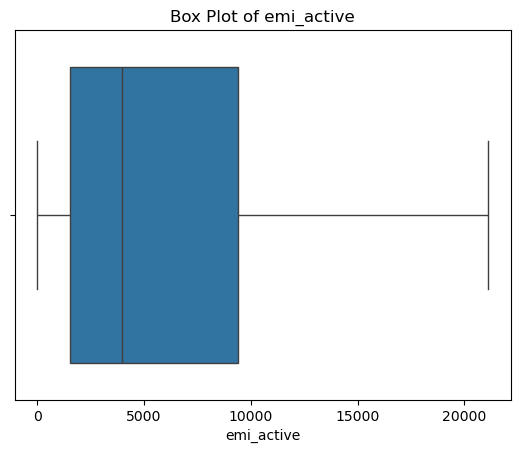

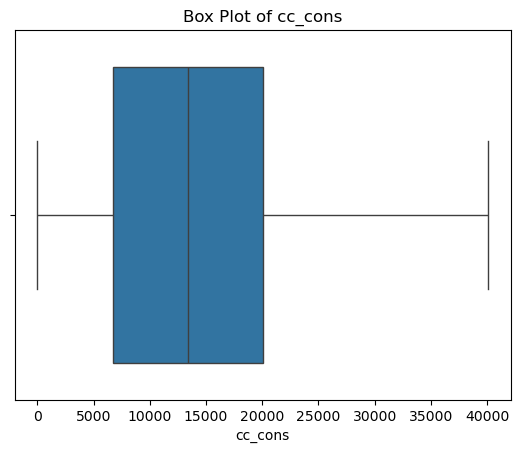

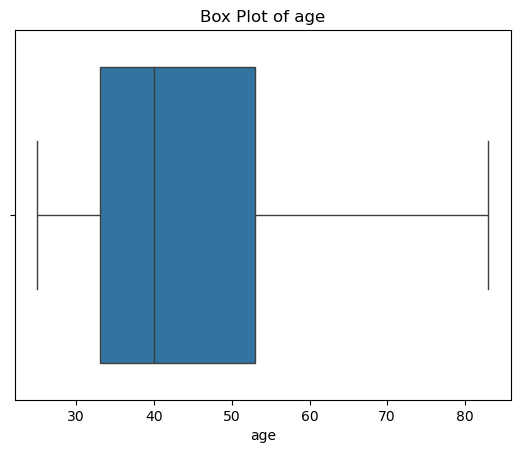

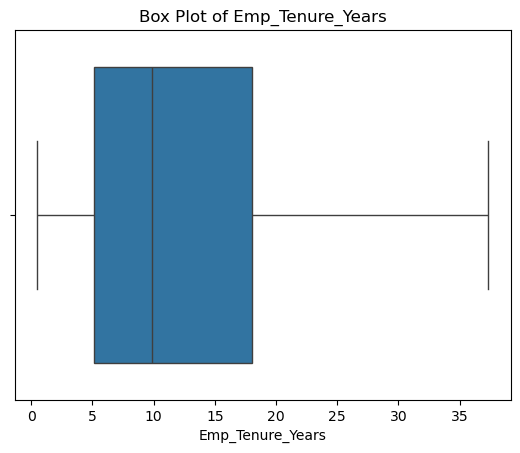

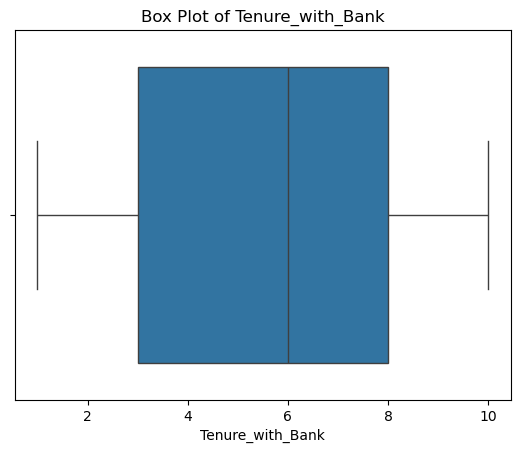

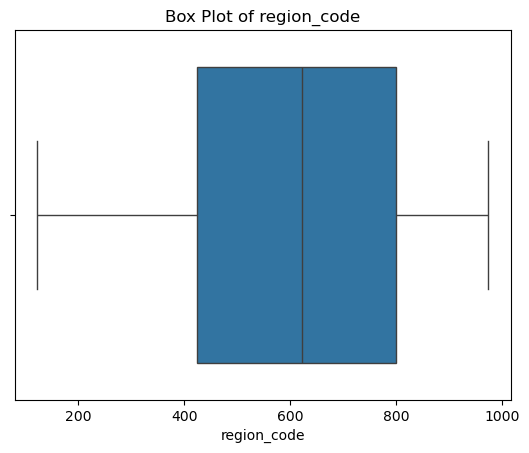

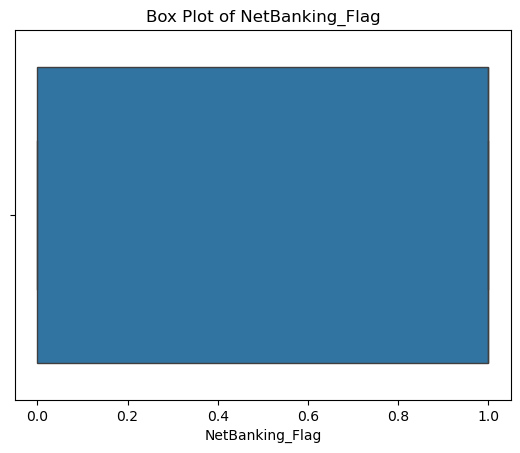

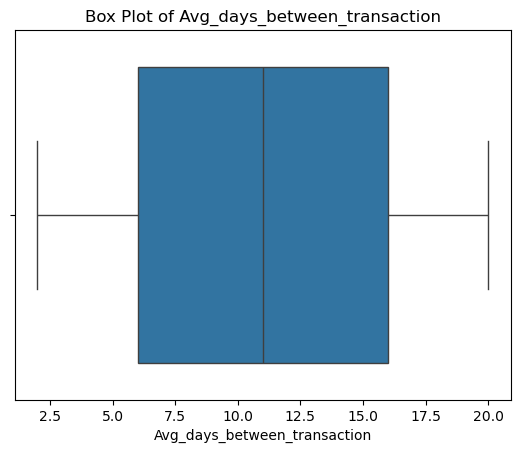

In [577]:
for i in customer_df.select_dtypes(include=["number"]).columns:
    sns.boxplot(x=customer_df[i])  
    plt.title(f"Box Plot of {i}")  
    plt.show()

No more Outliers in any column in customer_df

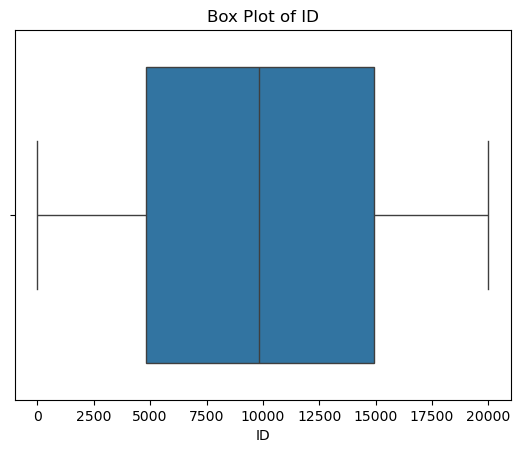

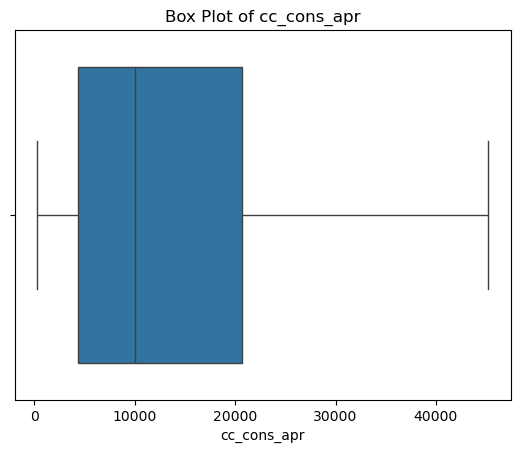

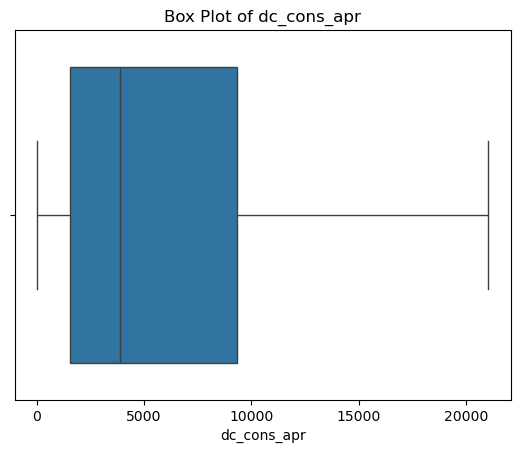

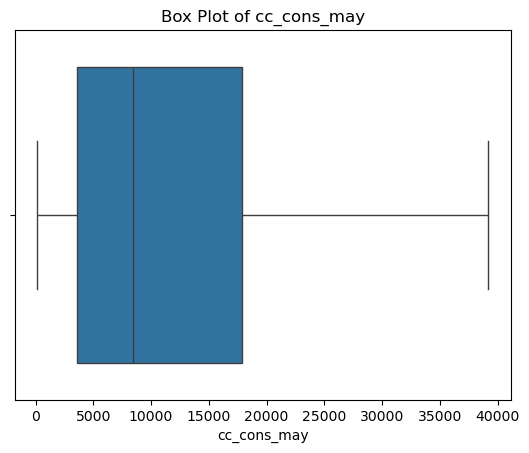

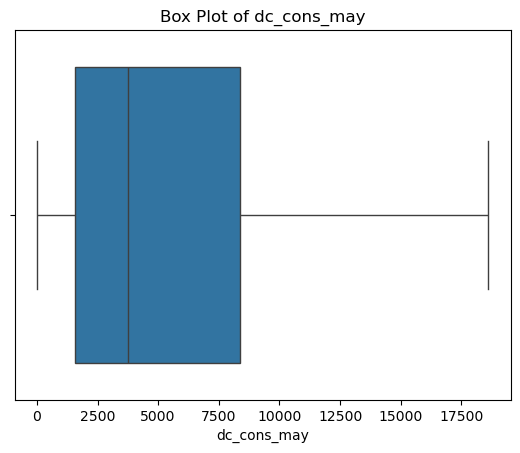

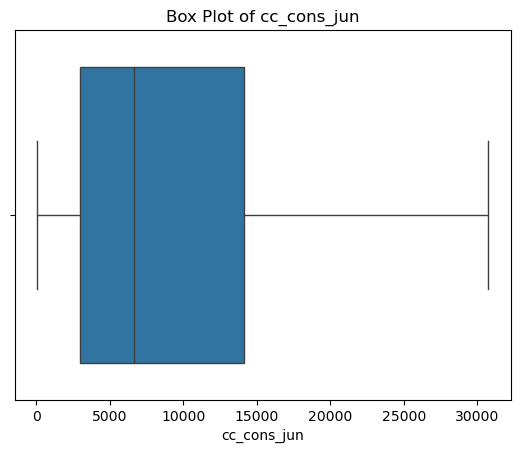

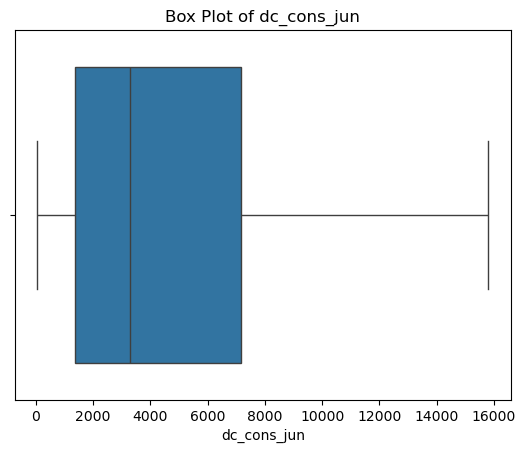

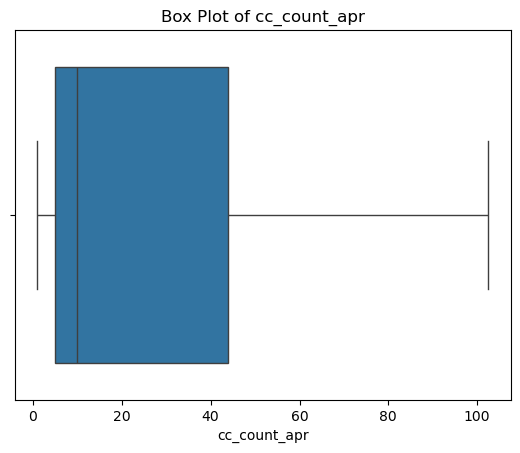

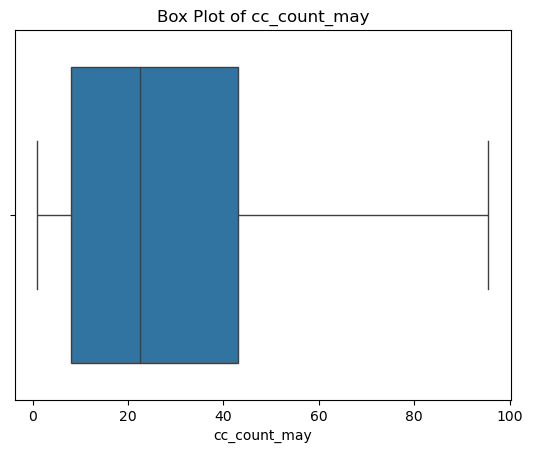

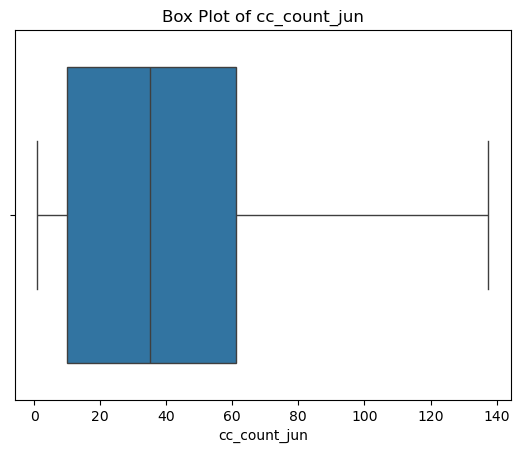

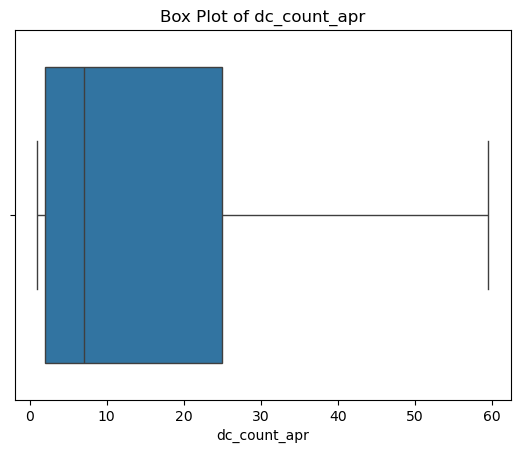

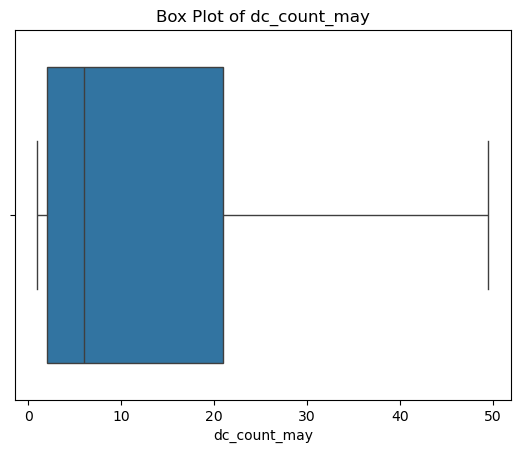

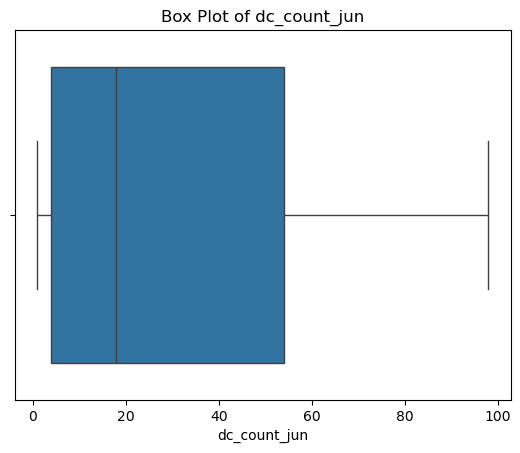

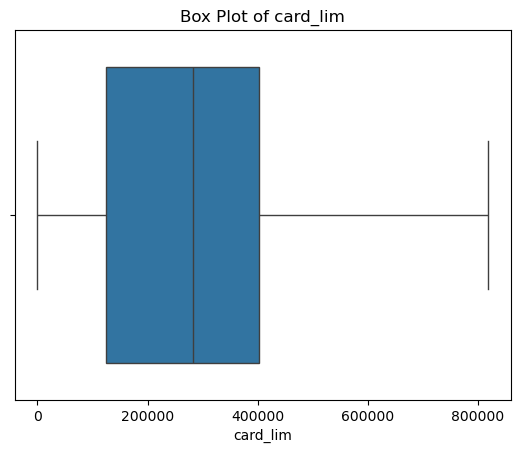

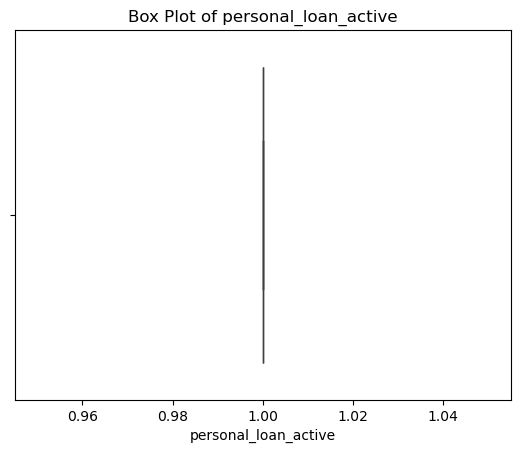

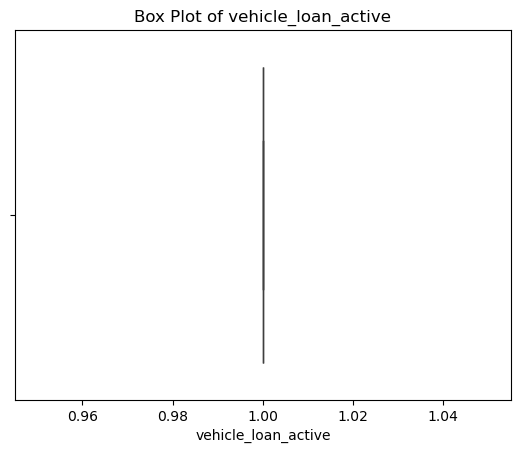

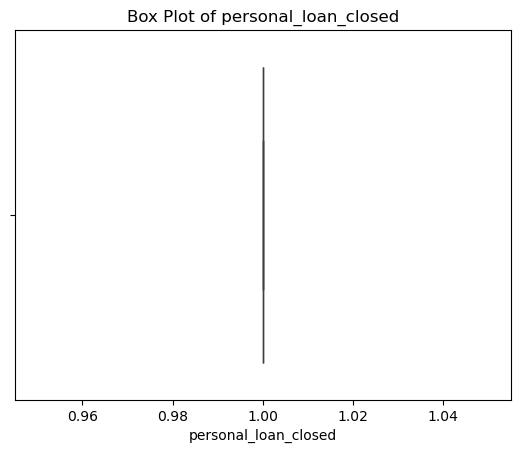

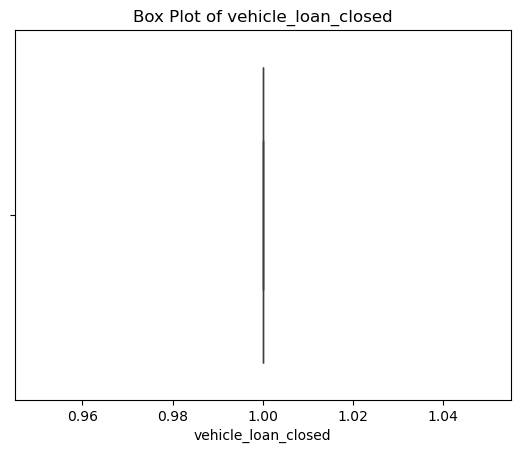

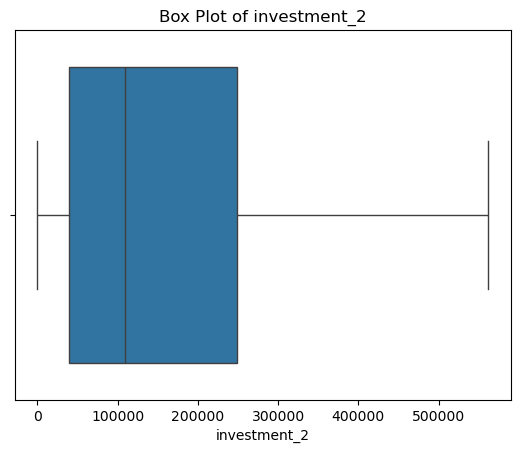

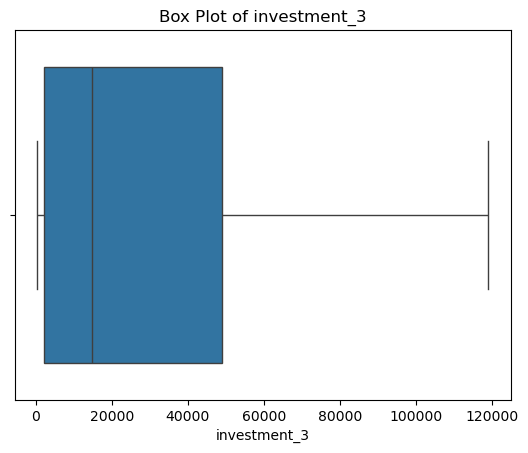

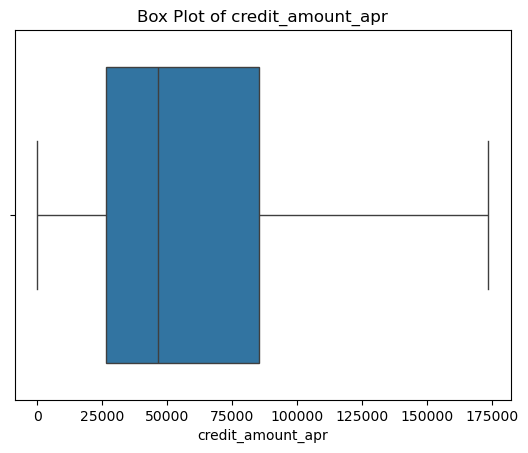

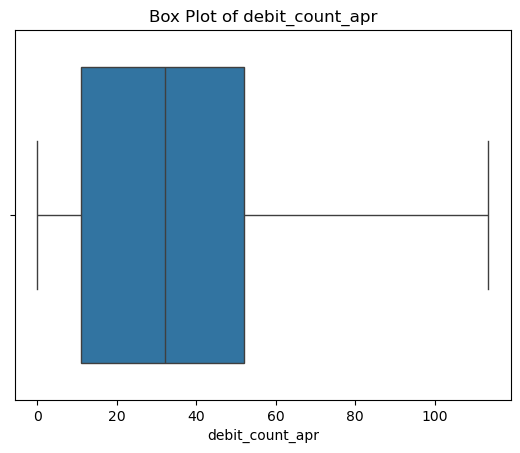

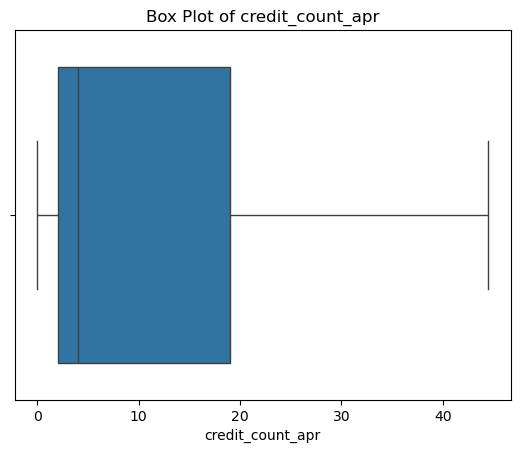

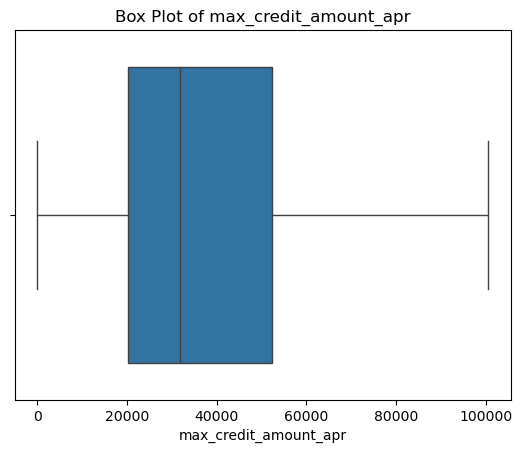

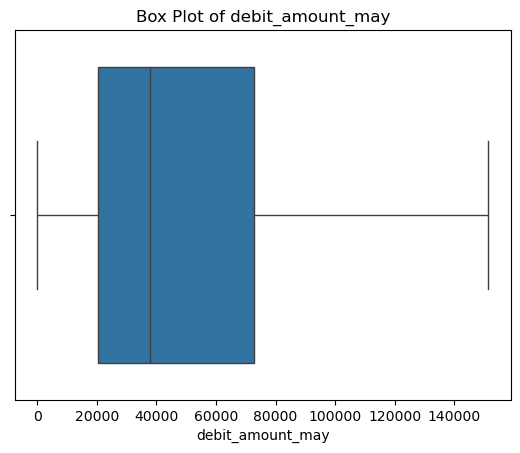

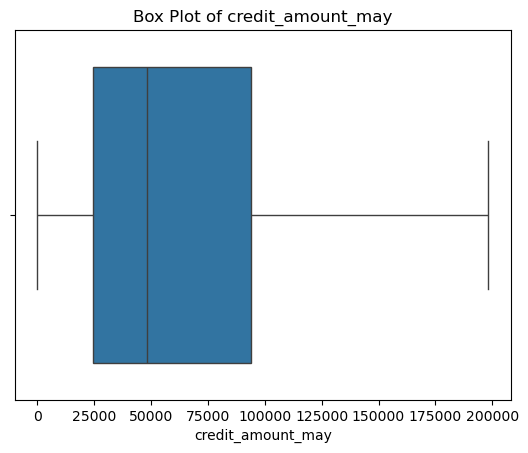

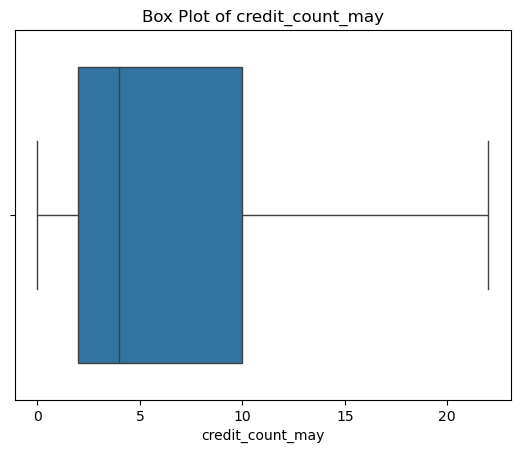

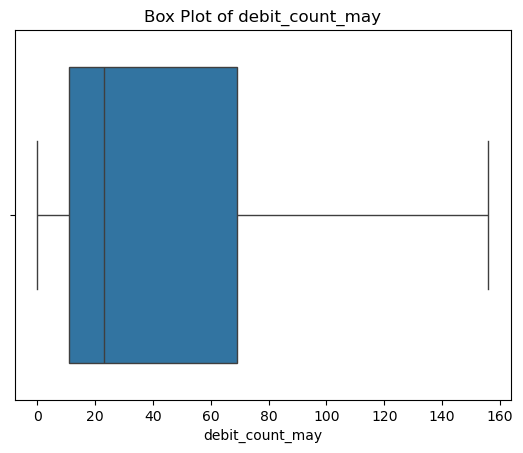

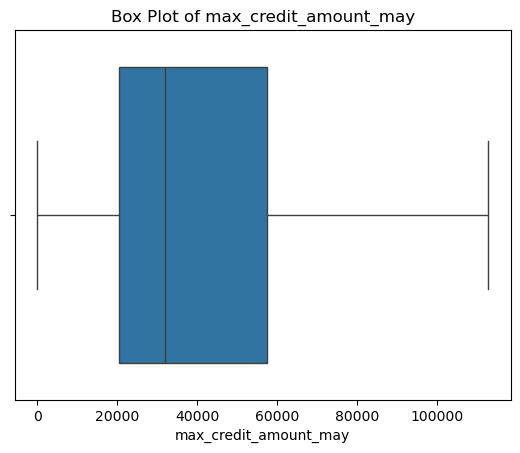

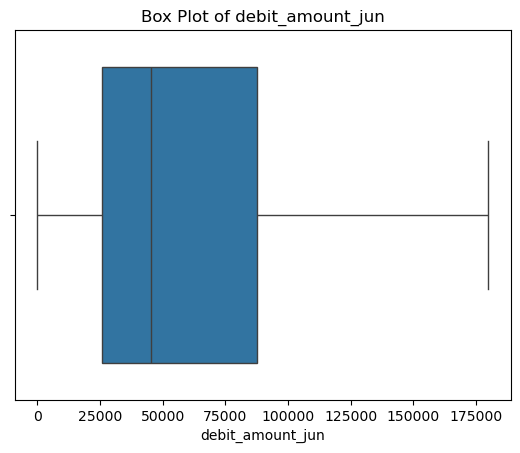

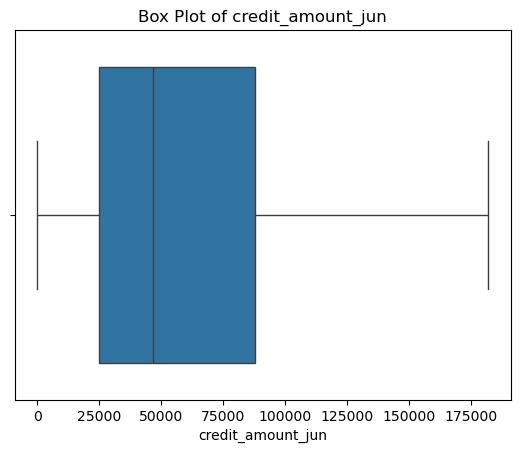

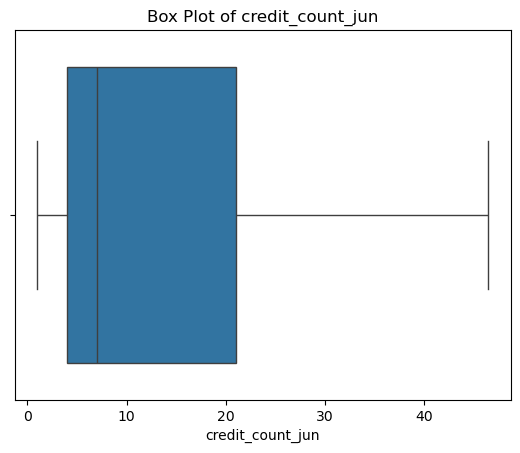

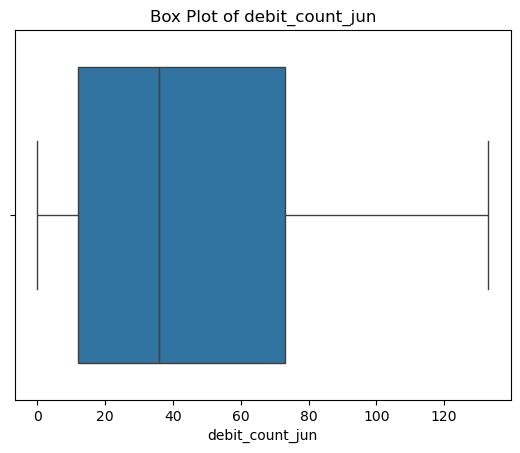

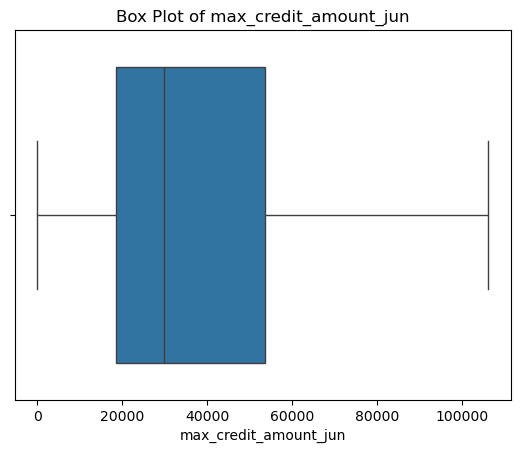

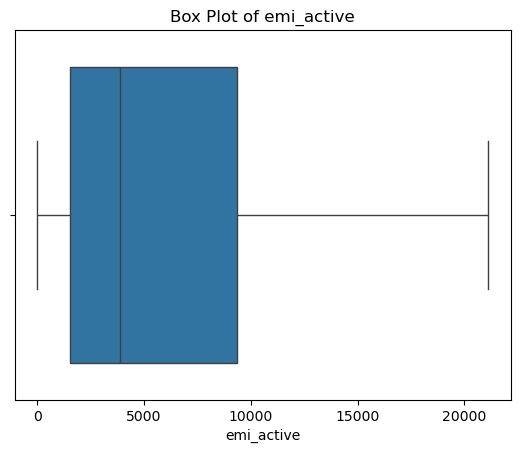

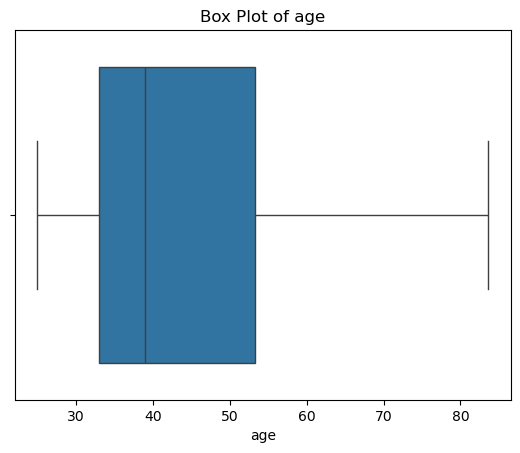

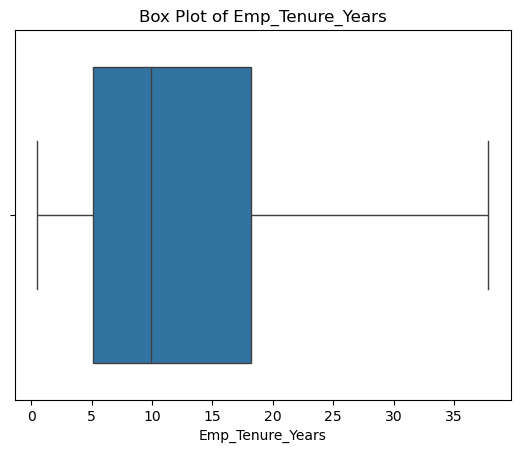

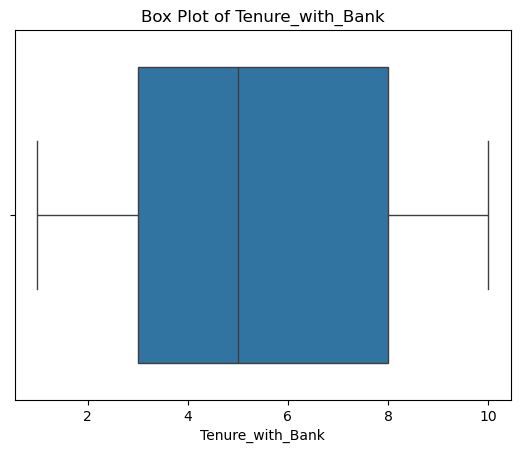

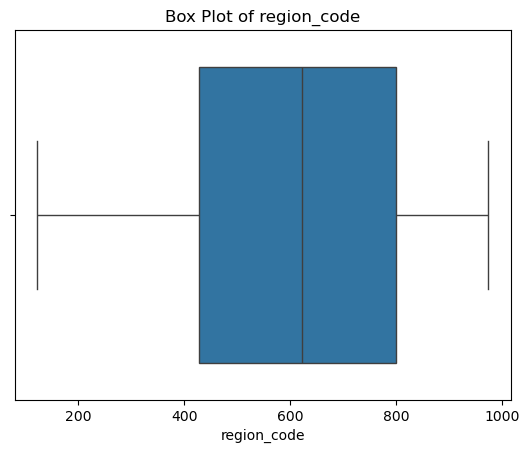

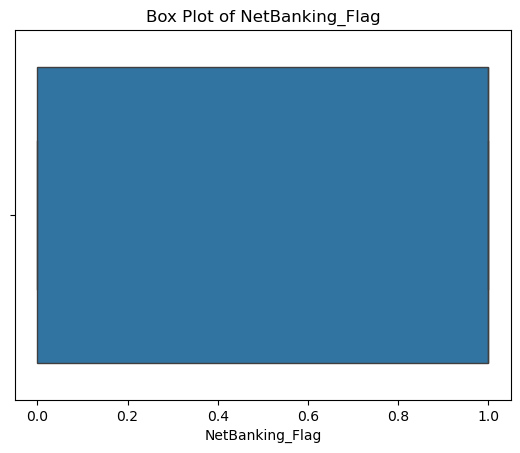

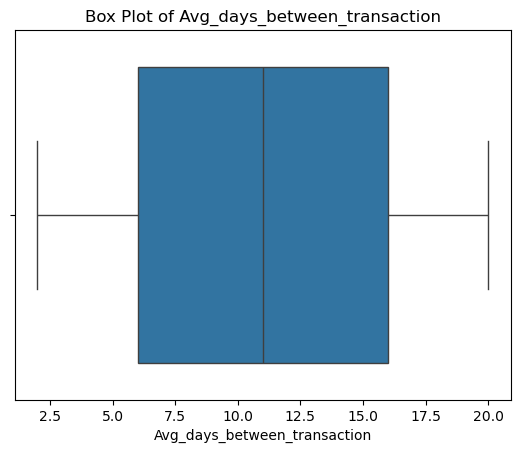

In [579]:
for i in pred_customer_df.select_dtypes(include=["number"]).columns:
    sns.boxplot(x=pred_customer_df[i])  
    plt.title(f"Box Plot of {i}")  
    plt.show()

No more Outliers in any column in pred_customer_df

## Numerical Variables

In [582]:
customer_df_num = customer_df.select_dtypes(include=['number'])
pred_customer_df_num = pred_customer_df.select_dtypes(include=['number'])
print(customer_df_num.shape)
print(pred_customer_df_num.shape)

(15000, 44)
(5000, 44)


# Summary Statistics
 creating a data audit report

In [584]:
customer_df_num.describe()

cc_cons_apr   dc_cons_apr   cc_cons_may   dc_cons_may   cc_cons_jun  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean   15129.412544   6411.257438  13313.292133   5775.282611  10005.882386   
std    13871.489616   6279.397442  12514.456205   5393.669175   9166.476129   
min      253.000000     19.350000    157.000000     22.000000     65.000000   
25%     4411.027500   1634.000000   3638.000000   1643.500000   3004.500000   
50%    10288.100000   3996.900000   8695.030000   3820.500000   6655.250000   
75%    21405.000000   9339.020000  18951.300000   8212.000000  14247.000000   
max    46895.958750  20896.550000  41921.250000  18064.750000  31110.750000   

        dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  dc_count_apr  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    5302.145914     25.941167     30.450567     39.823033     16.980400   
std     5163.034487     30.561129     28.431789     32.358209     18.838543   
min       62.000000      1.000000      1.000000      1.000000      1.000000   
25%     1358.750000      5.000000      8.000000     10.000000      2.000000   
50%     3327.000000     10.000000     23.000000     35.000000      7.000000   
75%     7597.000000     44.000000     43.000000     61.000000     25.000000   
max    16954.375000    102.500000     95.500000    137.500000     59.500000   

       ...  debit_count_jun  max_credit_amount_jun    emi_active  \
count  ...     15000.000000           15000.000000  15000.000000   
mean   ...        44.647867           39770.055779   6493.876251   
std    ...        35.089082           29531.281917   6545.786143   
min    ...         0.000000               0.060000      0.000000   
25%    ...        12.000000           19038.000000   1549.770000   
50%    ...        38.000000           30425.500000   3955.280000   
75%    ...        73.000000           53211.000000   9376.390000   
max    ...       133.000000          104470.500000  21116.320000   

            cc_cons           age  Emp_Tenure_Years  Tenure_with_Bank  \
count  15000.000000  15000.000000      15000.000000      15000.000000   
mean   17048.784083     44.104667         13.067630          5.510000   
std    13403.133728     14.117490         10.326201          2.865783   
min        0.000000     25.000000          0.500000          1.000000   
25%     6768.000000     33.000000          5.100000          3.000000   
50%    13364.000000     40.000000          9.900000          6.000000   
75%    20105.750000     53.000000         18.000000          8.000000   
max    40112.375000     83.000000         37.350000         10.000000   

        region_code  NetBanking_Flag  Avg_days_between_transaction  
count  15000.000000     15000.000000                  15000.000000  
mean     598.415467         0.719533                     11.049600  
std      220.062345         0.449242                      5.492196  
min      123.000000         0.000000                      2.000000  
25%      424.000000         0.000000                      6.000000  
50%      623.000000         1.000000                     11.000000  
75%      799.000000         1.000000                     16.000000  
max      974.000000         1.000000                     20.000000  

[8 rows x 44 columns]

In [585]:
pred_customer_df_num.describe()

ID   cc_cons_apr   dc_cons_apr   cc_cons_may   dc_cons_may  \
count   5000.000000   5000.000000   5000.000000   5000.000000   5000.000000   
mean    9901.768800  14629.019875   6363.935130  12702.356475   5833.928854   
std     5812.772426  13352.671509   6331.251475  11766.568033   5570.671076   
min        0.000000    294.000000     41.000000    157.000000     22.000000   
25%     4822.750000   4290.135000   1563.730000   3618.000000   1582.000000   
50%     9829.000000  10032.000000   3875.500000   8416.270000   3740.200000   
75%    14940.500000  20660.260000   9354.650000  17850.937500   8392.000000   
max    19999.000000  45215.447500  21041.030000  39200.343750  18607.000000   

        cc_cons_jun   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  \
count   5000.000000   5000.000000   5000.000000   5000.000000   5000.000000   
mean    9819.135476   5090.227570     25.876800     30.264300     39.916400   
std     8964.195487   4838.338223     30.556084     28.556987     31.984648   
min       75.000000     62.000000      1.000000      1.000000      1.000000   
25%     2996.142500   1389.750000      5.000000      8.000000     10.000000   
50%     6671.235000   3302.000000     10.000000     22.500000     35.000000   
75%    14096.190000   7153.000000     44.000000     43.000000     61.000000   
max    30746.261250  15797.875000    102.500000     95.500000    137.500000   

       ...  credit_count_jun  debit_count_jun  max_credit_amount_jun  \
count  ...       5000.000000      5000.000000            5000.000000   
mean   ...         15.733600        44.172800           39804.584465   
std    ...         16.369252        35.055646           30043.206018   
min    ...          1.000000         0.000000               0.060000   
25%    ...          4.000000        12.000000           18587.250000   
50%    ...          7.000000        36.000000           29859.000000   
75%    ...         21.000000        73.000000           53638.000000   
max    ...         46.500000       133.000000          106214.125000   

         emi_active          age  Emp_Tenure_Years  Tenure_with_Bank  \
count   5000.000000  5000.000000       5000.000000       5000.000000   
mean    6427.355192    43.955700         13.183810          5.454200   
std     6498.213051    14.205542         10.582142          2.884296   
min        0.000000    25.000000          0.500000          1.000000   
25%     1529.960000    33.000000          5.100000          3.000000   
50%     3856.350000    39.000000          9.900000          5.000000   
75%     9369.155000    53.250000         18.200000          8.000000   
max    21127.947500    83.625000         37.850000         10.000000   

       region_code  NetBanking_Flag  Avg_days_between_transaction  
count  5000.000000      5000.000000                   5000.000000  
mean    600.595800         0.713400                     11.030200  
std     220.226016         0.452218                      5.444338  
min     123.000000         0.000000                      2.000000  
25%     428.000000         0.000000                      6.000000  
50%     623.000000         1.000000                     11.000000  
75%     799.000000         1.000000                     16.000000  
max     974.000000         1.000000                     20.000000  

[8 rows x 44 columns]

# Univariate Analysis:

Univariate major purpose is to describe; It takes data, summarizes that data and finds patterns in the data and to see distribution of variables

* Histogram (Distribution Shape)

1.customer_df

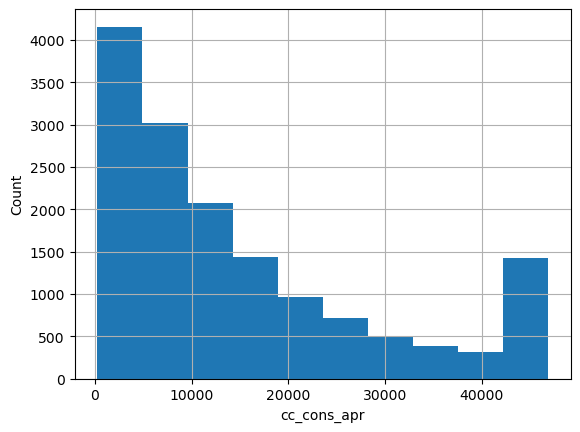

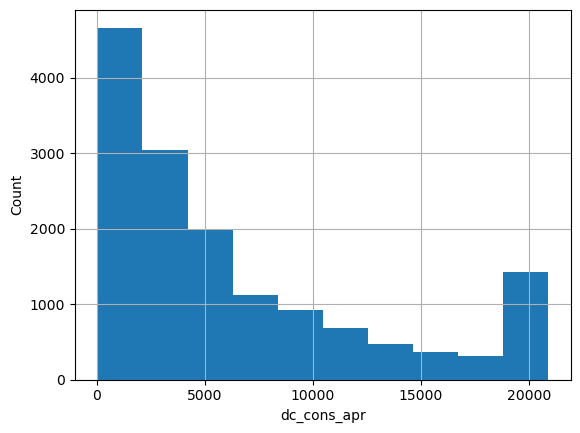

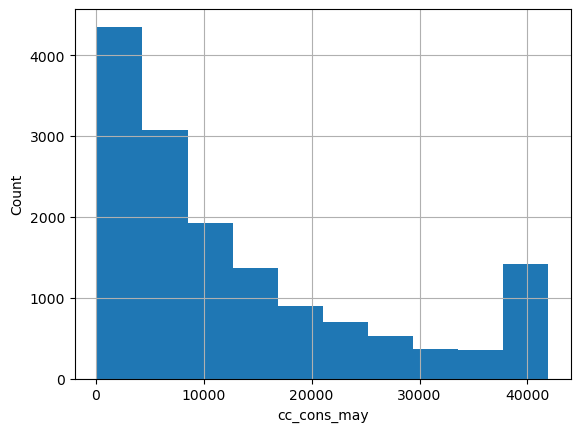

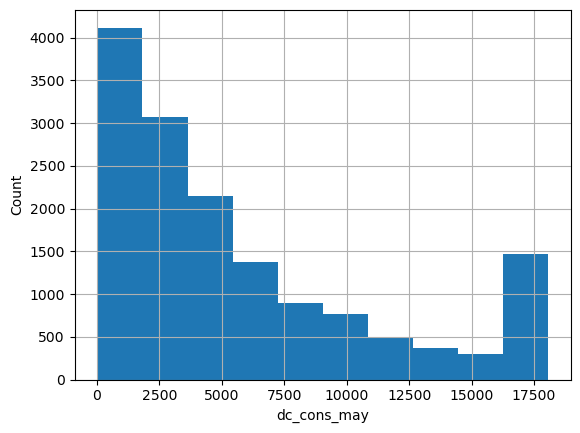

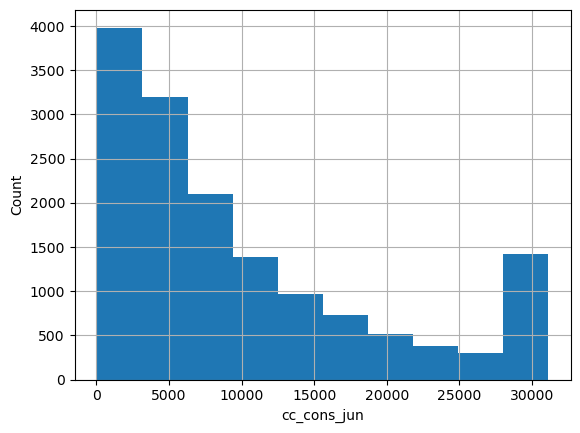

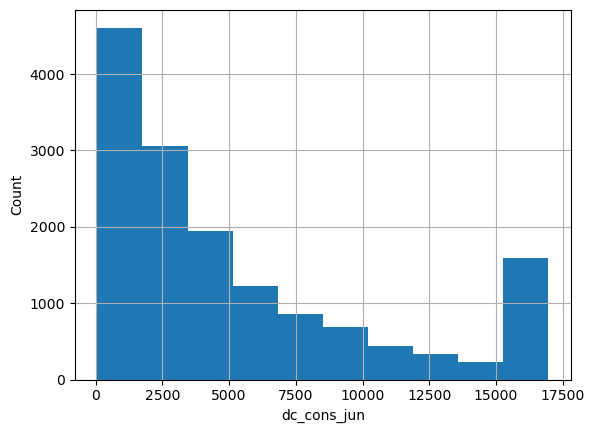

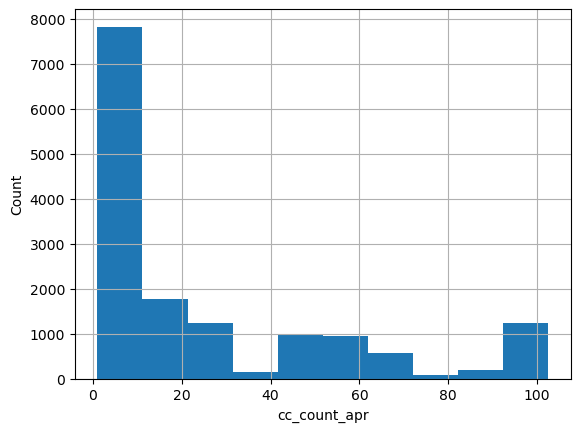

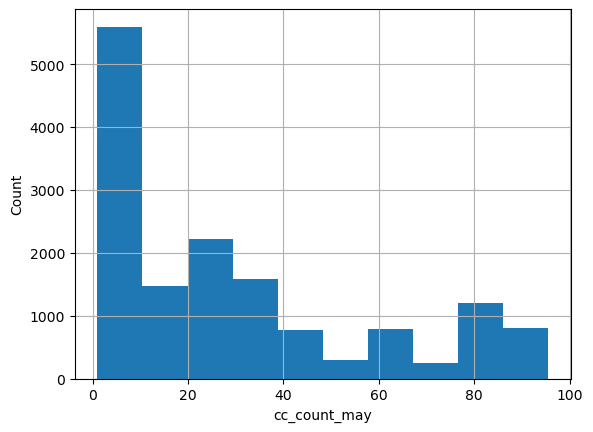

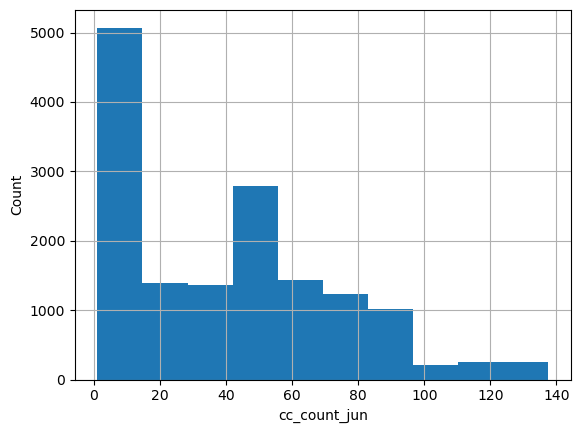

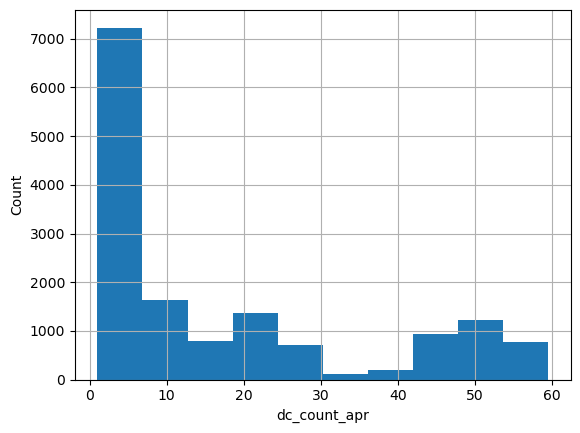

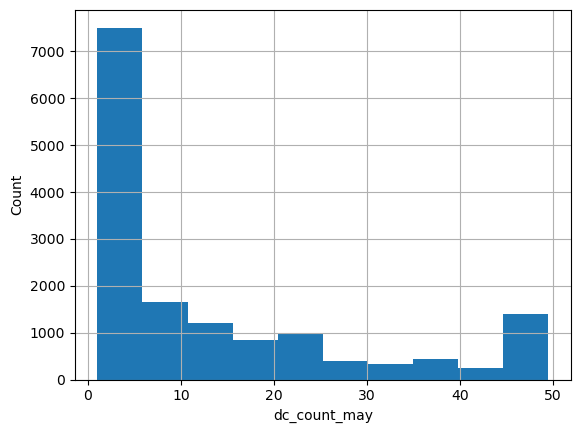

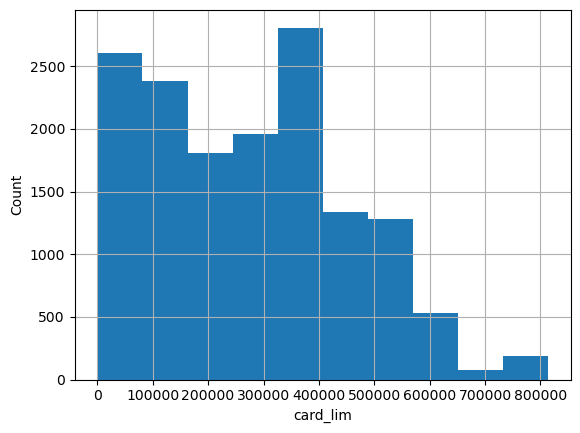

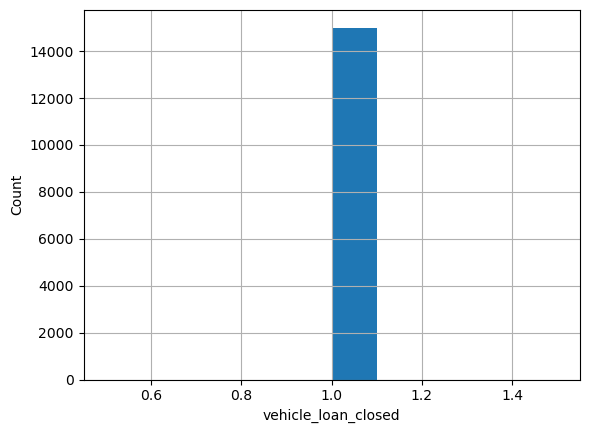

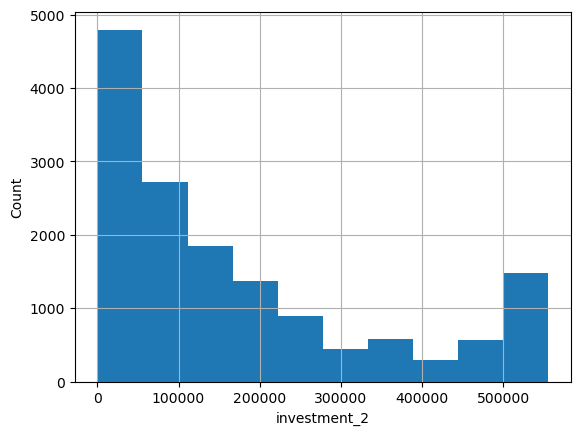

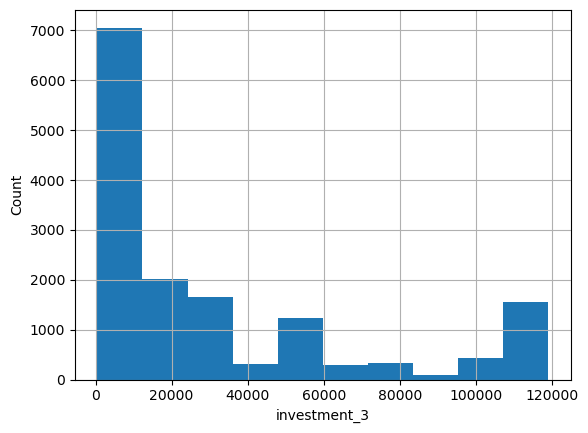

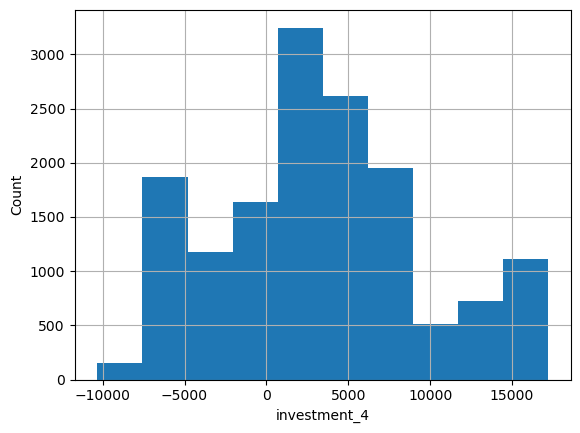

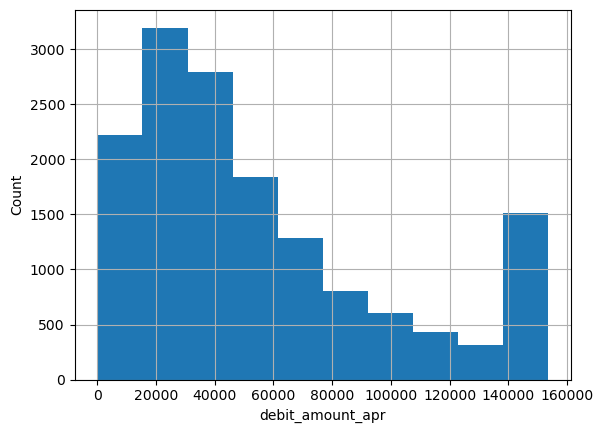

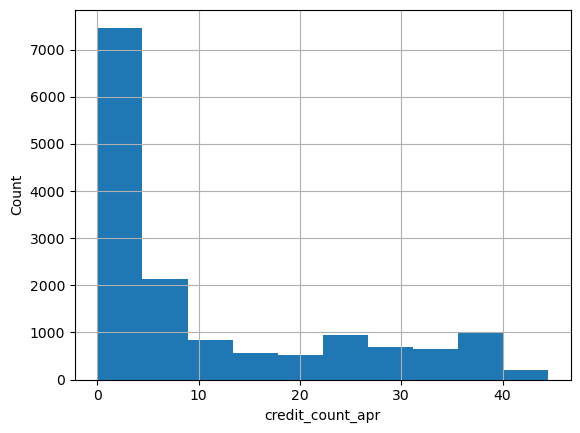

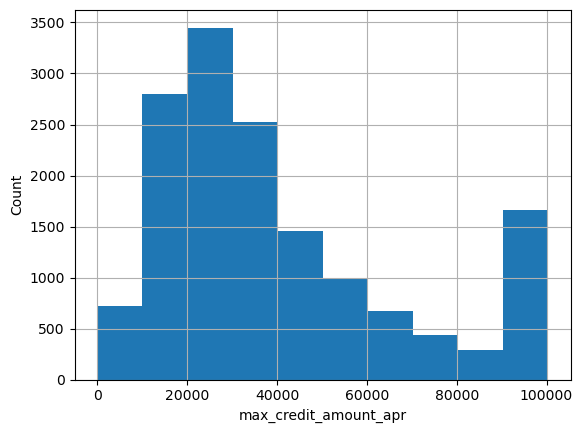

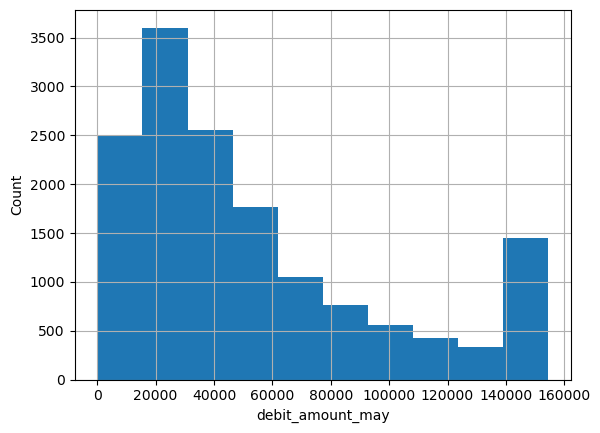

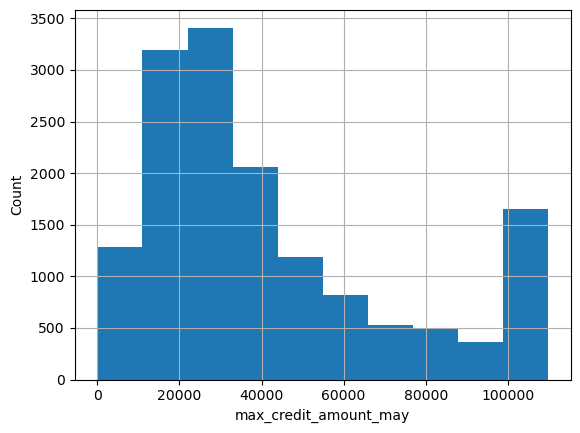

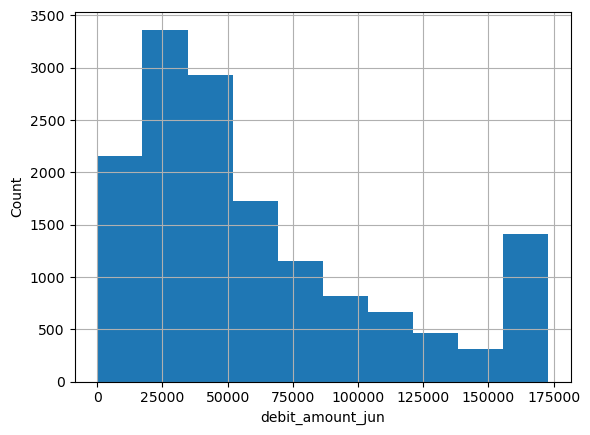

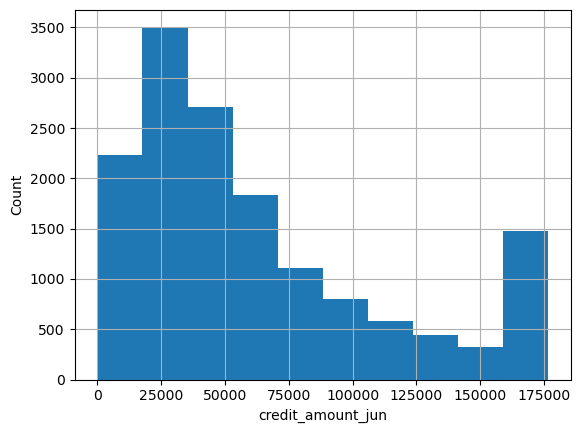

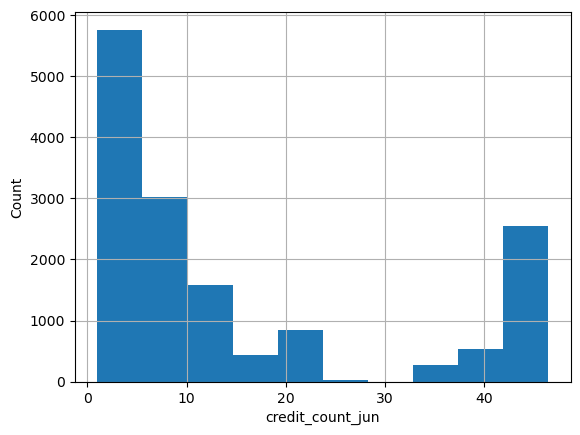

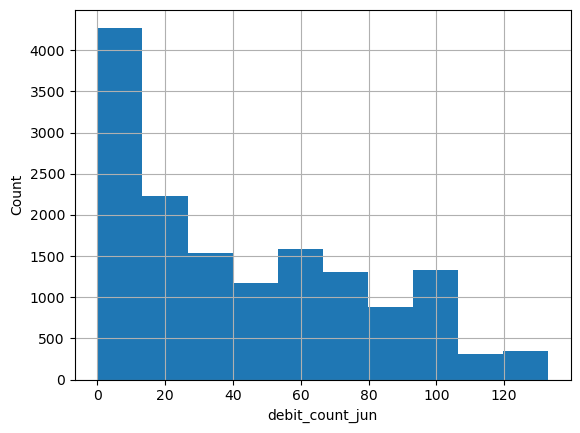

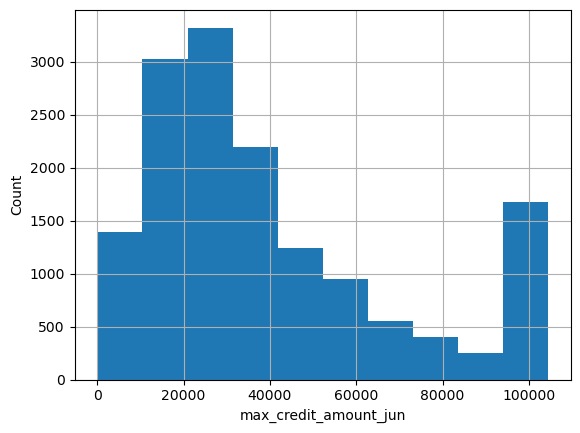

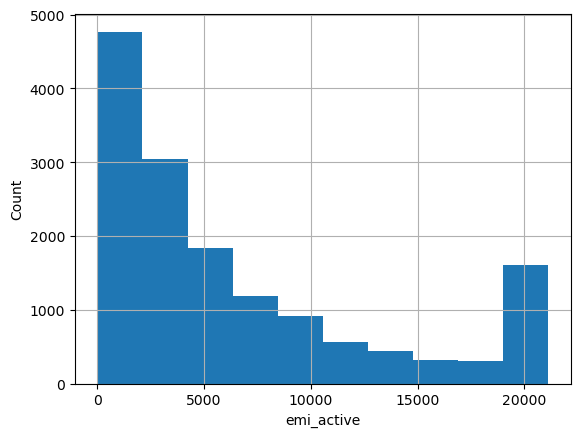

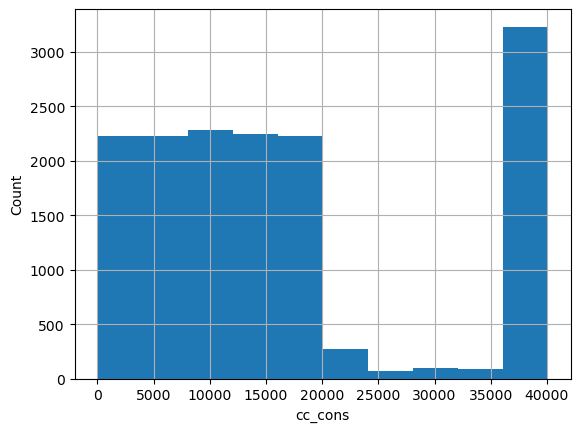

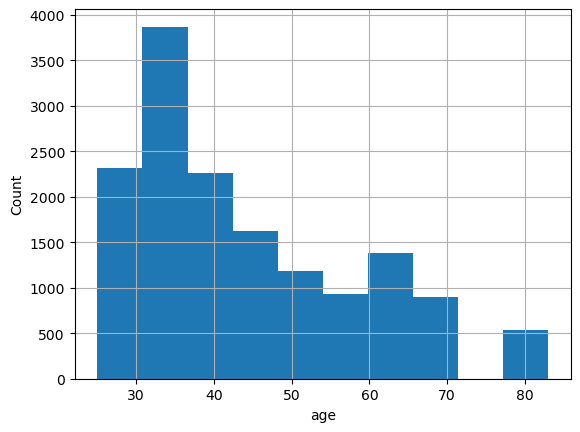

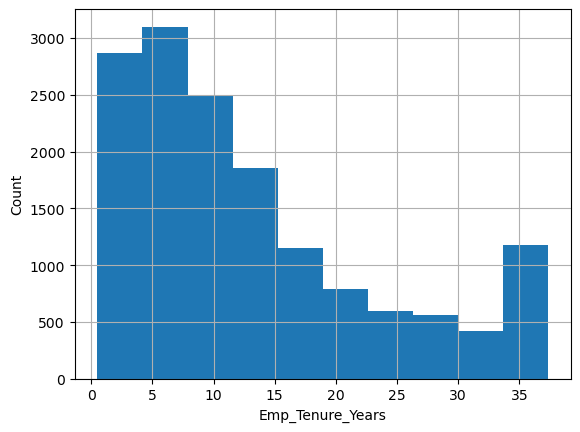

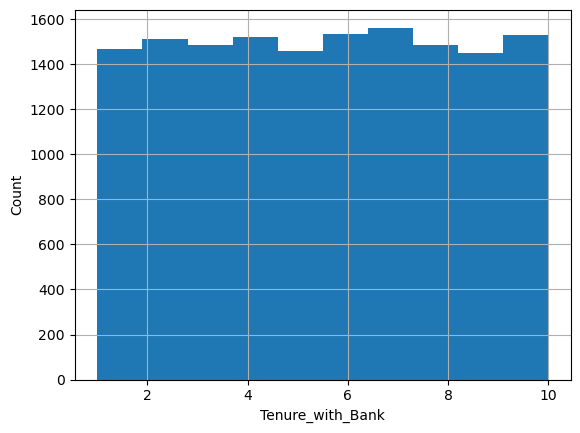

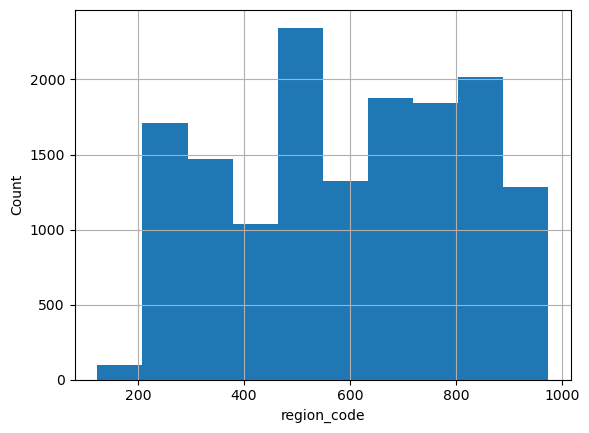

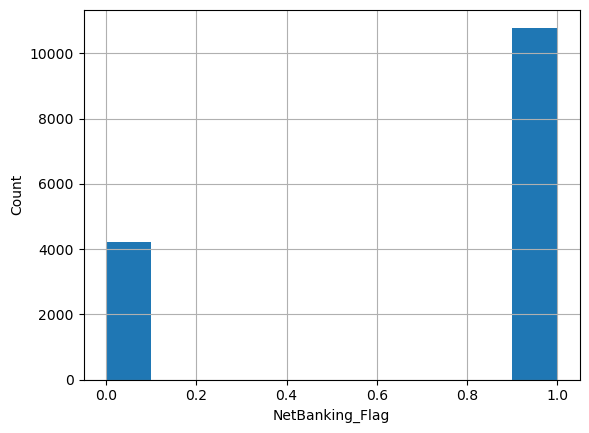

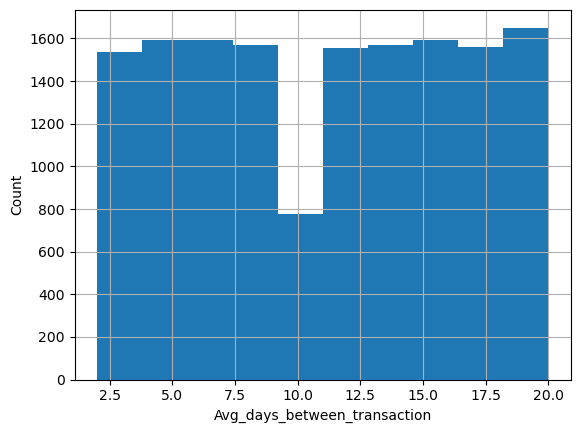

In [588]:
for i in customer_df_num.columns:
    customer_df_num[i].hist()
    plt.xlabel(str(i))
    plt.ylabel("Count")
    plt.show()

* Histogram (Distribution Shape)

2.pred_customer_df

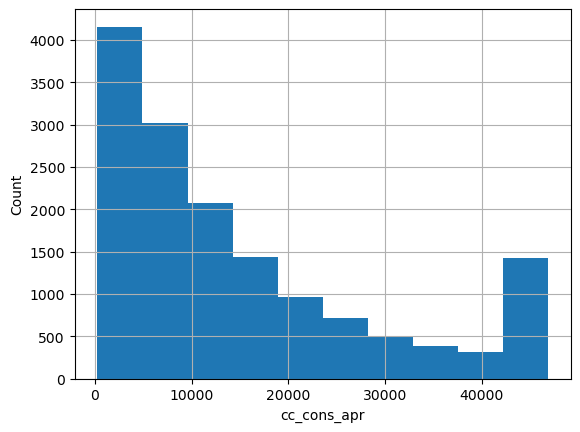

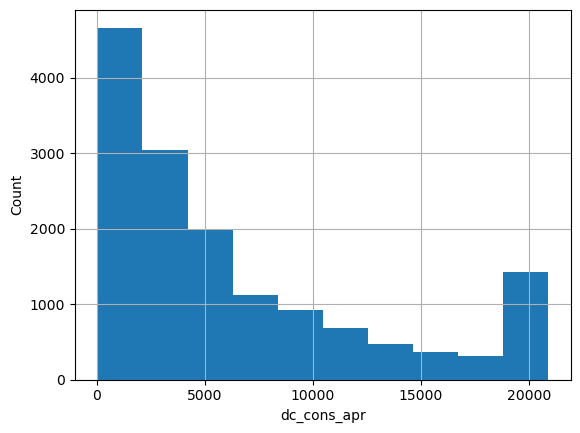

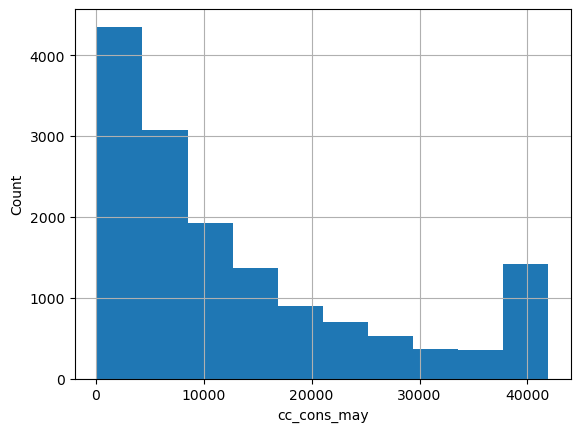

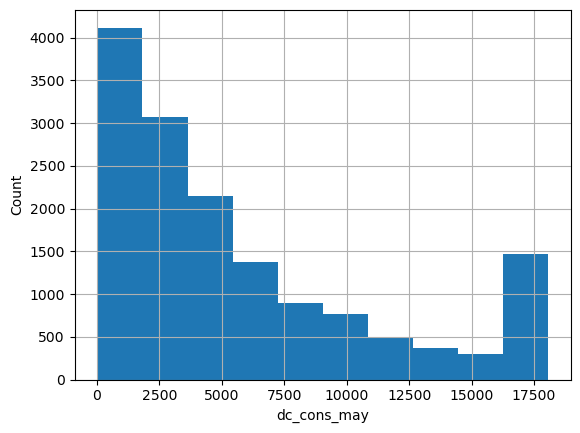

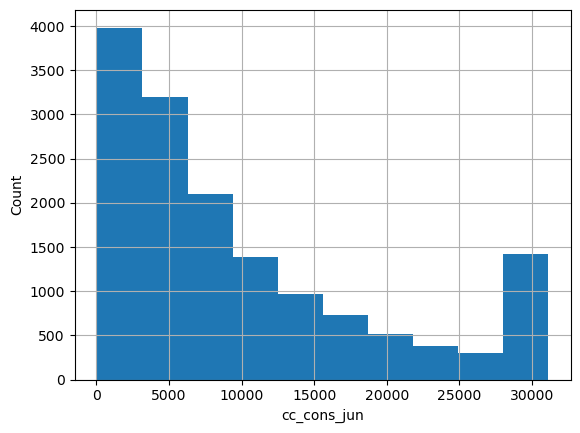

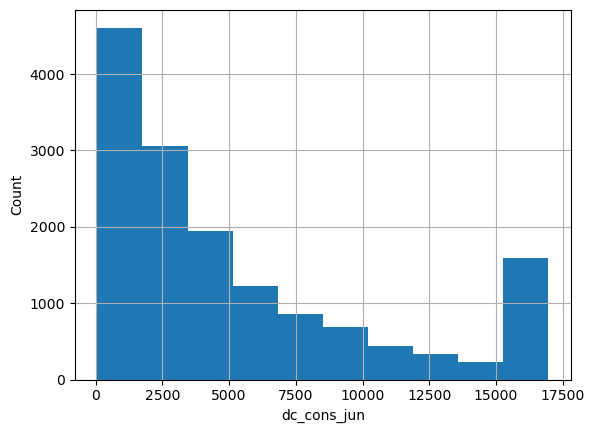

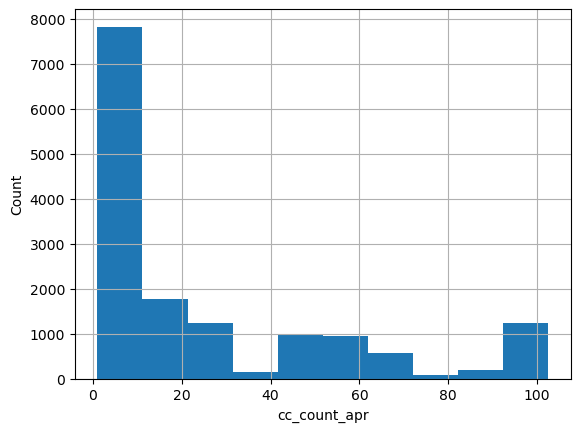

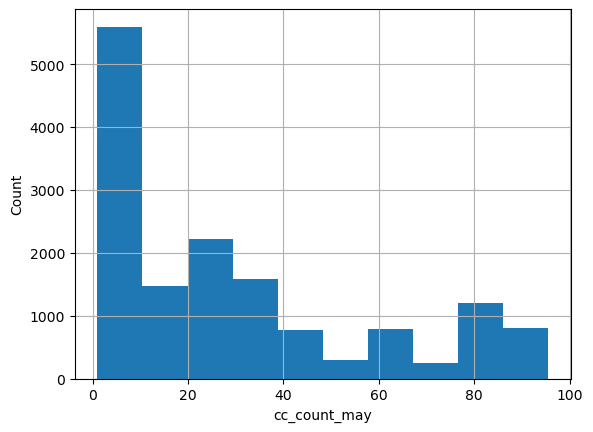

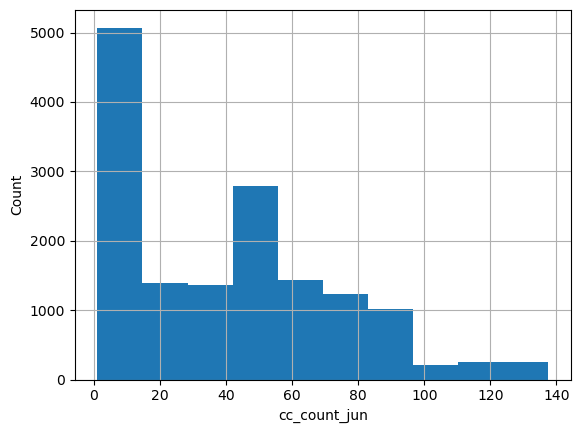

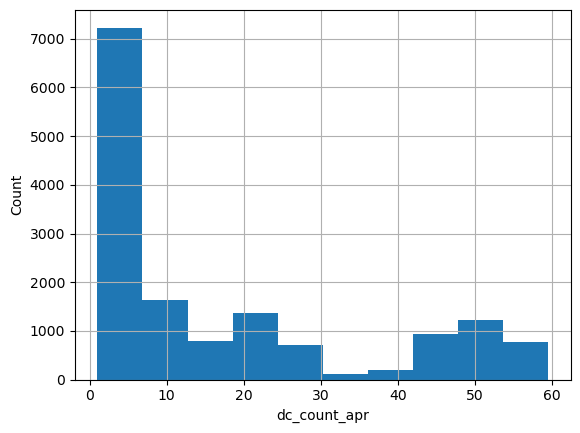

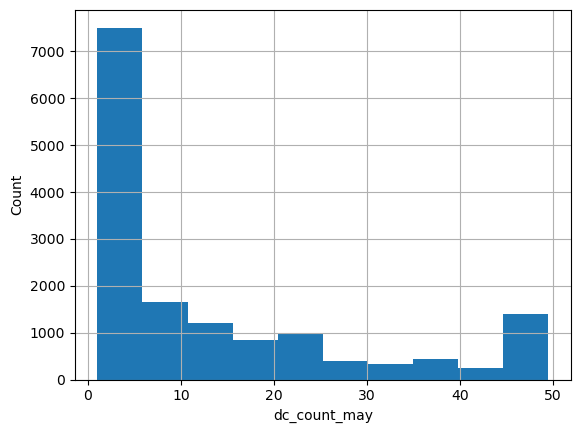

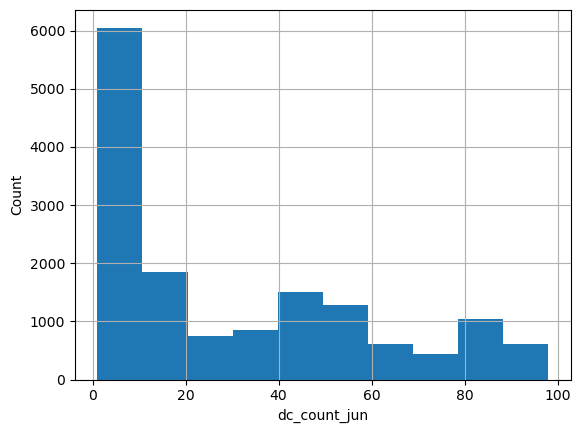

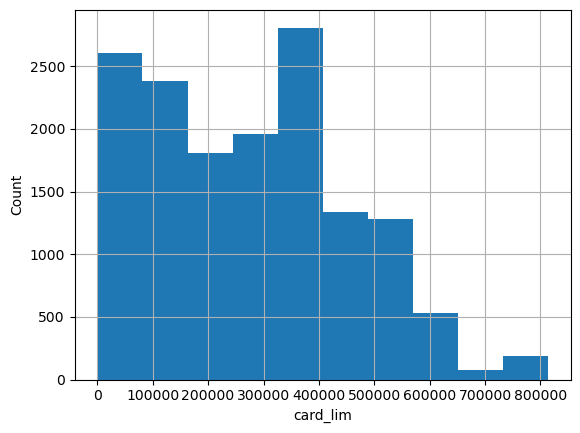

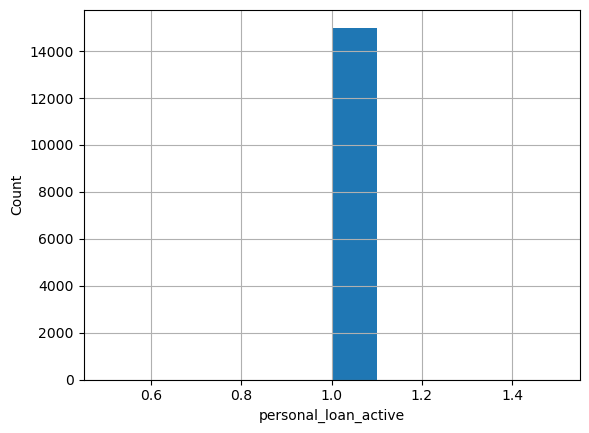

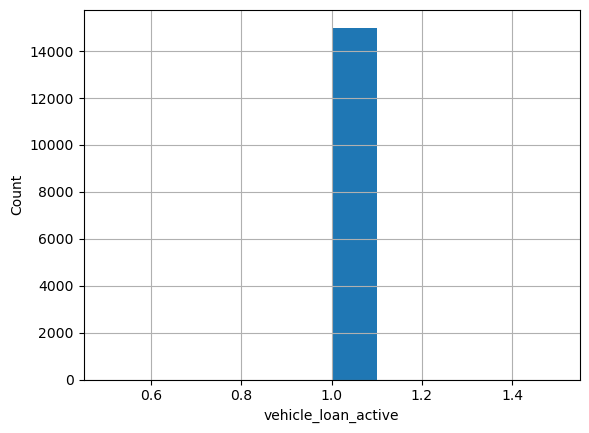

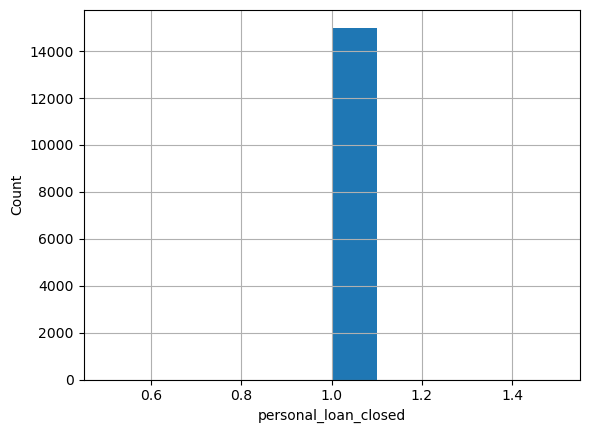

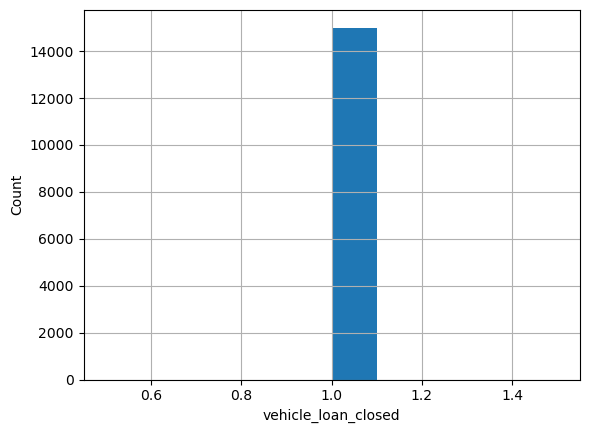

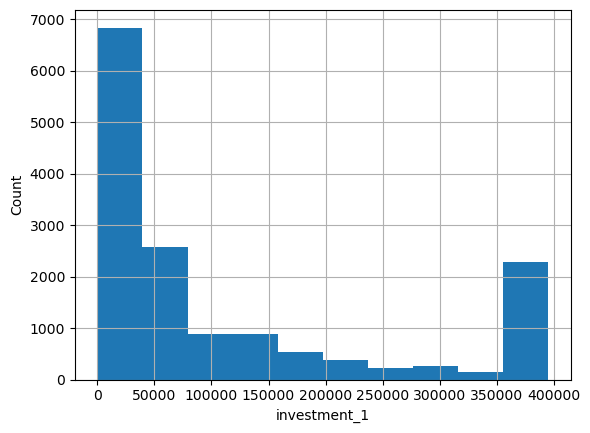

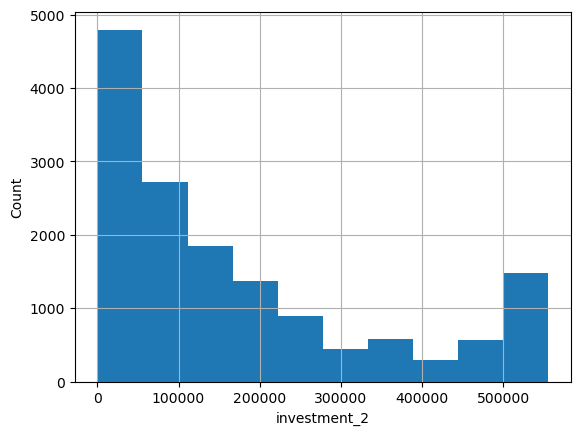

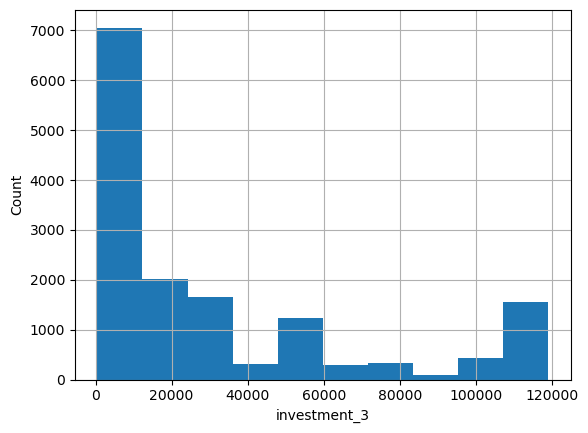

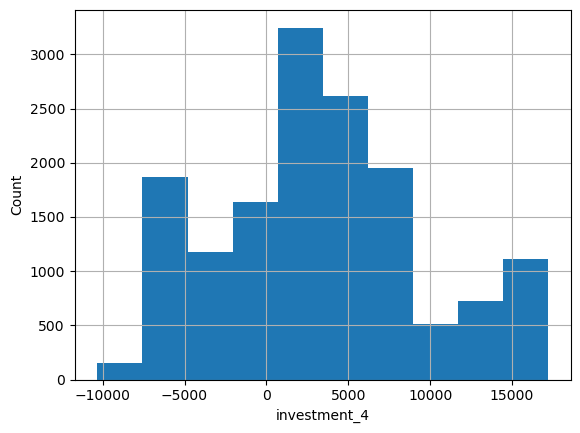

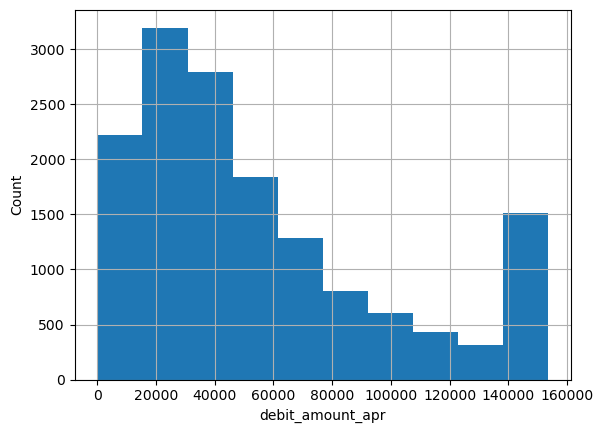

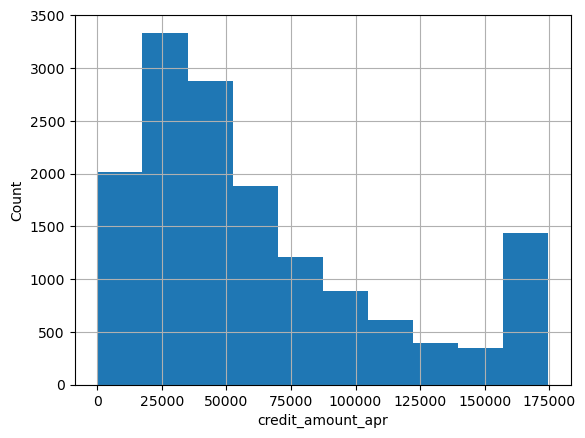

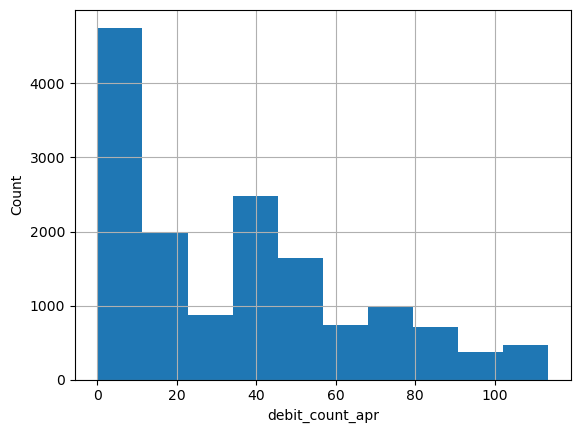

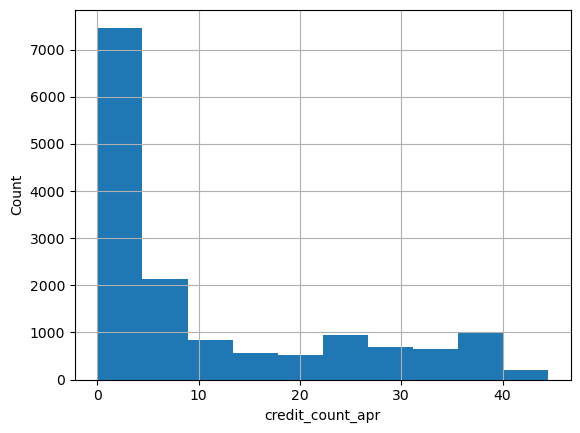

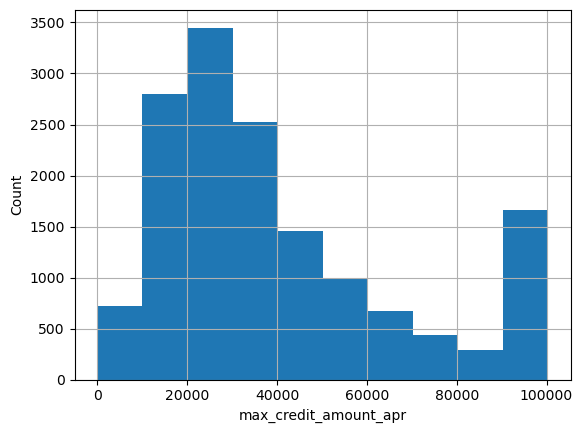

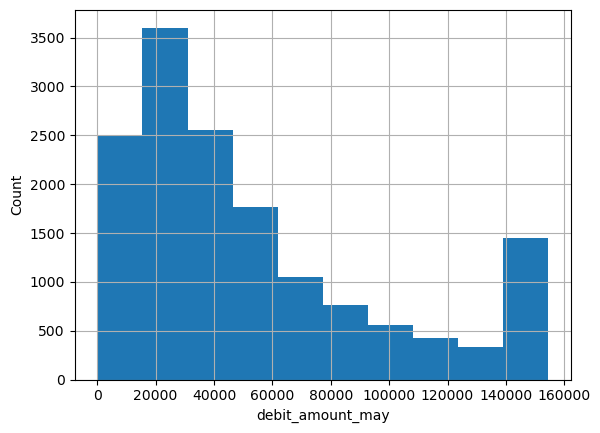

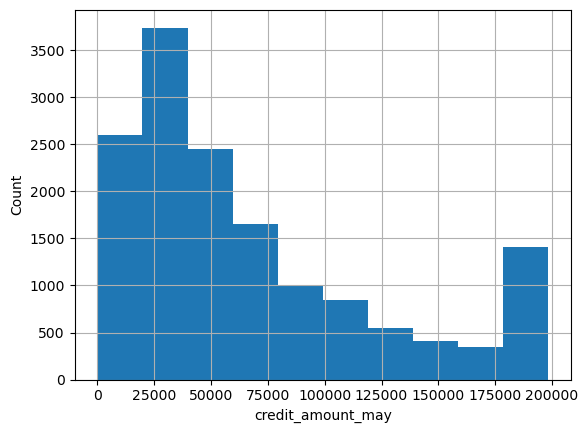

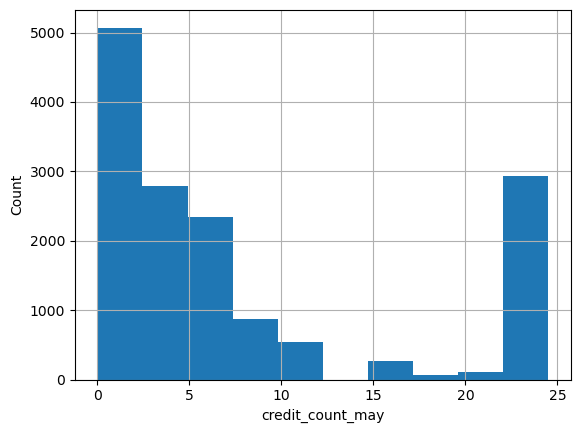

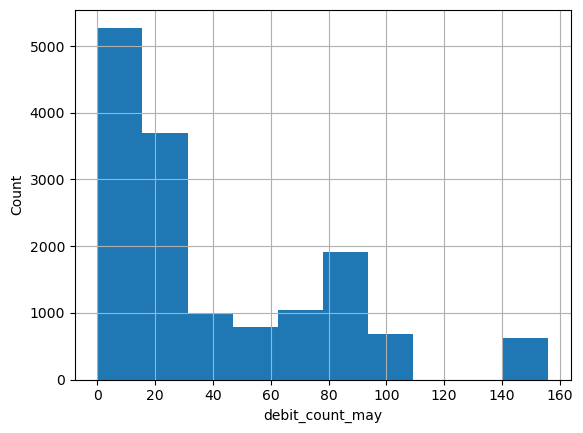

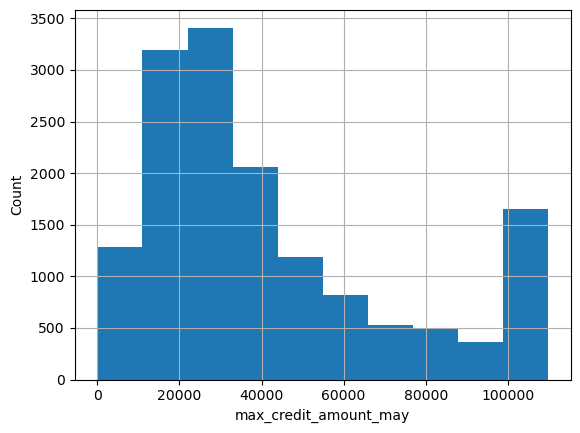

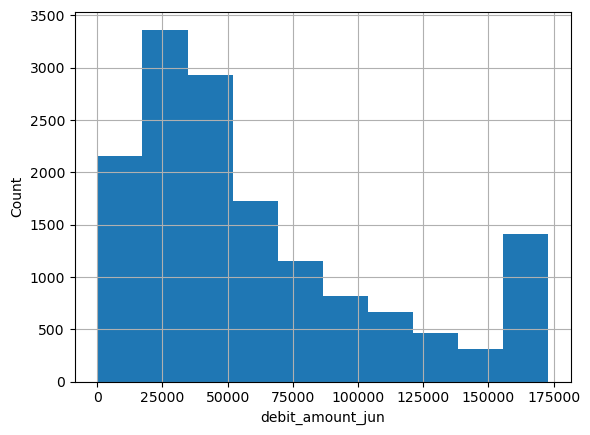

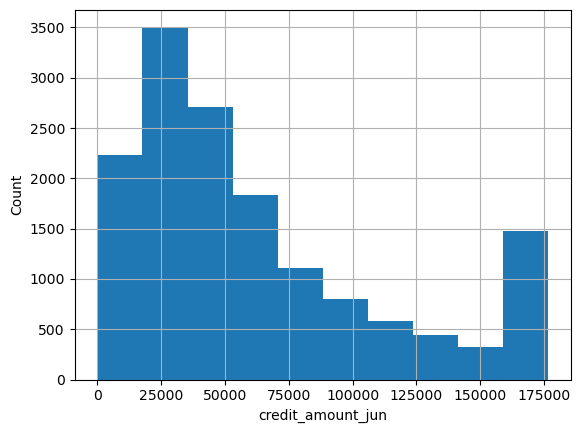

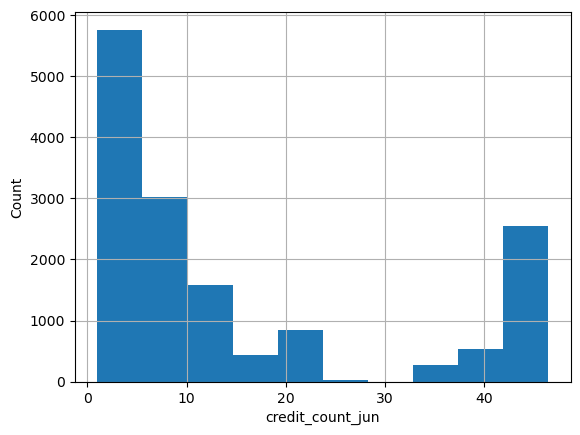

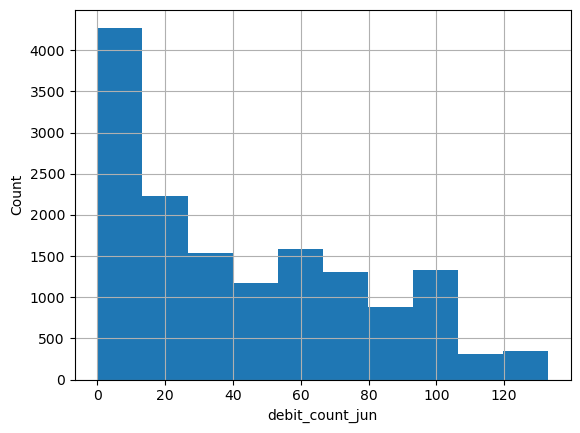

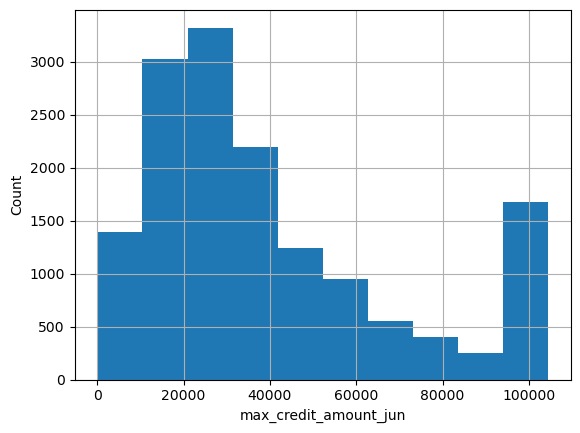

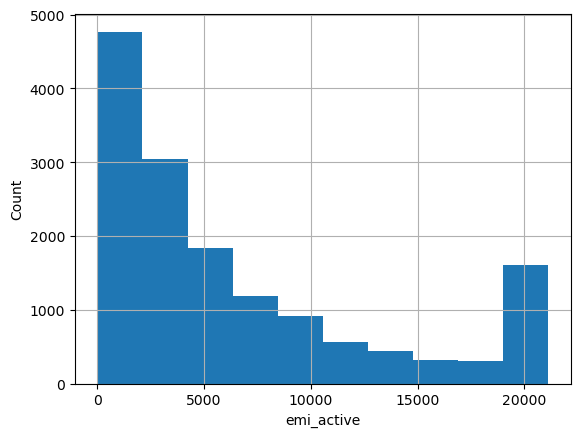

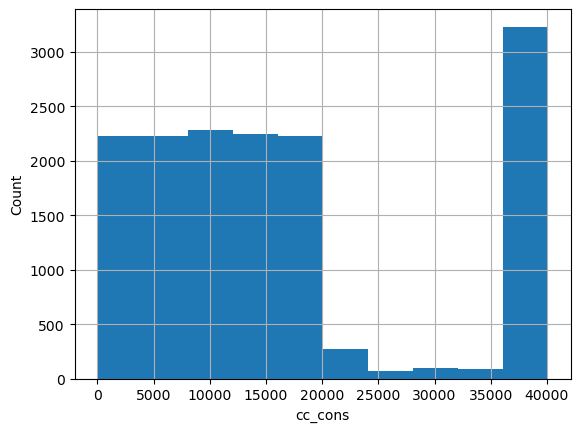

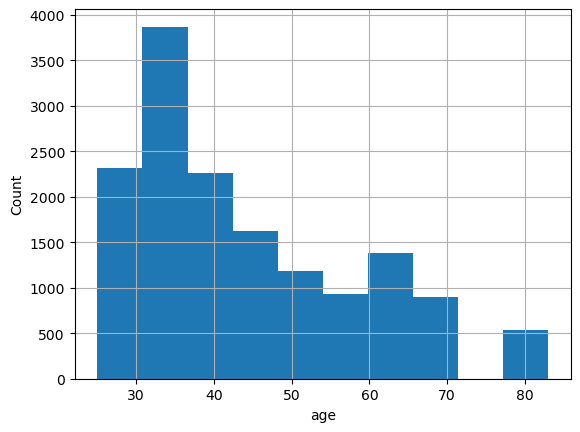

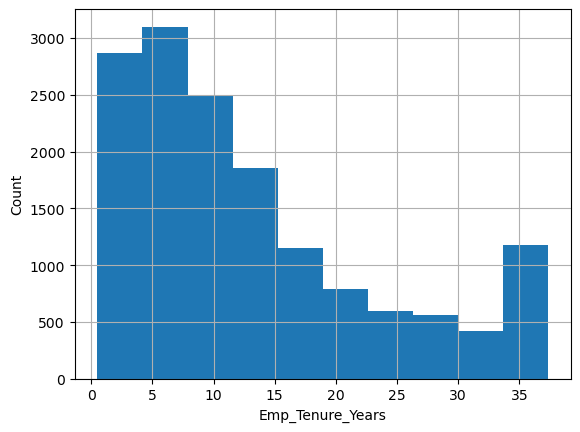

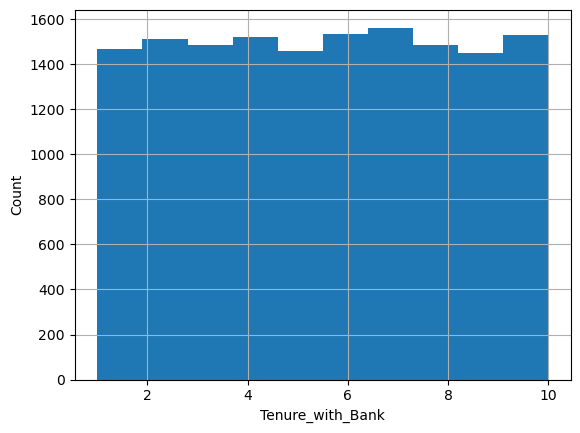

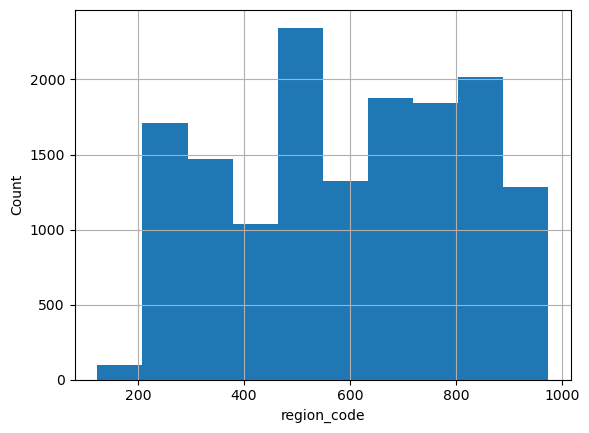

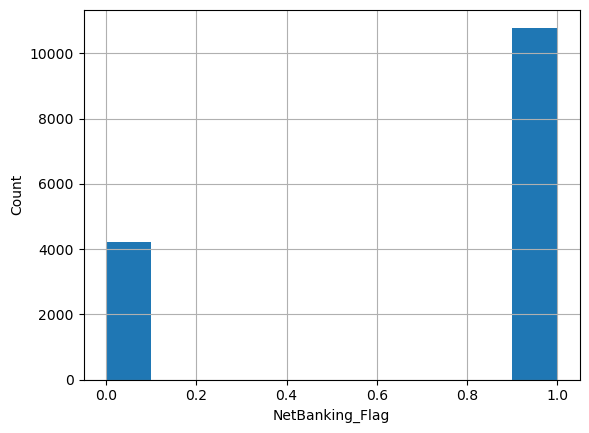

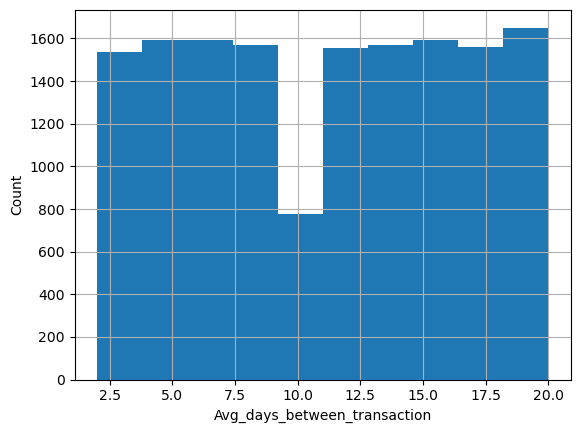

In [590]:
for i in customer_df_num.columns:
    customer_df_num[i].hist()
    plt.xlabel(str(i))
    plt.ylabel("Count")
    plt.show()

# Bivariate Analysis (Relationships Between Variables)

Numeric vs. Target (customer_df)

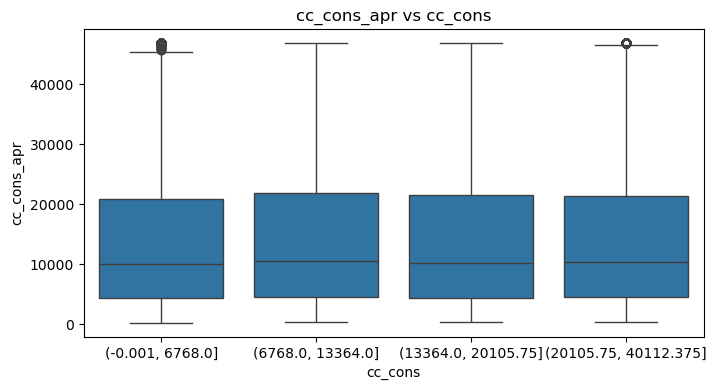

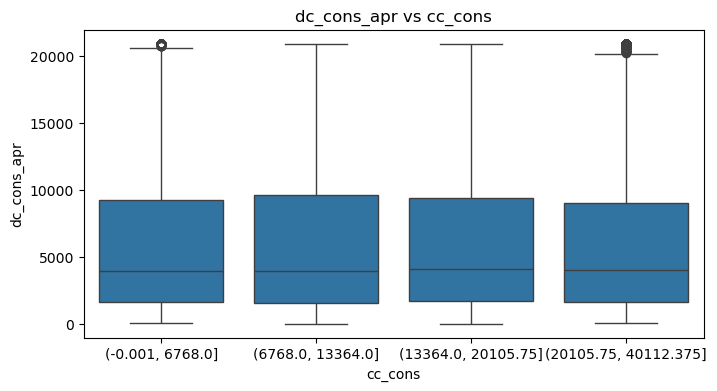

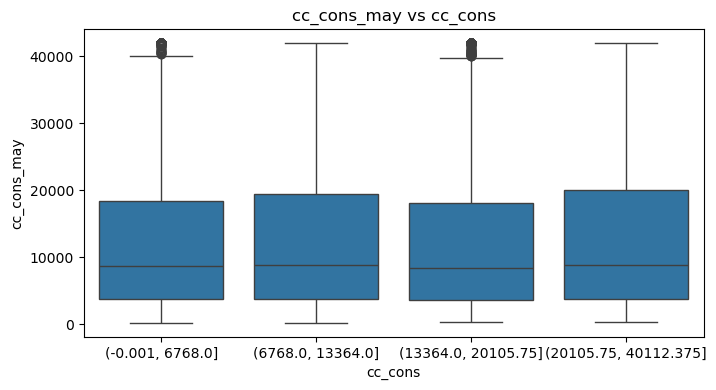

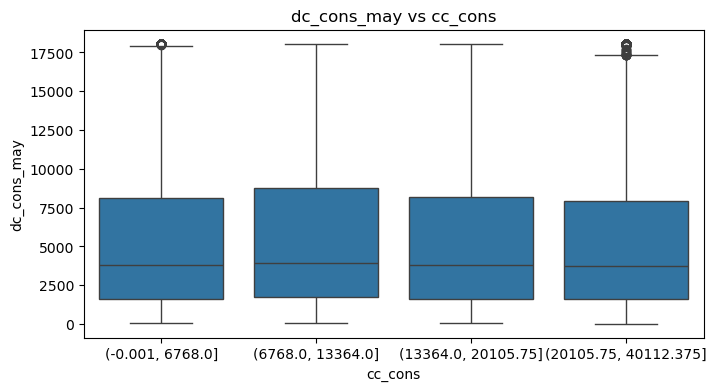

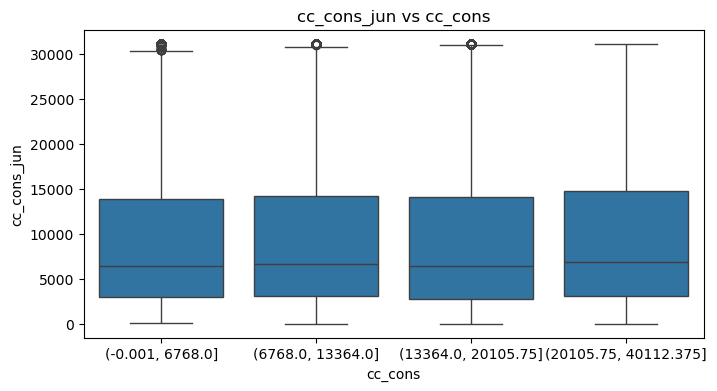

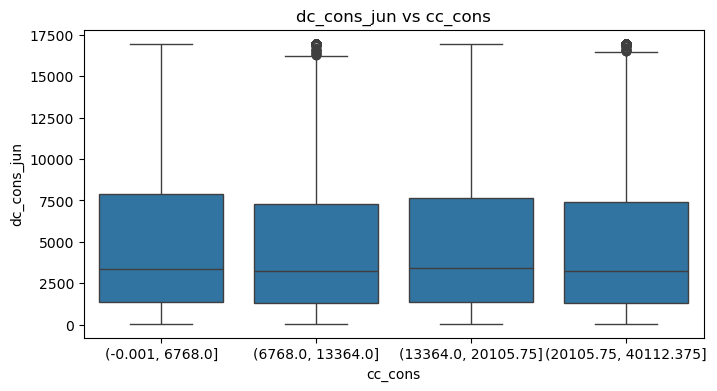

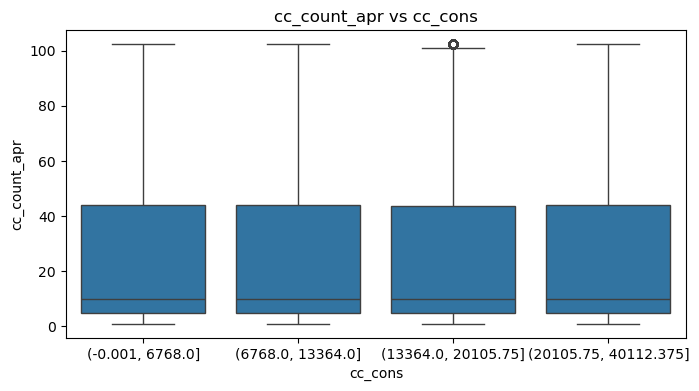

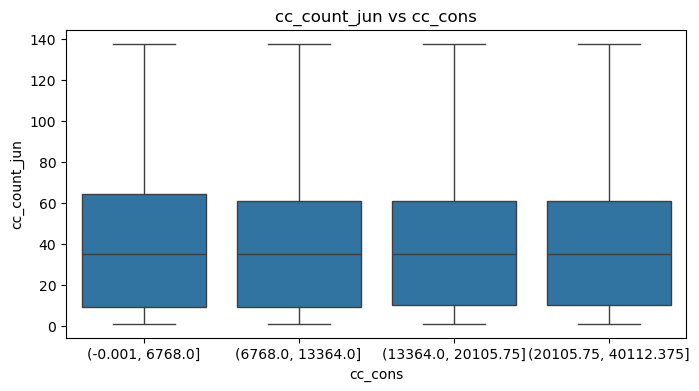

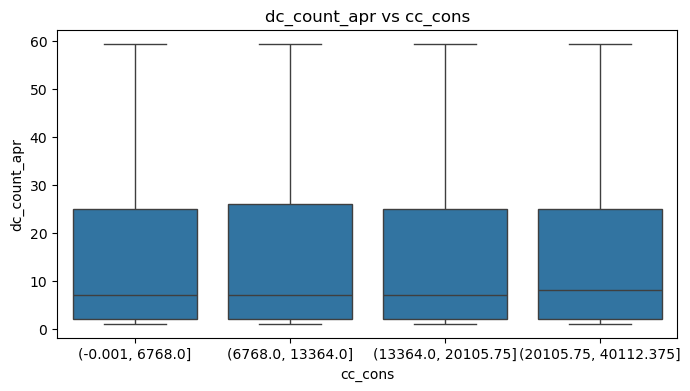

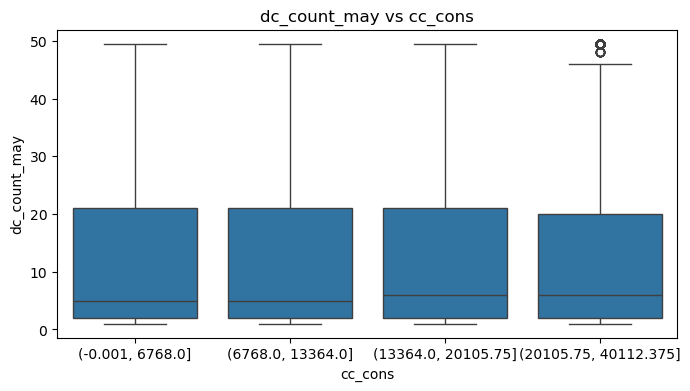

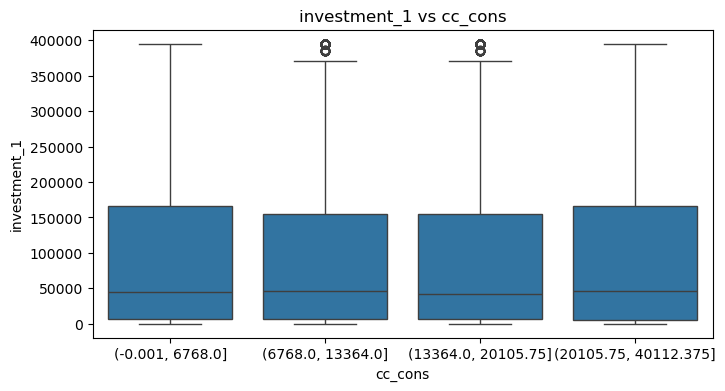

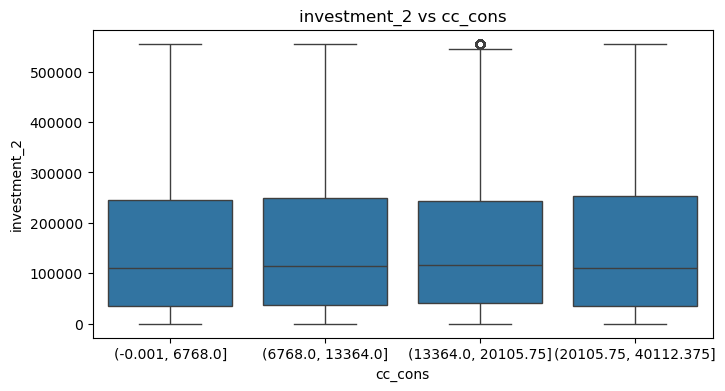

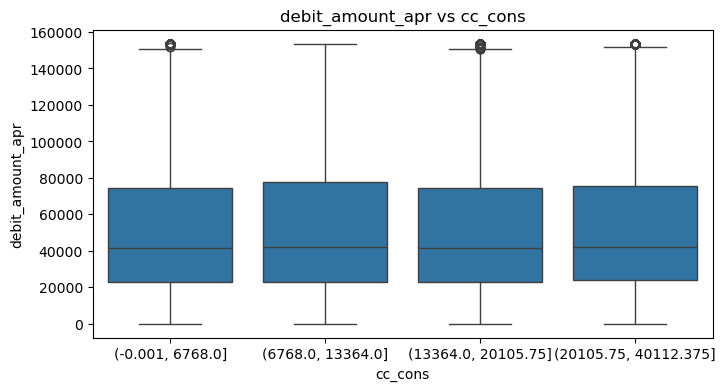

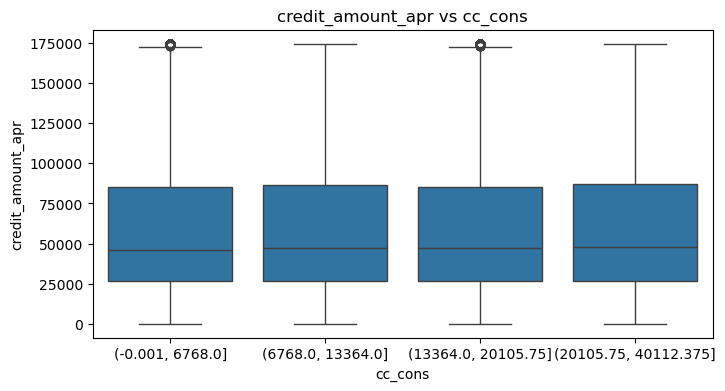

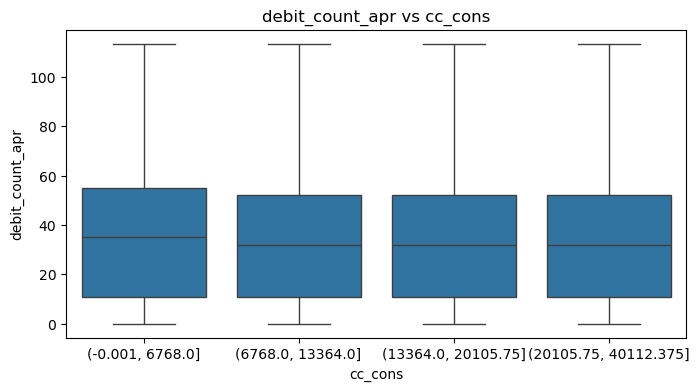

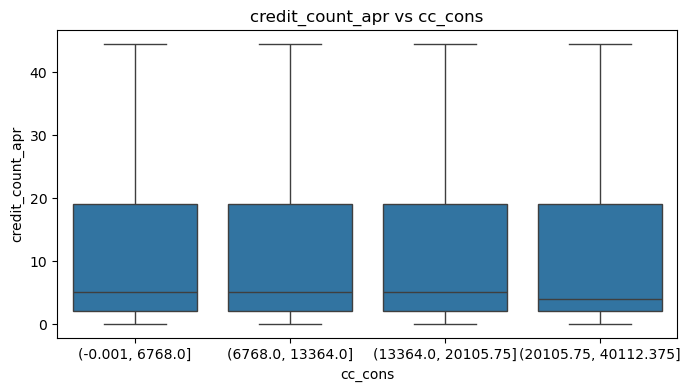

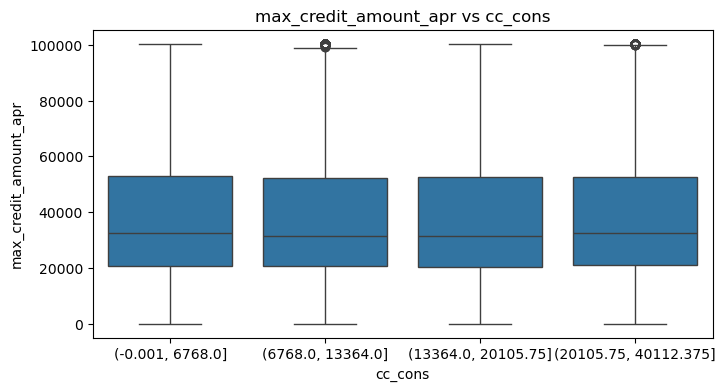

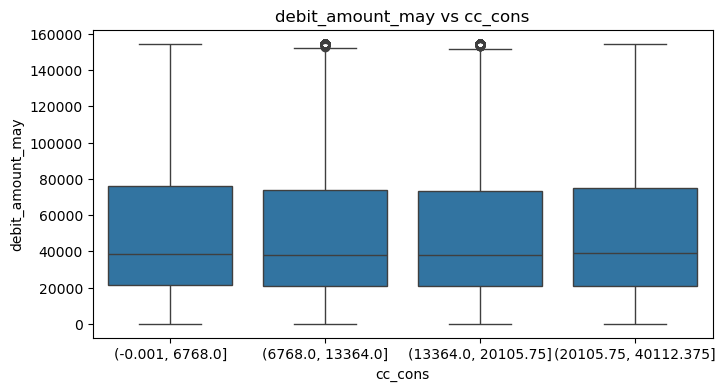

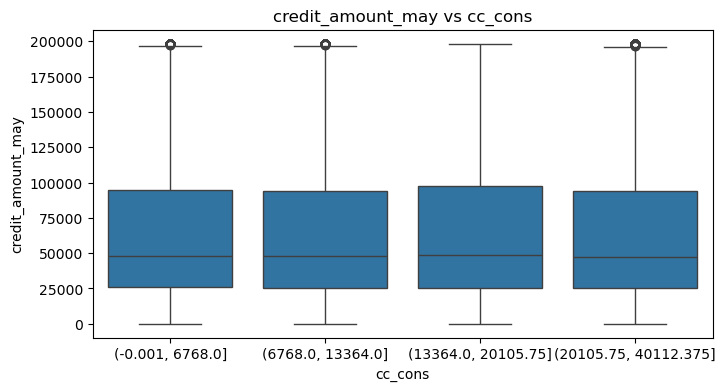

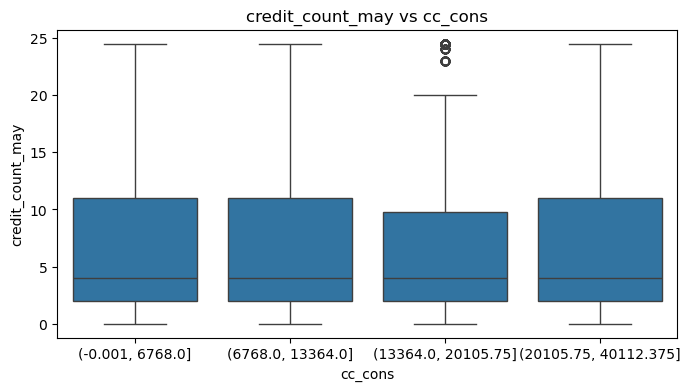

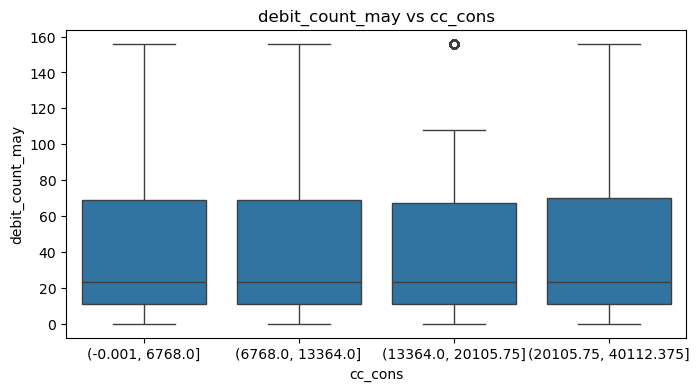

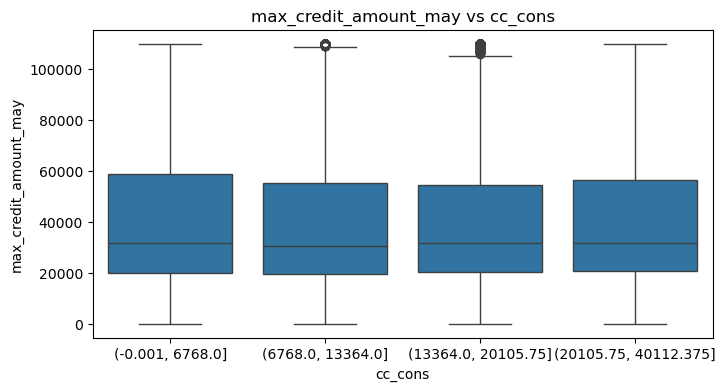

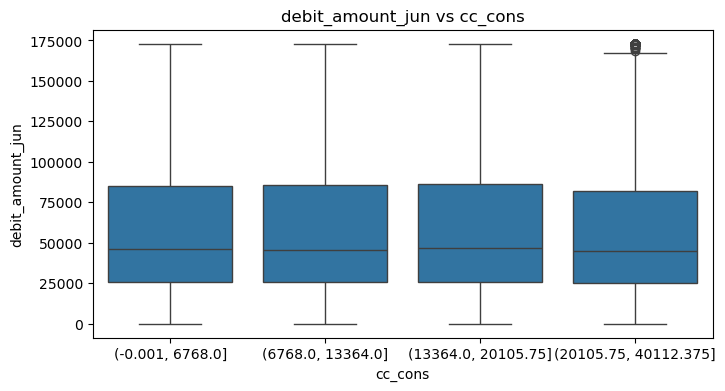

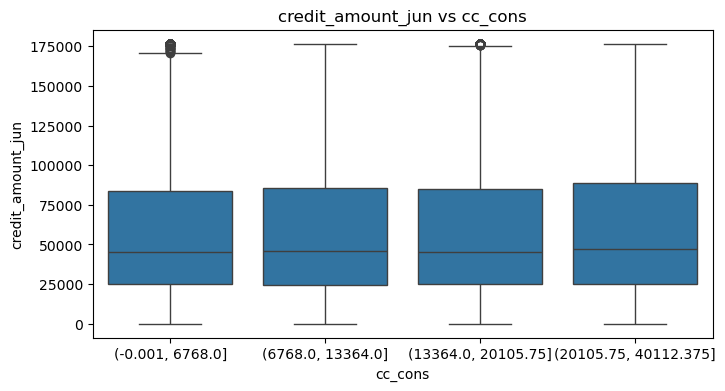

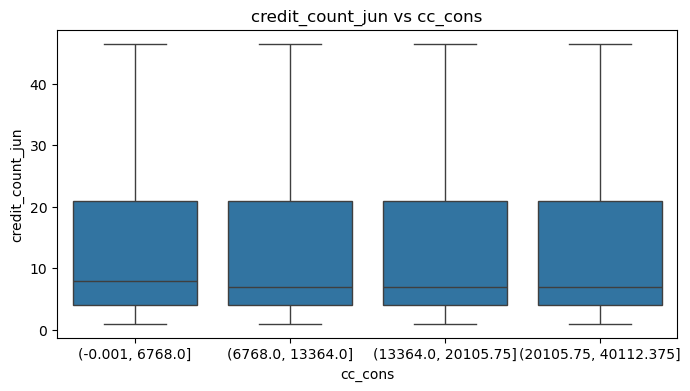

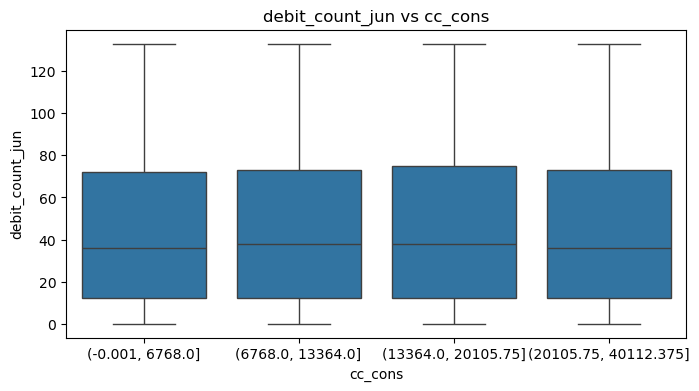

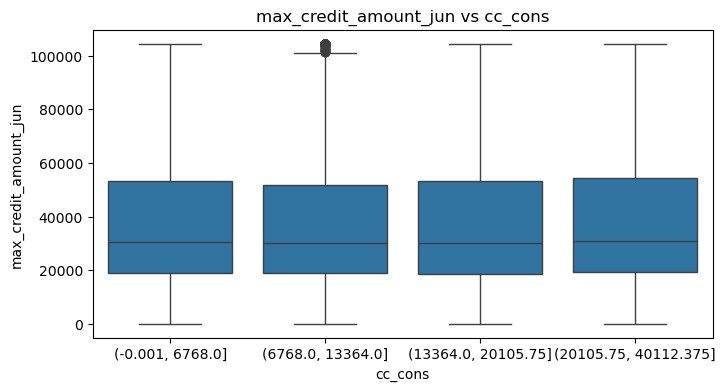

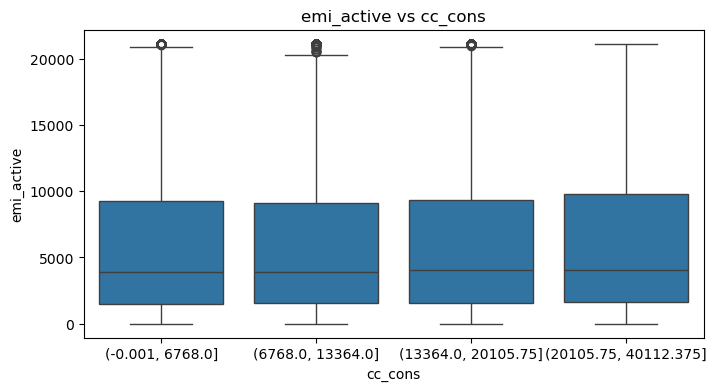

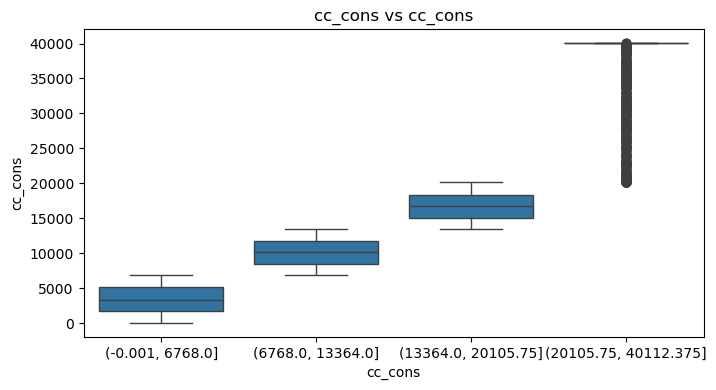

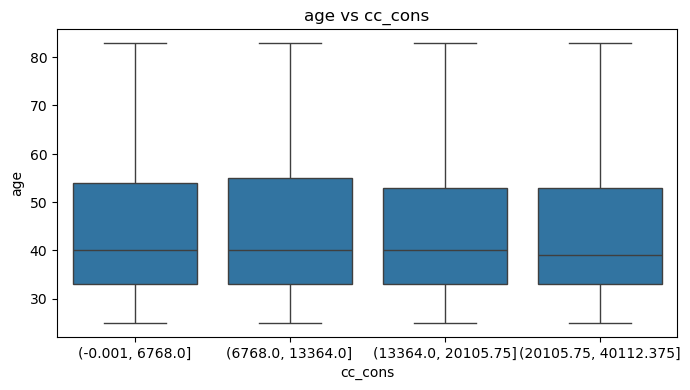

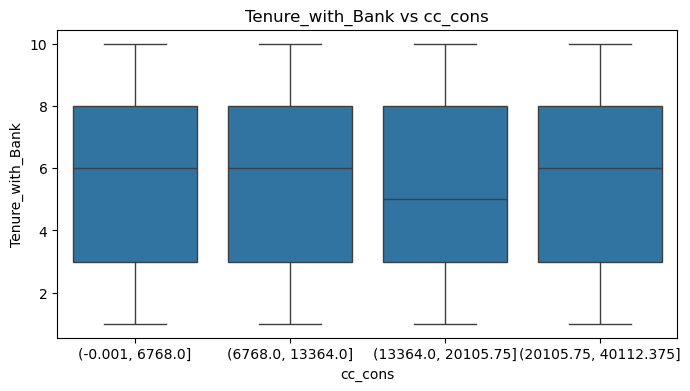

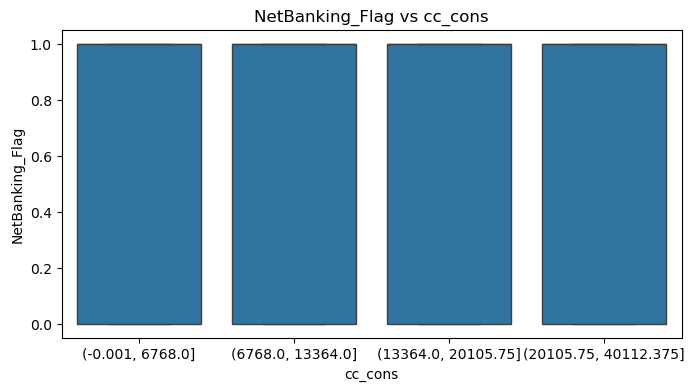

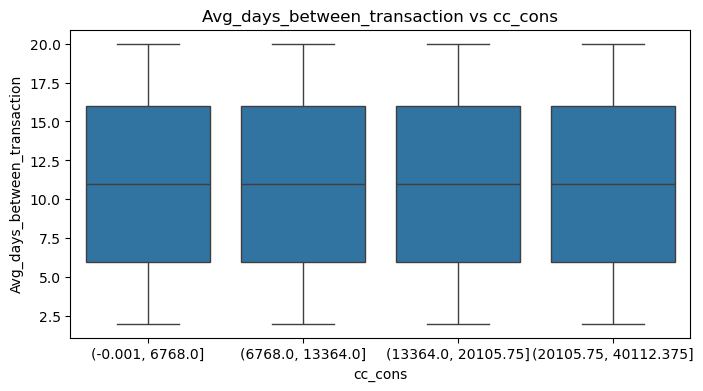

In [592]:
for col in customer_df.select_dtypes(include=["number"]).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=pd.qcut(customer_df["cc_cons"],q=4,duplicates="drop"), y=customer_df_num[col])
    plt.title(f"{col} vs cc_cons")
    plt.show()

Numeric vs. Target (pred_customer_df)

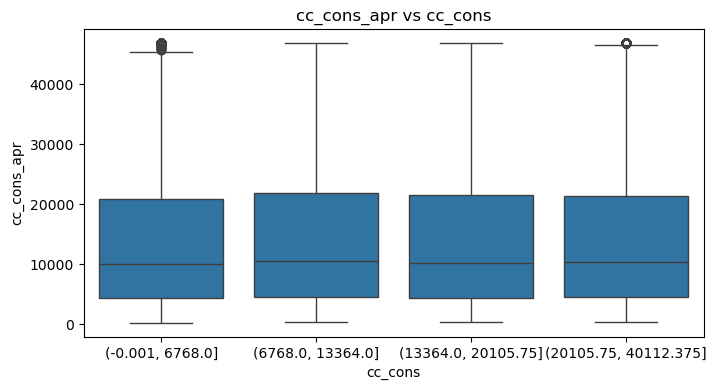

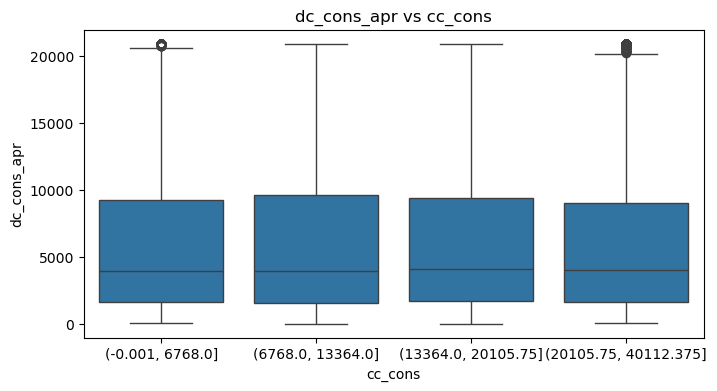

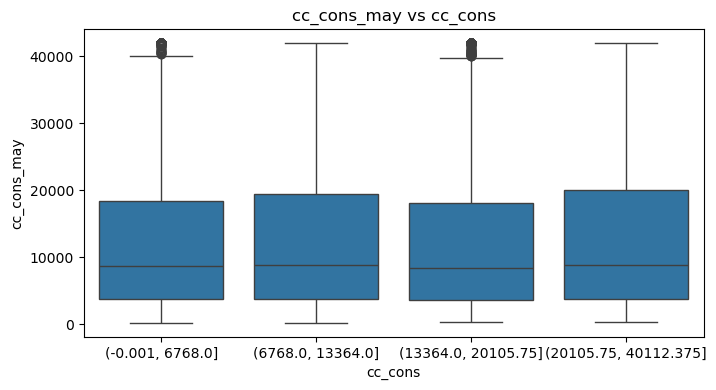

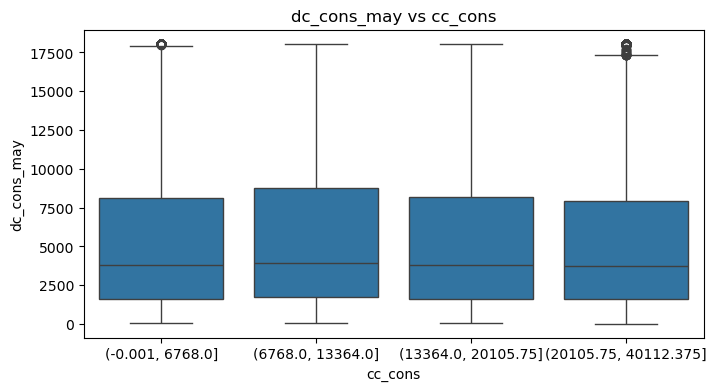

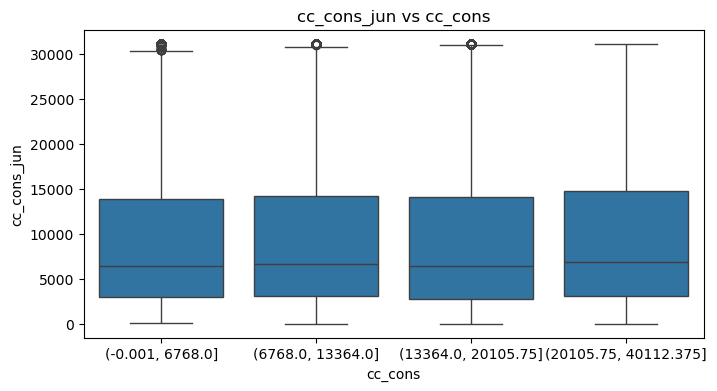

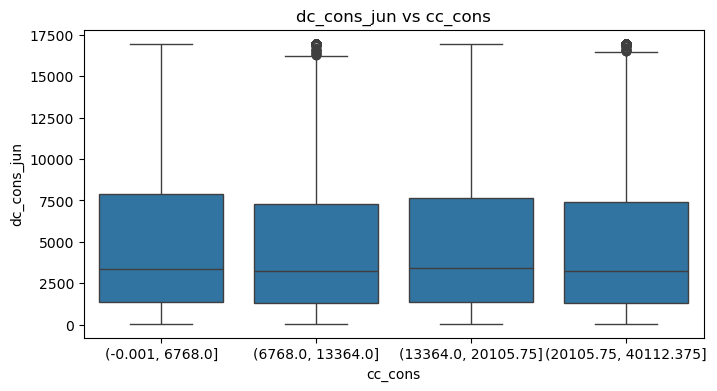

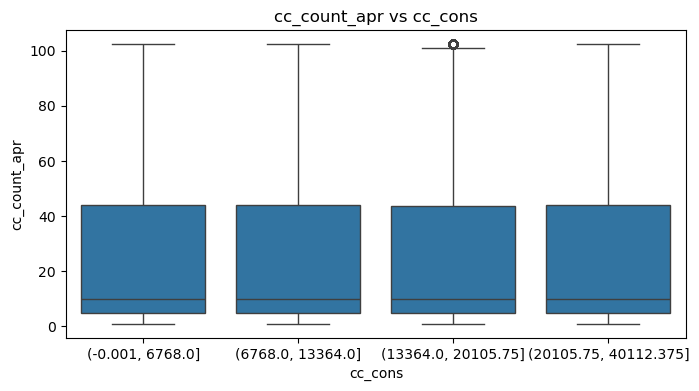

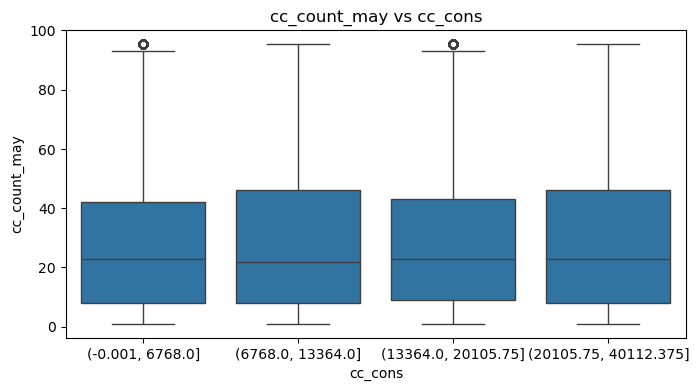

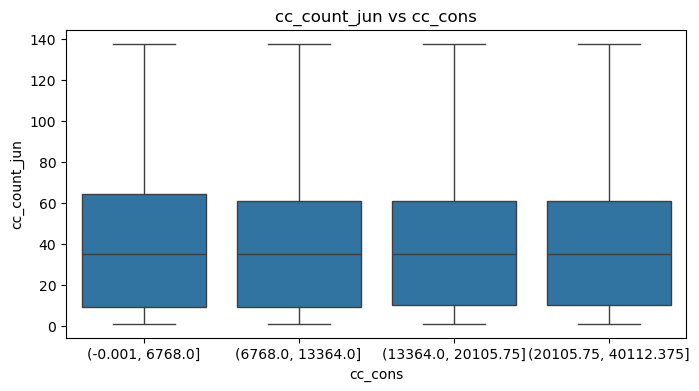

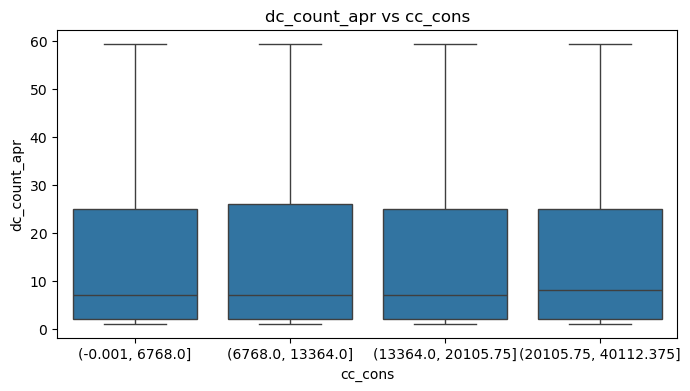

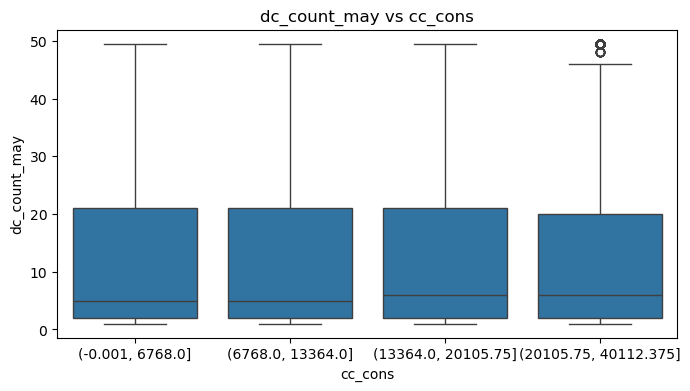

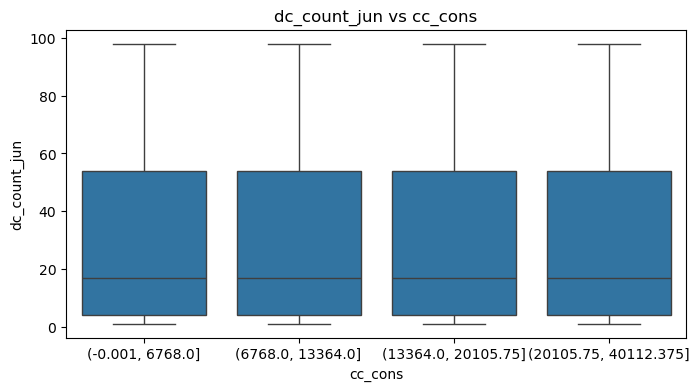

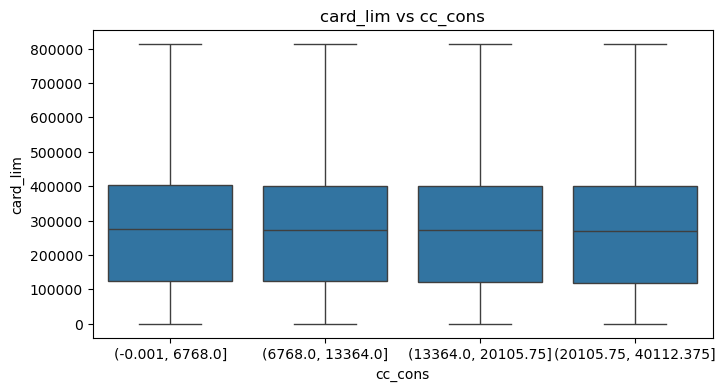

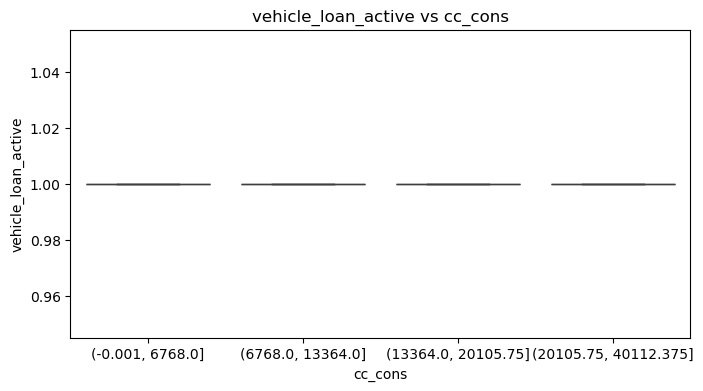

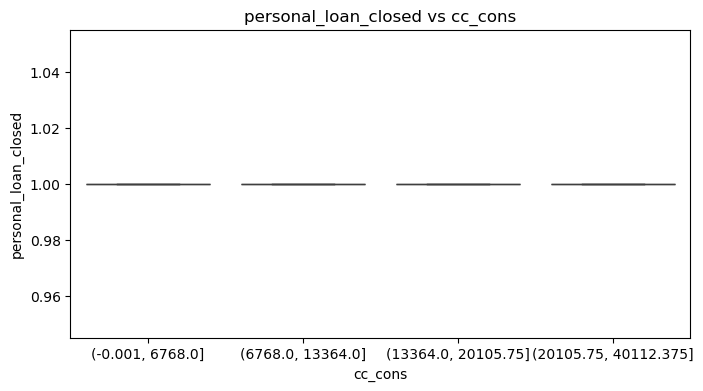

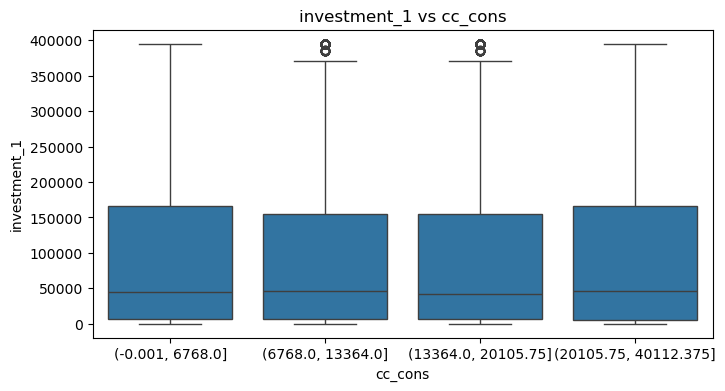

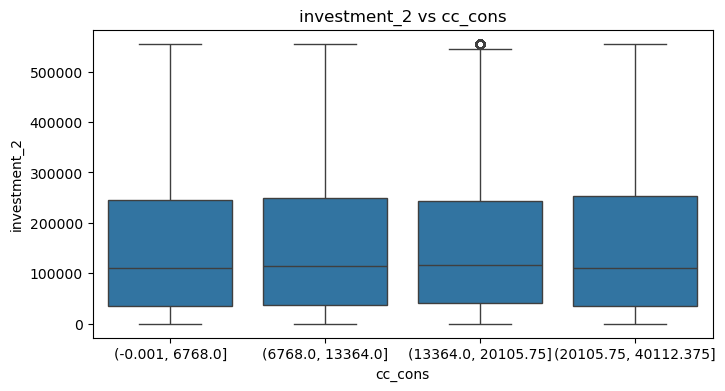

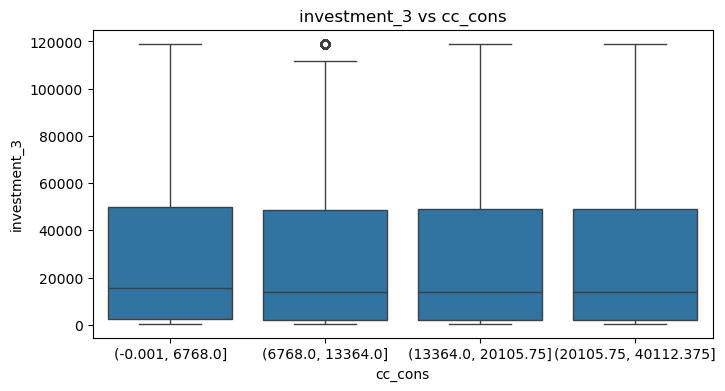

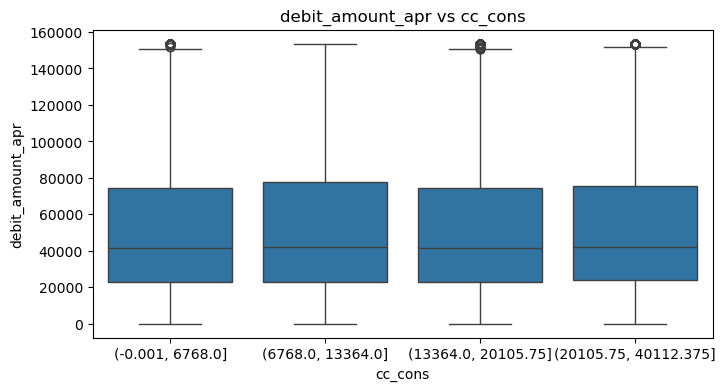

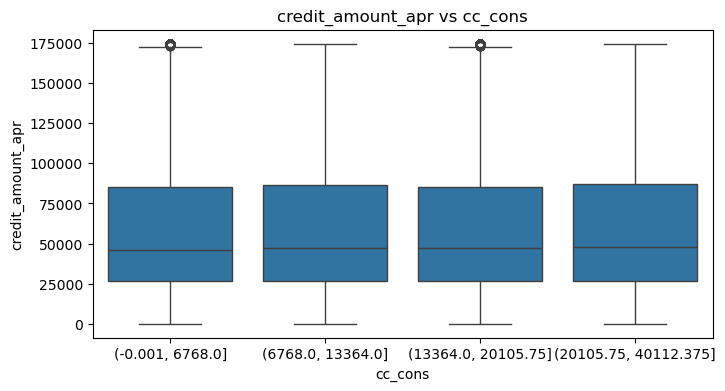

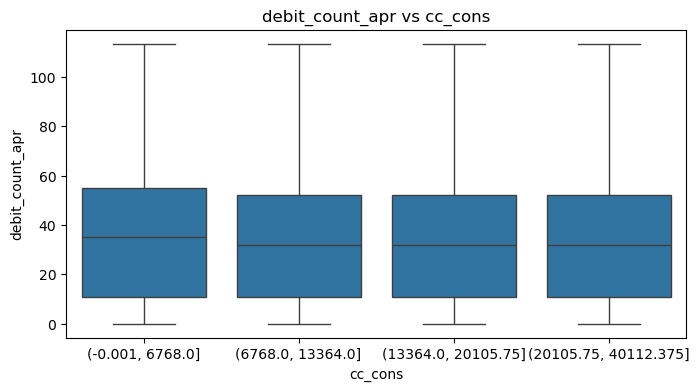

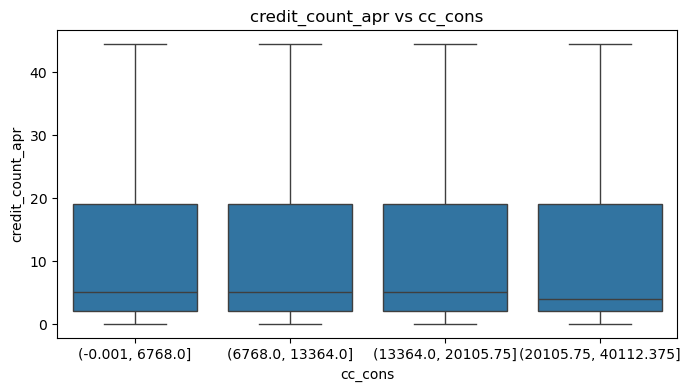

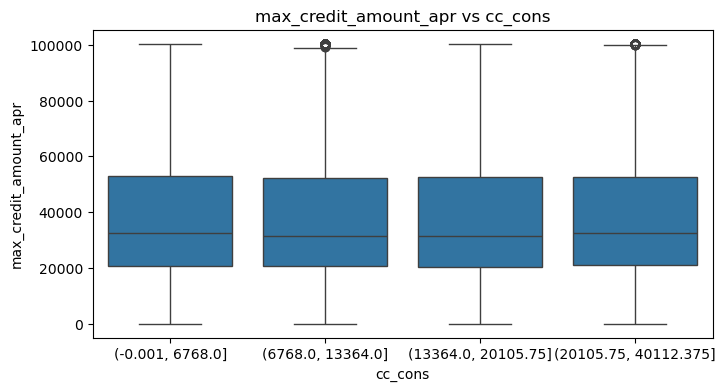

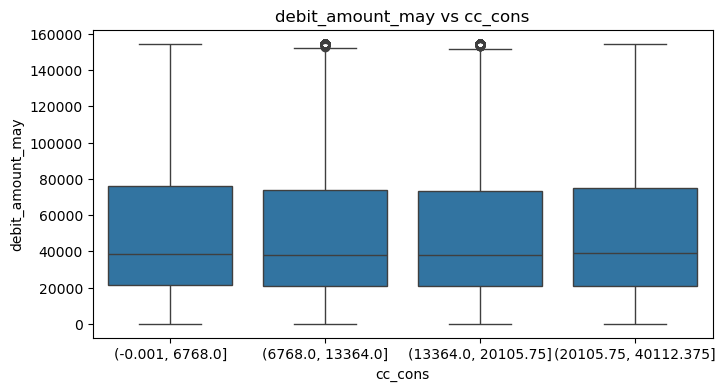

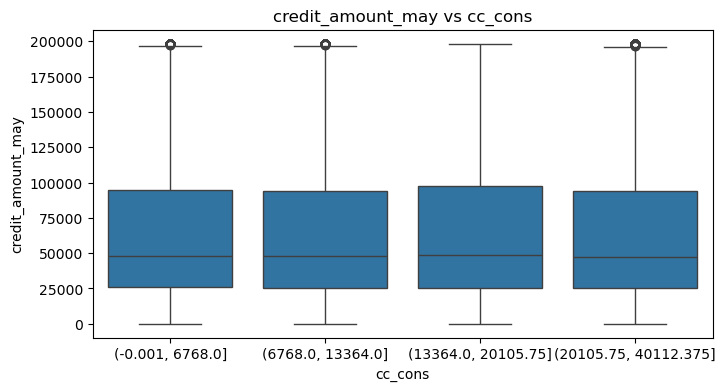

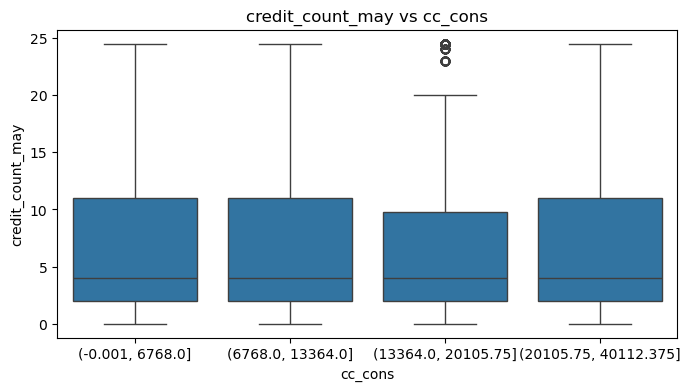

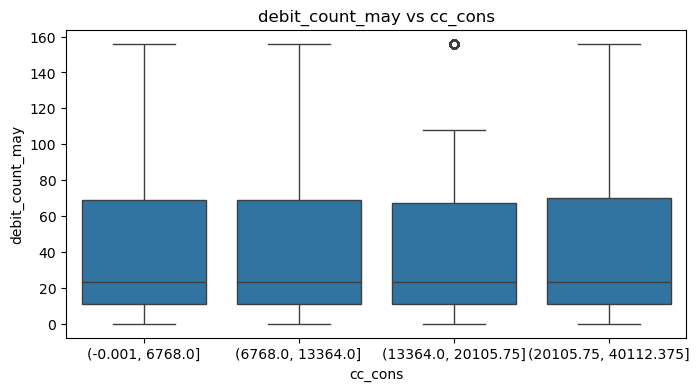

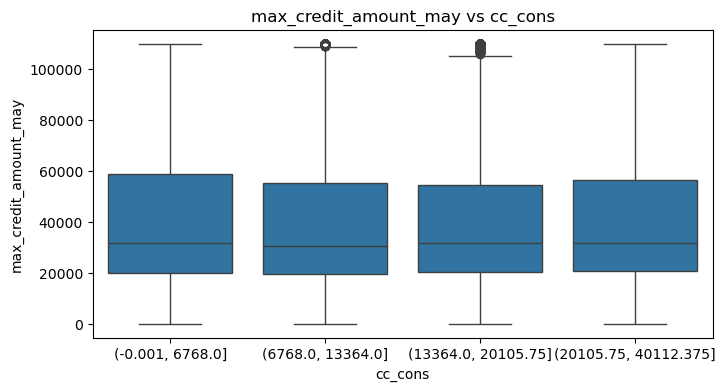

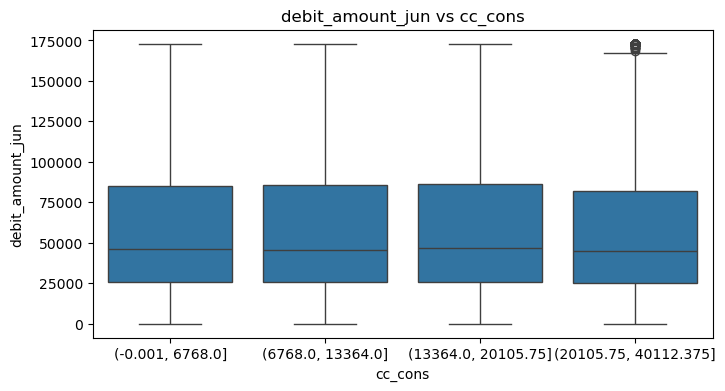

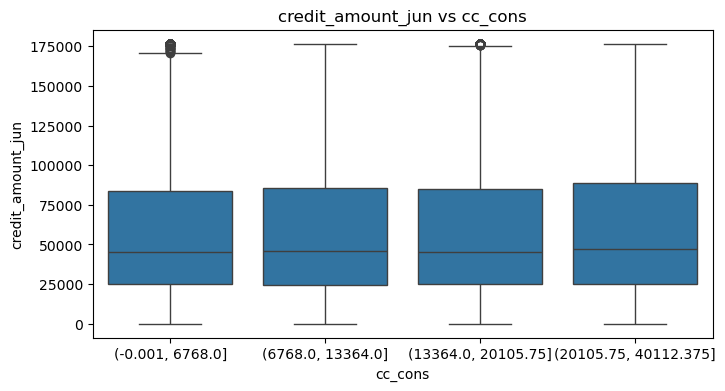

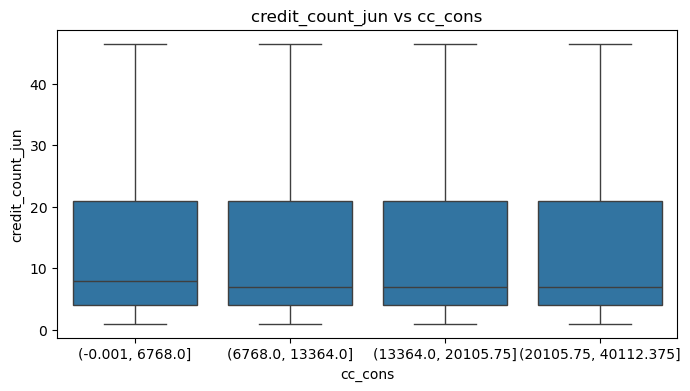

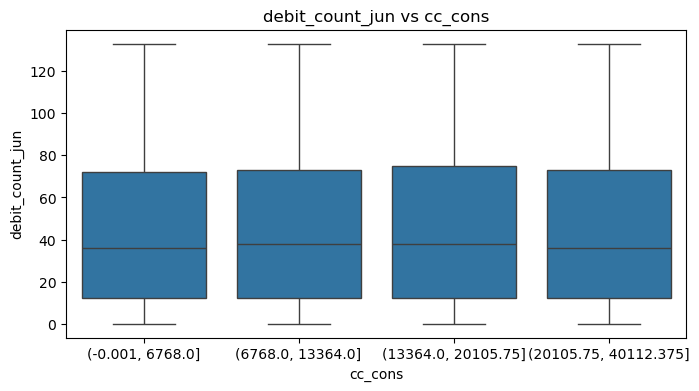

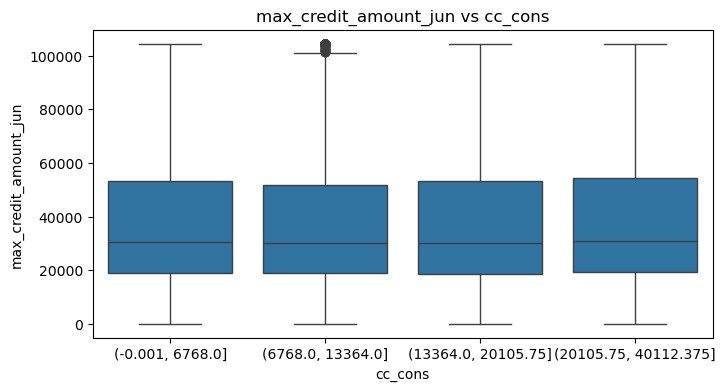

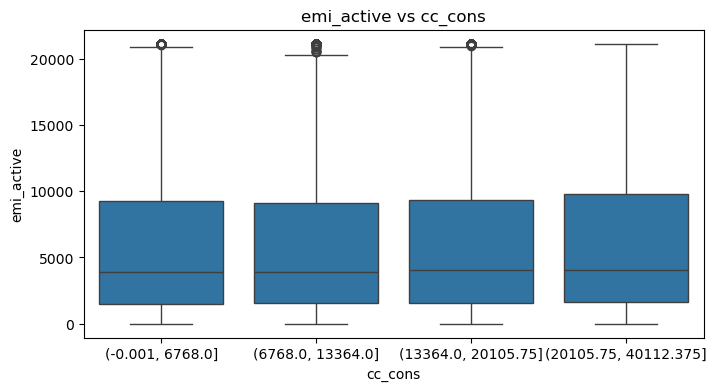

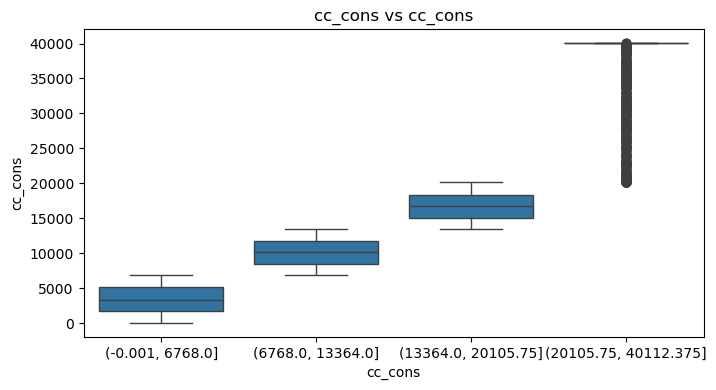

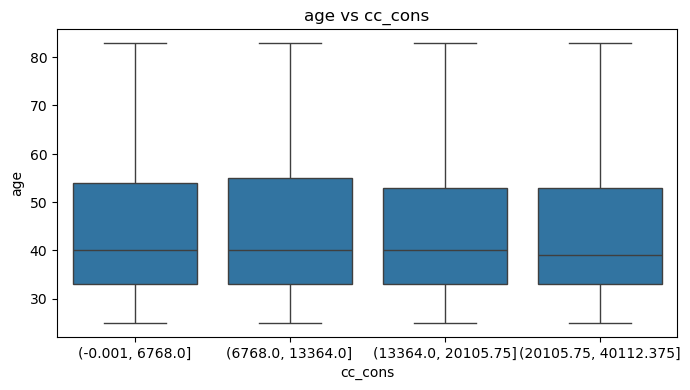

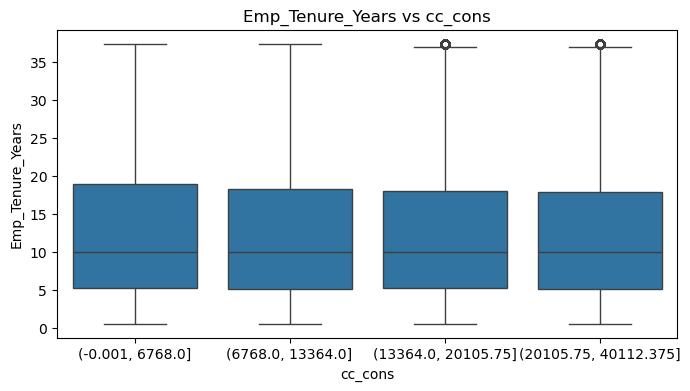

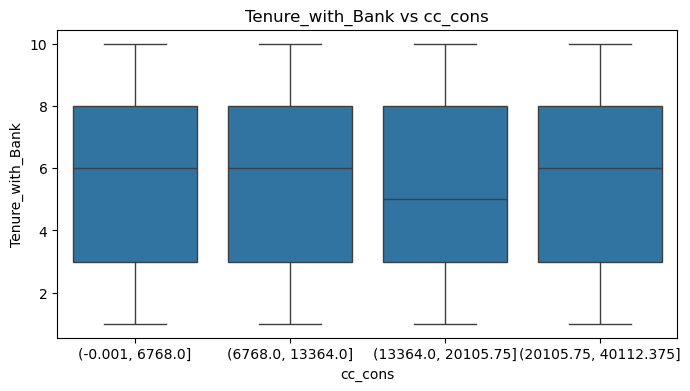

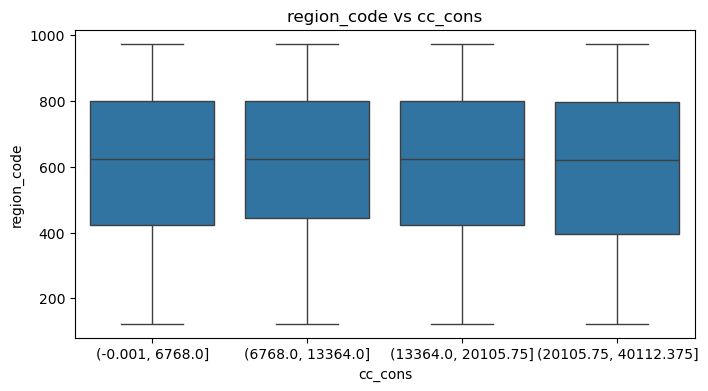

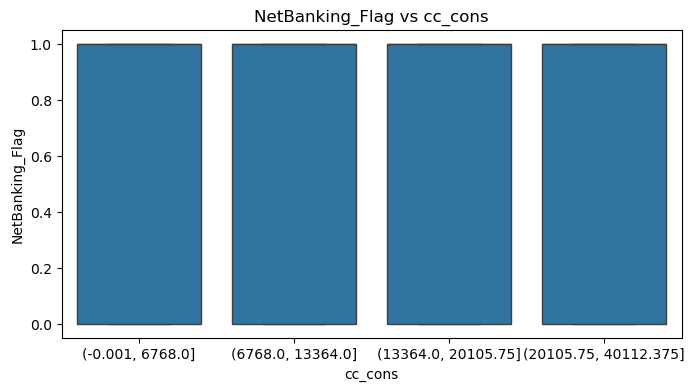

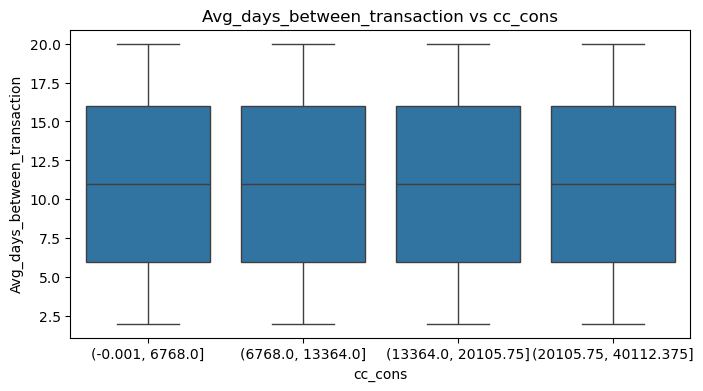

In [594]:
for col in customer_df.select_dtypes(include=["number"]).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=pd.qcut(customer_df["cc_cons"],q=4,duplicates="drop"), y=customer_df_num[col])
    plt.title(f"{col} vs cc_cons")
    plt.show()

# Coorelation between numerical columns
(i). customer_df

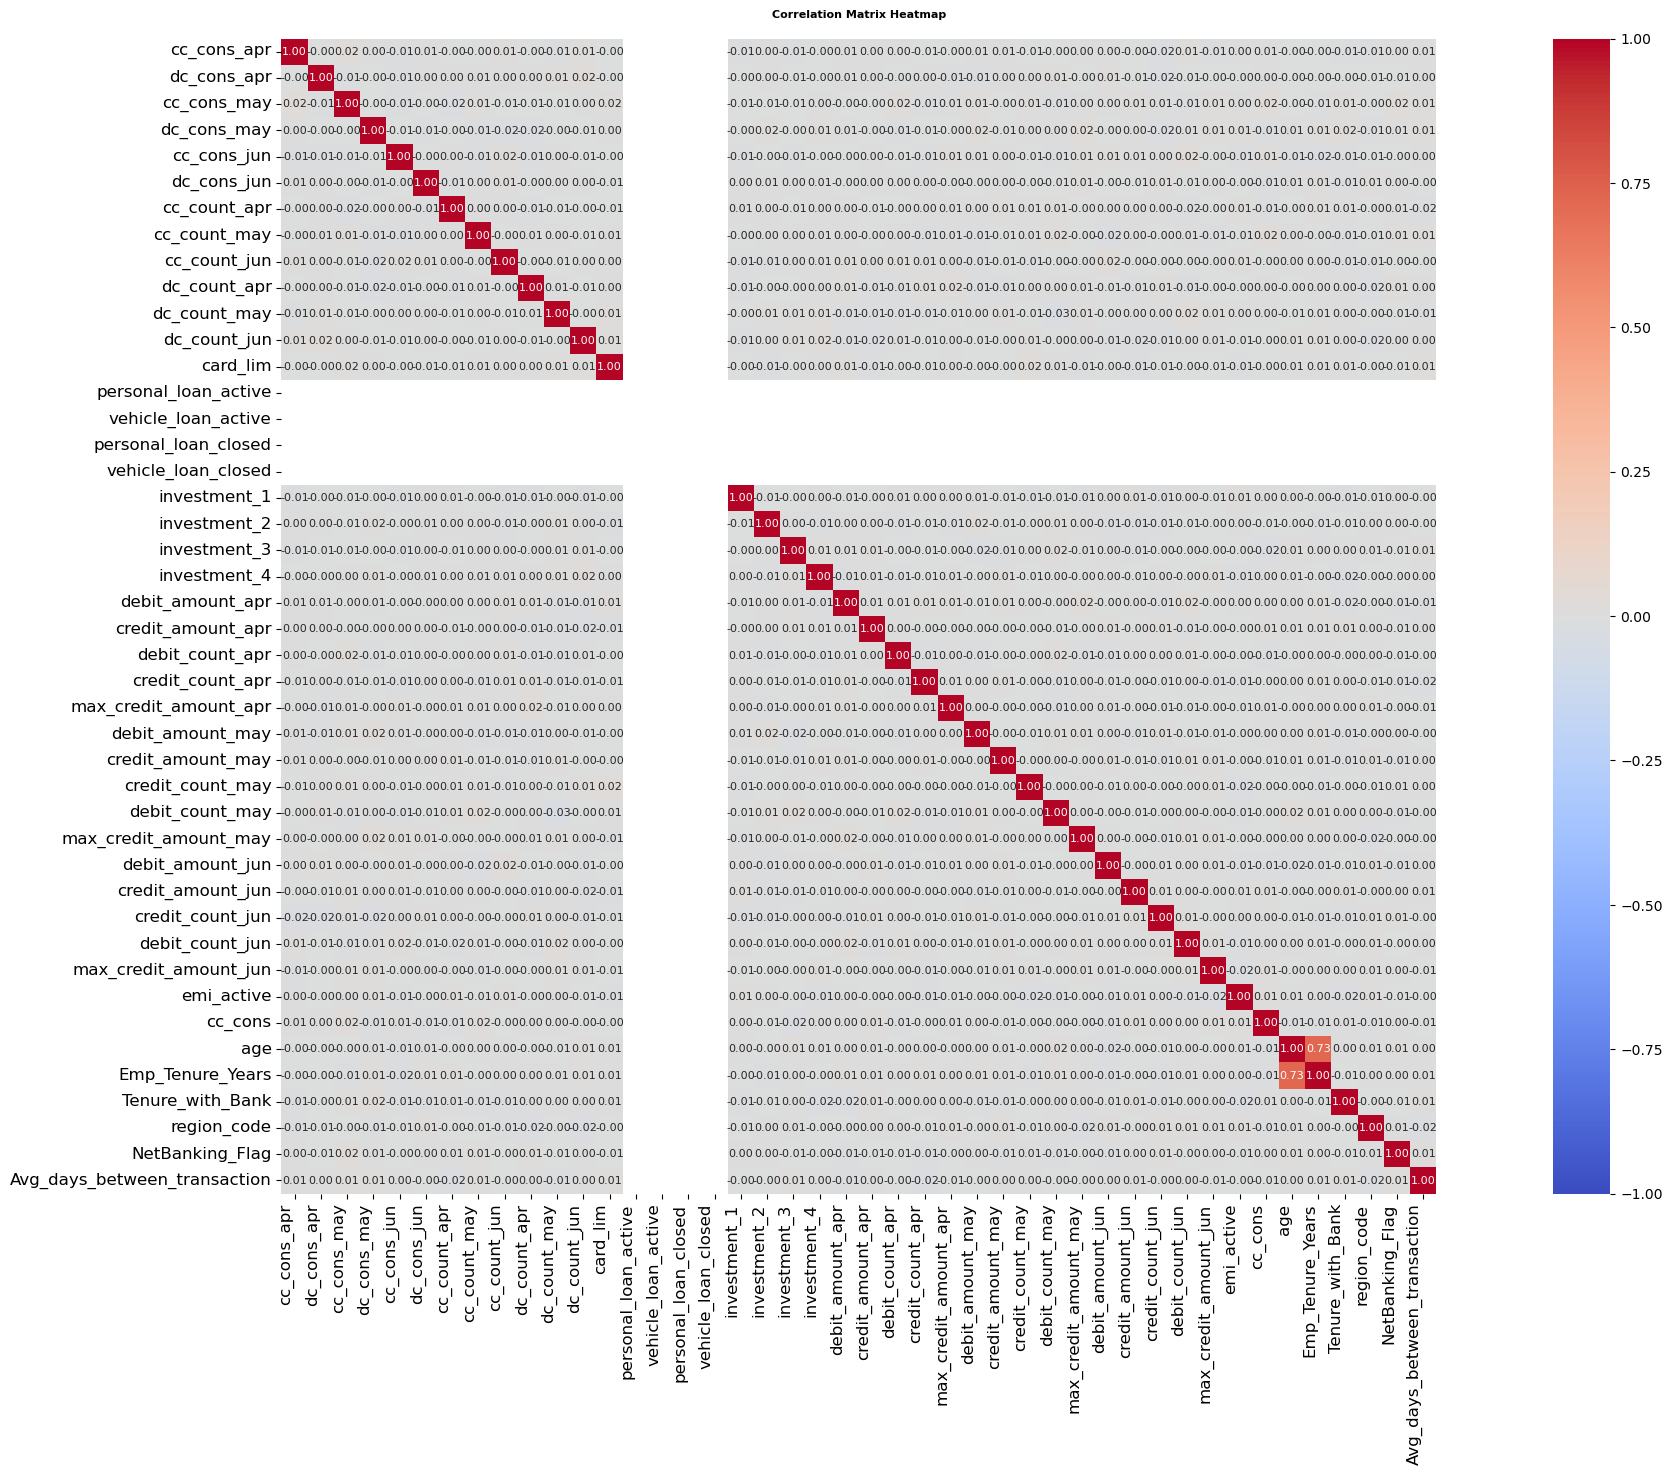

In [596]:
corr=customer_df_num.corr()

plt.figure(figsize=(30,15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', 
            cbar=True, square=True, annot_kws={"size": 8},vmax=1, vmin=-1,center=0)
plt.title("Correlation Matrix Heatmap", fontsize=8, fontweight="bold", pad=15)
plt.xticks(rotation=90, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

(ii). pred_customer_df

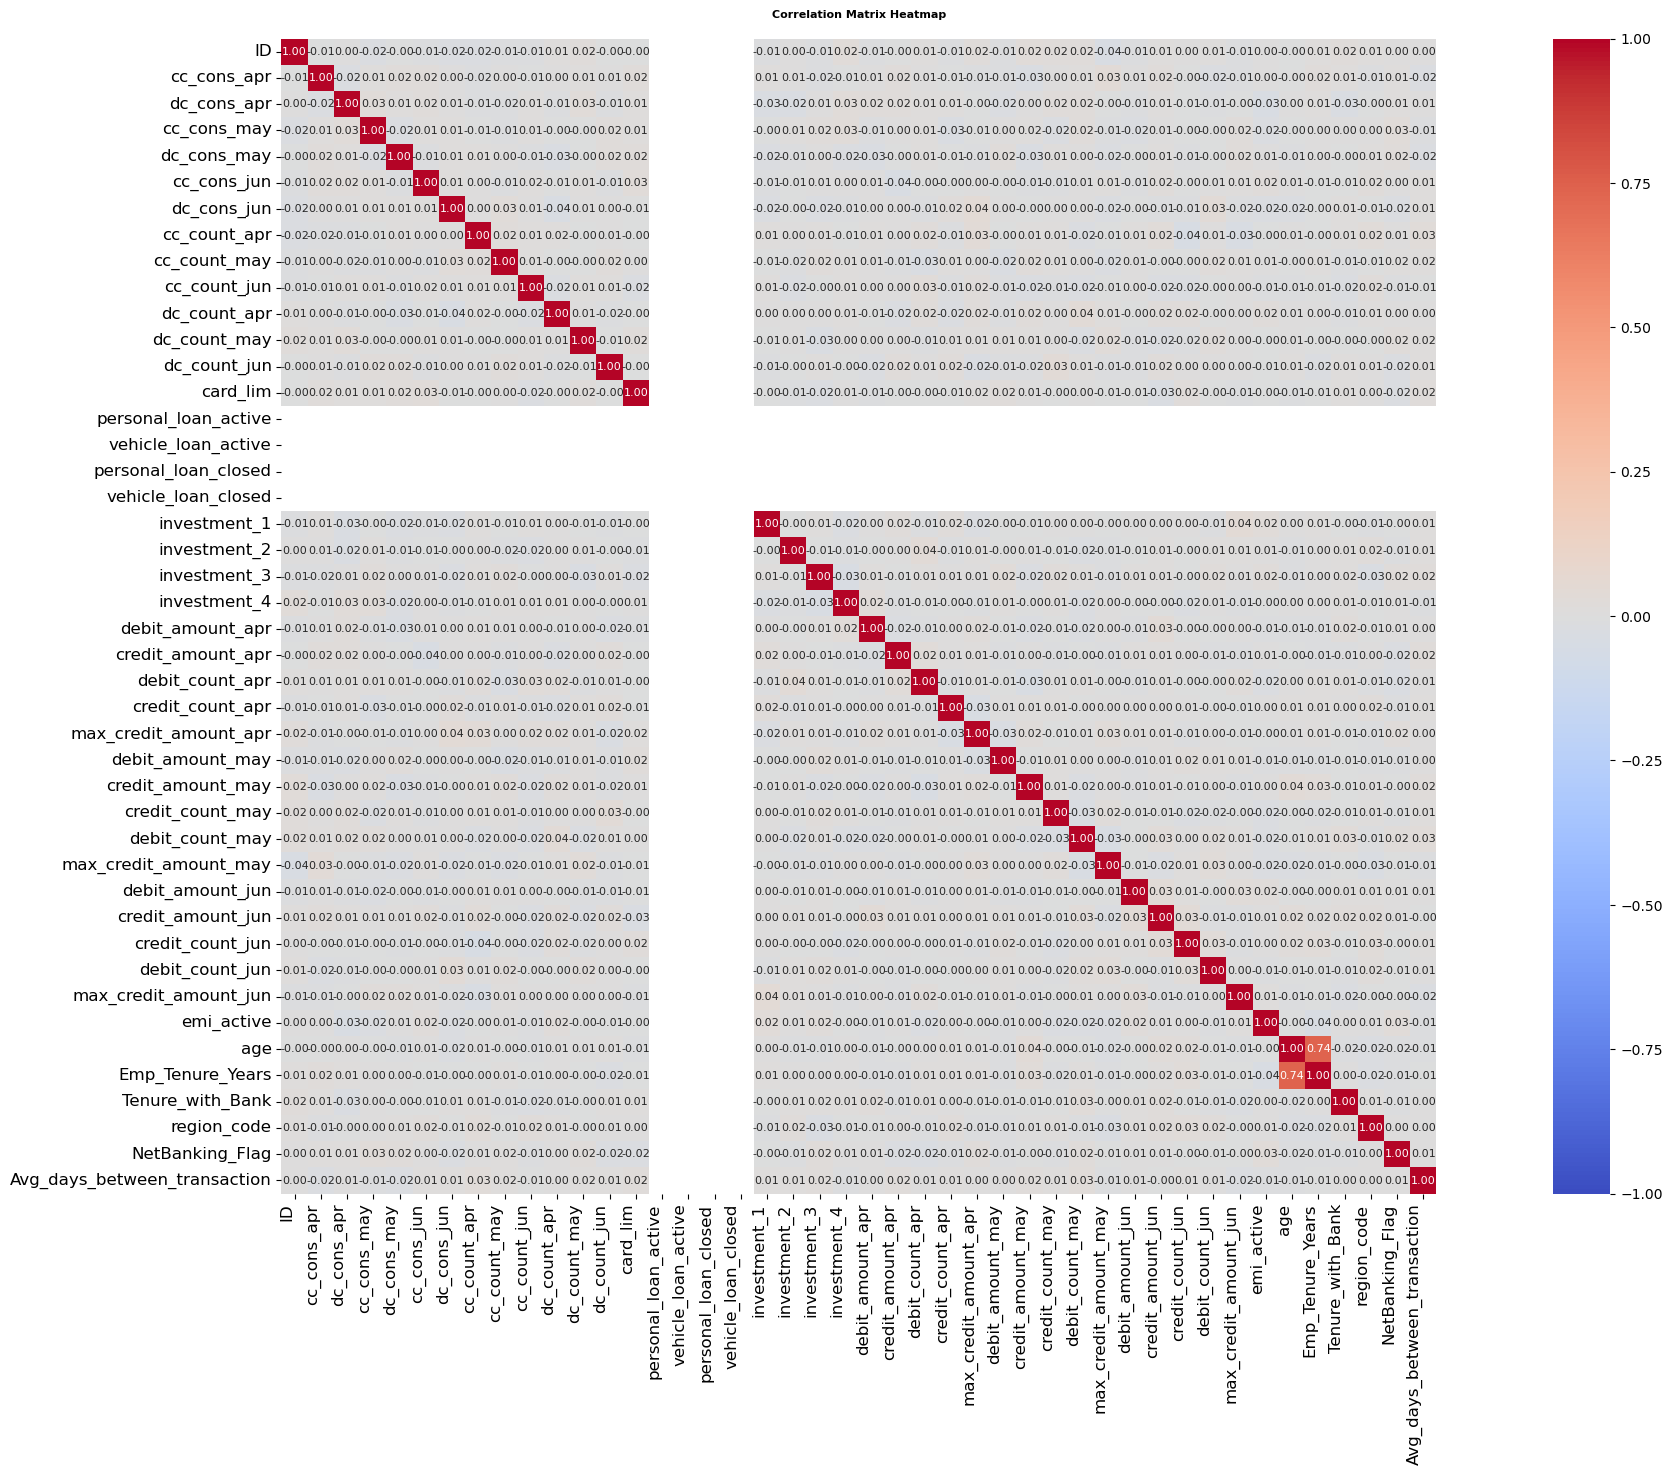

In [598]:
corr=pred_customer_df_num.corr()

plt.figure(figsize=(30,15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', 
            cbar=True, square=True, annot_kws={"size": 8},vmax=1, vmin=-1,center=0)
plt.title("Correlation Matrix Heatmap", fontsize=8, fontweight="bold", pad=15)
plt.xticks(rotation=90, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

# Fixing Skewness

In [600]:
def fix_skewness(df, threshold=1.0):
    df=df.copy()
    skewed_cols = df.skew()[df.skew().abs() > threshold].index

    for col in skewed_cols:
        if (df[col] <= 0).any():
            # If negative or zero values exist, use square root transformation
            df[col] = np.sqrt(df[col] - df[col].min() + 1)
        else:
            # First try log transformation
            df[col] = np.log1p(df[col])

            # If still skewed, try Box-Cox
            if df[col].skew() > threshold:
                df[col], _ = boxcox(df[col] + 1)

    return df

customer_df_num=fix_skewness(customer_df_num)
pred_customer_df_num=fix_skewness(pred_customer_df_num)

## Categorical Variables
Summary Statistic For Categorical Variable  

In [602]:
customer_df_cat=customer_df.select_dtypes(include=["object"])
pred_customer_df_cat=pred_customer_df.select_dtypes(include=["object"])
print(customer_df_cat.head())
print("\n",pred_customer_df_cat.head())

  loan_enq account_type gender  Income
0        Y      current      M  MEDIUM
1        Y      current      M     LOW
2        Y      current      M  MEDIUM
3        Y      current      M     LOW
4        Y       saving      M  MEDIUM

   loan_enq account_type gender  Income
0        Y      current      M  MEDIUM
1        Y      current      M  MEDIUM
2        Y      current      M     LOW
3        Y      current      M  MEDIUM
4        Y      current      M     LOW


In [603]:
customer_df_cat.describe()

loan_enq account_type gender  Income
count     15000        15000  15000   15000
unique        1            2      2       3
top           Y      current      M  MEDIUM
freq      15000        12727  12945    9612

In [604]:
pred_customer_df_cat.describe()

loan_enq account_type gender  Income
count      5000         5000   5000    5000
unique        1            2      2       3
top           Y      current      M  MEDIUM
freq       5000         4199   4343    3163

In [605]:
for i in customer_df_cat.columns:
    print(f"Number of categories in {i} is ",len(customer_df_cat[i].unique()))

Number of categories in loan_enq is  1
Number of categories in account_type is  2
Number of categories in gender is  2
Number of categories in Income is  3


In [606]:
for i in pred_customer_df_cat.columns:
    print(f"Number of categories in {i} is ",len(customer_df_cat[i].unique()))

Number of categories in loan_enq is  1
Number of categories in account_type is  2
Number of categories in gender is  2
Number of categories in Income is  3


In [607]:
for i in customer_df_cat.columns:
    print(f"Value Counts of categories in {i} is ",customer_df_cat[i].value_counts())

Value Counts of categories in loan_enq is  loan_enq
Y    15000
Name: count, dtype: int64
Value Counts of categories in account_type is  account_type
current    12727
saving      2273
Name: count, dtype: int64
Value Counts of categories in gender is  gender
M    12945
F     2055
Name: count, dtype: int64
Value Counts of categories in Income is  Income
MEDIUM    9612
LOW       4188
HIGH      1200
Name: count, dtype: int64


In [608]:
for i in pred_customer_df_cat.columns:
    print(f"Value Counts of categories in {i} is ",customer_df_cat[i].value_counts())

Value Counts of categories in loan_enq is  loan_enq
Y    15000
Name: count, dtype: int64
Value Counts of categories in account_type is  account_type
current    12727
saving      2273
Name: count, dtype: int64
Value Counts of categories in gender is  gender
M    12945
F     2055
Name: count, dtype: int64
Value Counts of categories in Income is  Income
MEDIUM    9612
LOW       4188
HIGH      1200
Name: count, dtype: int64


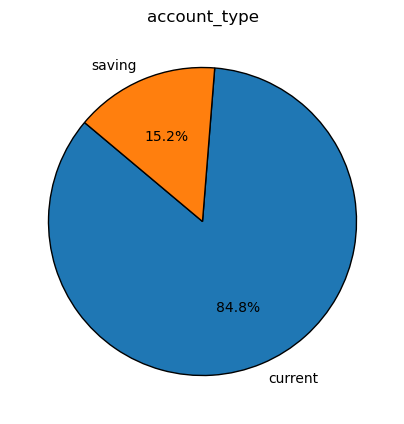

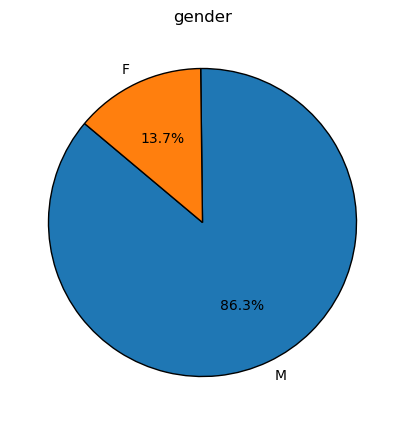

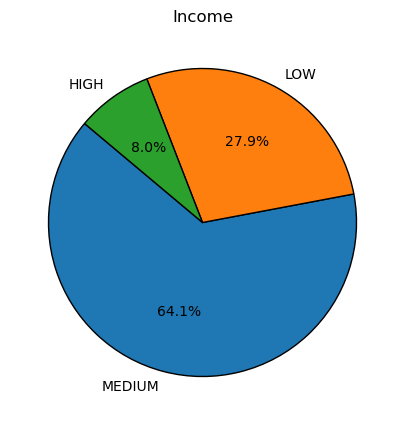

In [609]:
def plot_pie_charts(df):
    cols = customer_df_cat[["account_type","gender","Income"]].columns  
    for col in cols:
        plt.figure(figsize=(5, 5))  
        df[col].value_counts().plot(kind="pie", autopct='%1.1f%%', 
                                    startangle=140, wedgeprops={'edgecolor': 'black'})
        plt.title(col)
        plt.ylabel("")  
        plt.show()


plot_pie_charts(customer_df_cat)

* account_type insight:
  he distribution of account types (current or saving)
  84.8 % of the customers are having current account rest 15.1% have saving account

* gender insight:
  gender distributed among customers--
  86.3% of customer are MALE whereas only 13.6% are women.

* Income Insight:
  the income levels of the customers
  8% of customers have high income where as 27.9% have low rest 64.1% have medium.

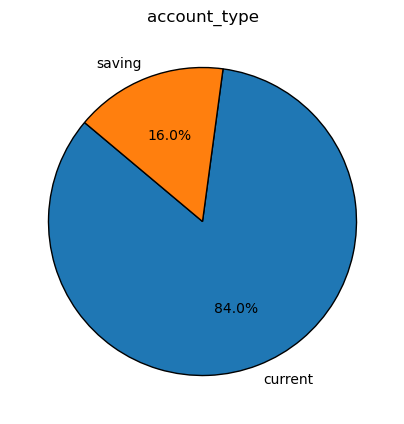

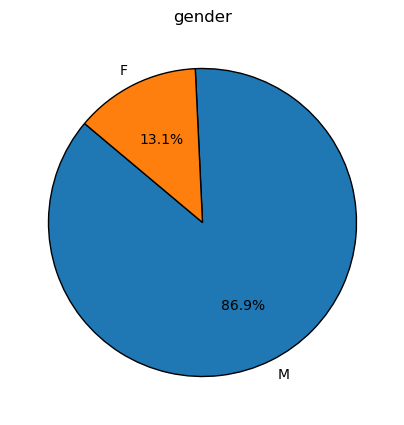

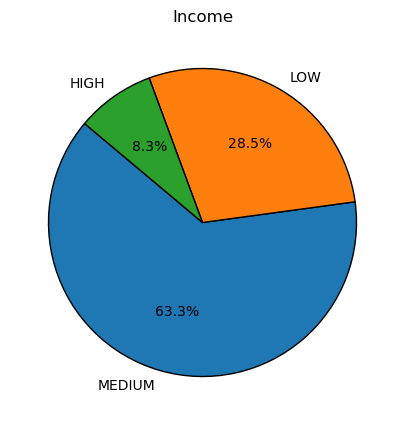

In [611]:
plot_pie_charts(pred_customer_df_cat)

* account_type insight:
  he distribution of account types (current or saving)
  84 % of the customers are having current account rest 16% have saving account

* gender insight:
  gender distributed among customers--
  86.9% of customer are MALE whereas only 13.1% are women.

* Income Insight:
  the income levels of the customers
  8.3% of customers have high income where as 28.5% have low rest 63.3% have medium.

# Preprocessing the Data
## Encode categorical variables
### One Hot Encoding

In [614]:
customer_df_cat=pd.get_dummies(customer_df_cat,columns=customer_df_cat.columns,drop_first=True).astype(int)
print("customer_df:\n",customer_df_cat.head())
pred_customer_df_cat=pd.get_dummies(pred_customer_df_cat,columns=pred_customer_df_cat.columns,drop_first=True).astype(int)
print("pred_customer_df:\n",pred_customer_df_cat.head())

customer_df:
    account_type_saving  gender_M  Income_LOW  Income_MEDIUM
0                    0         1           0              1
1                    0         1           1              0
2                    0         1           0              1
3                    0         1           1              0
4                    1         1           0              1
pred_customer_df:
    account_type_saving  gender_M  Income_LOW  Income_MEDIUM
0                    0         1           0              1
1                    0         1           0              1
2                    0         1           1              0
3                    0         1           0              1
4                    0         1           1              0


# Train and Test Data

In [616]:
train_df=pd.concat([customer_df_num,customer_df_cat],axis=1)
test_df=pd.concat([pred_customer_df_num,pred_customer_df_cat],axis=1)

print("train_df Shape:",train_df.shape)
print("test_df Shape:",test_df.shape)

train_df Shape: (15000, 48)
test_df Shape: (5000, 48)


## Define features and target

In [618]:
X=train_df.drop(columns=["cc_cons"])
y=np.log1p(train_df['cc_cons'])  # Apply log transformation

#### Selecting Top 15 Features

In [620]:
# Drop constant columns before computing correlation
X_filtered = X.loc[:, X.std() > 0]  # Keep only columns with non-zero standard deviation

# Feature selection using Pearson Correlation
corr_matrix = X_filtered.corrwith(y).abs()

# Select top 15 features
selected_features = corr_matrix.sort_values(ascending=False).head(15).index.tolist()
X_selected=X_filtered[selected_features]
test_selected=test_df[selected_features]

## Feature Scaling

In [622]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_selected)
test_scaled=scaler.transform(test_selected)

# Split train/test

In [624]:
X_train,X_val,y_train,y_val=train_test_split(X_selected,y,test_size=0.2,random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(12000, 15)
(3000, 15)
(12000,)
(3000,)


# Train models

#### 1.Linear Regression

In [627]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [628]:
y_pred_lr=lr_model.predict(X_val)
lr_rmspe_score=np.sqrt(np.mean(((y_val-y_pred_lr)/y_val) **2))*100
print("Root Mean Square Percentage Error (RMSPE) for Linear Regression Model:",lr_rmspe_score)

Root Mean Square Percentage Error (RMSPE) for Linear Regression Model: 17.865739315494324


#### 2.Decision Tree

In [630]:
DT_regressor_model=DecisionTreeRegressor()
DT_regressor_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [631]:
y_pred_DT=DT_regressor_model.predict(X_val)
DT_rmpse_score=np.sqrt(np.mean(((y_val-y_pred_DT)/y_val) **2))*100
print("Root Mean Square Percentage Error (RMSPE) for Decision Tree Model:",DT_rmpse_score)

Root Mean Square Percentage Error (RMSPE) for Decision Tree Model: 22.244830308221616


#### 3.Random Forest

In [633]:
RF_regressor_model=RandomForestRegressor()
RF_regressor_model.fit(X_train,y_train)

RandomForestRegressor()

In [634]:
y_pred_RF=RF_regressor_model.predict(X_val)
RF_rmpse_score=np.sqrt(np.mean(((y_val-y_pred_RF)/y_val) **2))*100
print("Root Mean Square Percentage Error (RMSPE) for Random Forest Model:",RF_rmpse_score)

Root Mean Square Percentage Error (RMSPE) for Random Forest Model: 17.92310845393286


#### 4.Gradient Boosting

In [636]:
GB_regressor_model=GradientBoostingRegressor()
GB_regressor_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [637]:
y_pred_GB=GB_regressor_model.predict(X_val)
GB_rmpse_score=np.sqrt(np.mean(((y_val-y_pred_GB)/y_val) **2))*100
print("Root Mean Square Percentage Error (RMSPE) for Gradient Boosting Model:",GB_rmpse_score)

Root Mean Square Percentage Error (RMSPE) for Gradient Boosting Model: 17.909125992402295


#### 5.XGBoost

In [639]:
XGB_regressor_model=XGBRegressor()
XGB_regressor_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [640]:
y_pred_XGB=XGB_regressor_model.predict(X_val)
XGB_rmpse_score=np.sqrt(np.mean(((y_val-y_pred_XGB)/y_val) **2))*100
print("Root Mean Square Percentage Error (RMSPE) for Gradient Boosting Model:",XGB_rmpse_score)

Root Mean Square Percentage Error (RMSPE) for Gradient Boosting Model: 18.661746352114825


In [641]:
rmspe_scores = {
    "Linear Regression": lr_rmspe_score,
    "Decision Tree": DT_rmpse_score,
    "Random Forest": RF_rmpse_score,
    "Gradient Boosting": GB_rmpse_score,
    "XGBoost": XGB_rmpse_score
}
bestmodel_df=pd.DataFrame(list(rmspe_scores.items()), columns=["Model Name", "RMSPE Score"])
bestmodel_df=bestmodel_df.sort_values(by="RMSPE Score", ascending=True)
bestmodel_df

Model Name  RMSPE Score
0  Linear Regression    17.865739
3  Gradient Boosting    17.909126
2      Random Forest    17.923108
4            XGBoost    18.661746
1      Decision Tree    22.244830

### Linear Regression is the best model hence we will predict CC_cons using this model

In [643]:
# Select best model
best_model=lr_model
best_model.fit(X_train,y_train)

LinearRegression()

In [644]:
# Predict for missing values
y_pred_test=best_model.predict(test_scaled)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [645]:
# Save predictions
predictions=pd.DataFrame({"ID": test_df['ID'], "Predicted_cc_cons": y_pred_test})
predictions.to_csv("credit_card_consumption_predictions.csv", index=False)

In [710]:
predictions

ID  Predicted_cc_cons
0     17591.0           9.485985
1     13541.0           9.509208
2     13431.0           9.481449
3      8687.0           9.513014
4     14727.0           9.510262
...       ...                ...
4995  12512.0           9.510341
4996  14224.0           9.468356
4997  18740.0           9.485307
4998  18134.0           9.449588
4999  12413.0           9.569253

[5000 rows x 2 columns]